<a href="https://colab.research.google.com/github/raindrop314159/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [2]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

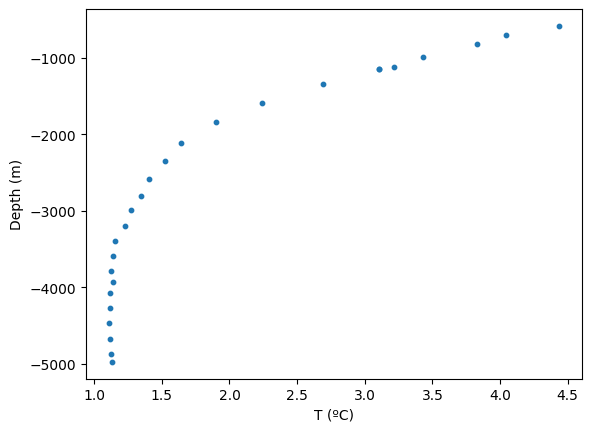

In [3]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+00/s


2025-11-12 13:28:55,136 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+00/s


Text(0, 0.5, 'Depth (m)')

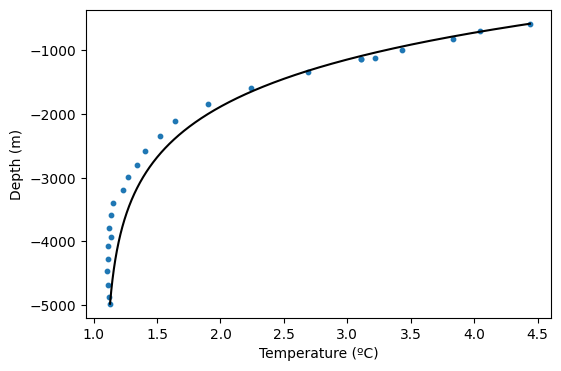

In [4]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)


# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=1e-4 # m^2/s

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

ADD DISCUSSION HERE

Diffusivity $\kappa = 10^{-4}$  gives a good match.

The steady advection/diffusion model demonstrates a reasonable fit to the temperature data at shallower depths, specifically from 0 to -1500 m. However, as depth increases beyond -1500 m, the model's accuracy declines. Specifically, between -3000 m and -5000 m, the actual temperature measurements exhibit a steeper gradient than the model predicts. Also, the observed data show more fluctuations, while the modeled values present a smoother curve. This suggests that the model may not fully capture the complexities of temperature variation at greater depths, indicating potential limitations in its ability to account for dynamic processes influencing heat distribution in the deep ocean. On the other hand, note that instruments may not perform as reliably in the deep ocean. Considering that the data was obtained in 1966 (Munk, 1966), fluctuations may reflect instrumental error rather than represent the actual temperature profile of deep ocean.

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


2025-11-12 13:28:56,756 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2025-11-12 13:28:57,067 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2025-11-12 13:28:57,179 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.6e+00/s


2025-11-12 13:28:57,305 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.6e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2025-11-12 13:28:57,416 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


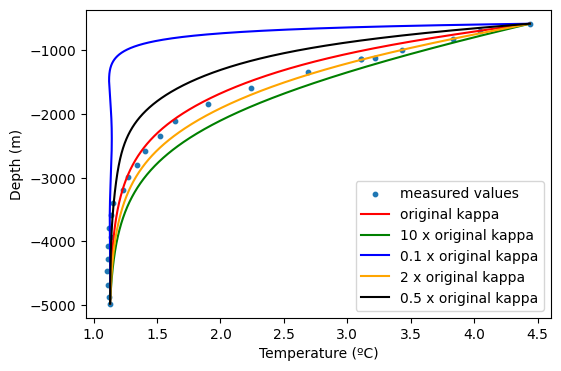

In [5]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 1e-8 # m/s
kappa_org = 1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667)
kappa_plus = 10*kappa_org
kappa_less = kappa_org/ 10
kappa_half = kappa_org*0.5
kappa_double = kappa_org*2

kappa_vals = [kappa_org, kappa_plus, kappa_less,kappa_half,kappa_double]
T_list = []

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

for kappa_i in kappa_vals:

  # Fields
  T = dist.Field(name='T', bases=zbasis)
  kappa = dist.Field(name='kappa_i', bases=zbasis)
  # Set the diffusivity
  # Below is the diffusivity profile from Rogers et al., 2023
  kappa['g']= kappa_i  # m^2/s

  # Add two tau variables to allow us to apply two boundary conditions
  tau_1 = dist.Field(name='tau_1')
  tau_2 = dist.Field(name='tau_2')
  lift_basis = zbasis.derivative_basis(1)
  lift = lambda A: d3.Lift(A, lift_basis, -1)

  # Substitutions
  dz = lambda A: d3.Differentiate(A, zcoord)
  Tz = dz(T) + lift(tau_1)
  Tzz = dz(Tz) + lift(tau_2)

  # Problem
  problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
  problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
  problem.add_equation("T(z=z_surface) = T_surface")
  problem.add_equation("T(z=z_bottom) = T_bottom")

  # Solver
  solver = problem.build_solver()
  solver.solve()
  T_list.append(T['g'])

# Plot
plt.figure(figsize=(6, 4))
#Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10, label = "measured values")
plt.plot(T_list[0], z, 'r', label="original kappa")
plt.plot(T_list[1], z, 'g', label="10 x original kappa")
plt.plot(T_list[2], z, 'b', label="0.1 x original kappa")
plt.plot(T_list[4], z, 'orange', label="2 x original kappa")
plt.plot(T_list[3], z, 'k', label="0.5 x original kappa")


plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the required vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

INSERT COMMENTS HERE

In terms of balance, since $w=0$, the absence of advection means that temperature changes are solely driven by diffusion.

$w=0$ implies that the diffusive heat flux $\frac{dT}{dz}$ is constant since $\frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$ = 0 where $\kappa$ is a non-zero constant.

A vertical velocity $w =10^8 m/s$  produces a good agreement.

Keeping the same vertical velocity $w =10^8 m/s$ as optimal $w$, $\kappa$ was varied by factors of 10, 0.1, 2, 0.5, and the results were plotted on the graph above. It was observed that optimal $w$ is rather sensitive to a change in $\kappa$. Also, the optimal $w$ is more sensitive to a decrease in $\kappa$ value compared to an increase of the same order of magnitude.

If $\kappa$ varies between regions of smooth and rough topography, the efficiency of heat transport could change dramatically across different oceanic regions since optimal $w$ is senstive to the change in $\kappa$. For example, in areas of rough topography, such as those featuring seamounts or complex seabed structures, increased turbulence can enhance mixing processes. This is bexause depth-dependent turbulent diffusivity $\kappa$ could be balanced by downwelling, with negative vertical velocities $(-w)$ in the ocean interior. Areas of downwelling (where cold water sinks) can then be balanced by upwelling zones (where warm water rises), which enhances overall circulation in the ocean interior. Upwelling brings nutrient-rich deep waters to the surface, supporting the marine ecosystems and helping to drive currents.

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [6]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 1e-2 # diffusivity in m^2/s
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='c', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2025-11-12 13:28:58,461 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:__main__:Starting main loop


2025-11-12 13:28:58,466 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 13:28:59,307 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 13:28:59,368 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 13:28:59,415 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 13:28:59,466 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 13:28:59,512 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 13:28:59,556 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 13:28:59,599 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 13:28:59,642 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 13:28:59,690 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 13:28:59,737 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 13:28:59,784 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 13:28:59,832 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 13:28:59,879 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 13:28:59,920 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 13:28:59,967 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 13:29:00,012 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 13:29:00,053 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 13:29:00,095 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 13:29:00,149 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 13:29:00,196 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 13:29:00,246 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 13:29:00,293 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 13:29:00,335 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 13:29:00,366 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 13:29:00,396 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 13:29:00,424 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 13:29:00,453 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 13:29:00,483 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 13:29:00,512 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 13:29:00,540 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 13:29:00,571 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 13:29:00,600 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 13:29:00,628 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 13:29:00,660 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 13:29:00,693 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 13:29:00,724 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 13:29:00,754 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 13:29:00,782 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 13:29:00,812 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 13:29:00,843 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 13:29:00,874 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 13:29:00,904 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 13:29:00,936 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 13:29:00,965 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 13:29:00,994 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 13:29:01,023 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 13:29:01,053 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 13:29:01,091 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 13:29:01,122 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 13:29:01,151 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 13:29:01,182 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 13:29:01,215 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 13:29:01,247 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 13:29:01,288 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 13:29:01,325 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 13:29:01,355 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 13:29:01,386 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 13:29:01,417 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 13:29:01,447 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 13:29:01,479 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 13:29:01,509 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 13:29:01,539 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 13:29:01,569 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 13:29:01,599 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 13:29:01,628 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 13:29:01,657 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 13:29:01,690 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 13:29:01,721 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 13:29:01,752 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 13:29:01,782 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 13:29:01,813 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 13:29:01,844 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 13:29:01,874 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 13:29:01,904 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 13:29:01,936 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 13:29:01,966 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 13:29:01,996 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 13:29:02,022 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 13:29:02,026 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 13:29:02,029 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.6521 sec


2025-11-12 13:29:02,030 solvers 0/1 INFO :: Setup time (init - iter 0): 0.6521 sec


INFO:solvers:Warmup time (iter 0-10): 0.893 sec


2025-11-12 13:29:02,031 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.893 sec


INFO:solvers:Run time (iter 10-end): 2.663 sec


2025-11-12 13:29:02,033 solvers 0/1 INFO :: Run time (iter 10-end): 2.663 sec


INFO:solvers:CPU time (iter 10-end): 0.0007398 cpu-hr


2025-11-12 13:29:02,035 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007398 cpu-hr


INFO:solvers:Speed: 4.935e+06 mode-stages/cpu-sec


2025-11-12 13:29:02,036 solvers 0/1 INFO :: Speed: 4.935e+06 mode-stages/cpu-sec


In [7]:
# Wrap the above into a function such that U0 and kappa can be varied more easily
def simulate_pollution(U0, kappa):
    import numpy as np
    import matplotlib.pyplot as plt
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

  # Set parameters
    #U0 = 0.1 # maximum current speed in m/s
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
    #kappa = 1e-2 # diffusivity in m^2/s
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])];

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    return c_save, np.array(t_save)

Check whether the new function returns same output c_save:

In [8]:
#print(xbasis)
#print(c.global_shape)
#print(c_save.shape)
#c_concentration = simulate_pollution(U0=0.1, kappa=1e-2)
#diff = c_save - c_concentration
#print(diff)
#print(c_concentration.shape)
#frobenius_norm = np.linalg.norm(diff)/np.linalg.norm(c_save)
#print(frobenius_norm)


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-12 13:29:02,187 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpvxm5d2ta/temp.m4v


2025-11-12 13:29:02,190 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpvxm5d2ta/temp.m4v


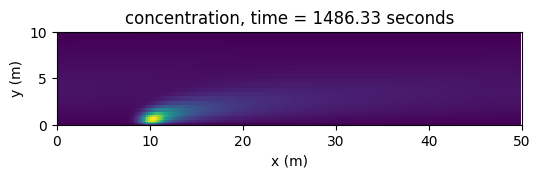

In [9]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

## 2.3 Student investigation
<a id='section2pt3'></a>
### Advective/diffusive timescales
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

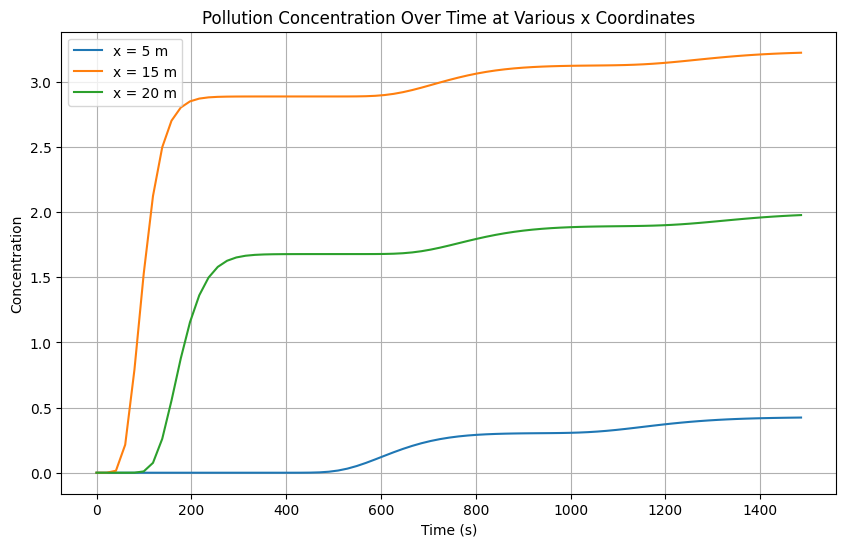

In [10]:
# Target coordinates
target_x = [5, 15, 20]  # Example x coordinates in meters
target_y = 2                # Example y coordinate in meters

# Prepare to plot
plt.figure(figsize=(10, 6))

for x_i in target_x:
    # Find the nearest indices
    x_indices = (np.abs(x - x_i)).argmin()  # Nearest x index from simulation grid
    y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

    # Extract the concentration data at the specified (x, y)
    concentration_over_time = c_save[:, x_indices, y_indices]

    # Plot the concentration over time
    plt.plot(t_save, concentration_over_time, label=f'x = {x_i} m')

# Add labels and legend
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various x Coordinates')
plt.legend()
plt.grid()
plt.show()

The source of pollutant is located at $x=10 m$ and flows in the positive direction. As a result, $x=15m (orange\ line)$ first sees an increase in concentration around $t=50s$. Then, $x=20m (green\ line)$ sees an increase shortly after at around $t=100s$. Finally, $x=5m (blue\ line)$, which is upstream of the pollutant source, sees an increase at around $t=500s$. This is because the pollutant is not brought backwards by flow (which flows forwards), but rather by diffusion only.

Vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters:

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2025-11-12 13:29:18,958 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


INFO:__main__:Starting main loop


2025-11-12 13:29:18,963 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+01, dt=1.953125e+01


2025-11-12 13:29:19,000 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+01, dt=1.953125e+01


INFO:__main__:Iteration=11, Time=2.148438e+02, dt=1.953125e+01


2025-11-12 13:29:19,027 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+02, dt=1.953125e+01


INFO:__main__:Iteration=21, Time=4.101562e+02, dt=1.953125e+01


2025-11-12 13:29:19,055 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+02, dt=1.953125e+01


INFO:__main__:Iteration=31, Time=6.054688e+02, dt=1.953125e+01


2025-11-12 13:29:19,083 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+02, dt=1.953125e+01


INFO:__main__:Iteration=41, Time=8.007812e+02, dt=1.953125e+01


2025-11-12 13:29:19,111 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+02, dt=1.953125e+01


INFO:__main__:Iteration=51, Time=9.960938e+02, dt=1.953125e+01


2025-11-12 13:29:19,139 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+02, dt=1.953125e+01


INFO:__main__:Iteration=61, Time=1.191406e+03, dt=1.953125e+01


2025-11-12 13:29:19,182 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+03, dt=1.953125e+01


INFO:__main__:Iteration=71, Time=1.386719e+03, dt=1.953125e+01


2025-11-12 13:29:19,209 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+03, dt=1.953125e+01


INFO:solvers:Simulation stop time reached.


2025-11-12 13:29:19,231 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 77


2025-11-12 13:29:19,234 solvers 0/1 INFO :: Final iteration: 77


INFO:solvers:Final sim time: 1503.90625


2025-11-12 13:29:19,236 solvers 0/1 INFO :: Final sim time: 1503.90625


INFO:solvers:Setup time (init - iter 0): 0.2305 sec


2025-11-12 13:29:19,241 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2305 sec


INFO:solvers:Warmup time (iter 0-10): 0.06001 sec


2025-11-12 13:29:19,244 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06001 sec


INFO:solvers:Run time (iter 10-end): 0.2084 sec


2025-11-12 13:29:19,246 solvers 0/1 INFO :: Run time (iter 10-end): 0.2084 sec


INFO:solvers:CPU time (iter 10-end): 5.788e-05 cpu-hr


2025-11-12 13:29:19,248 solvers 0/1 INFO :: CPU time (iter 10-end): 5.788e-05 cpu-hr


INFO:solvers:Speed: 5.576e+06 mode-stages/cpu-sec


2025-11-12 13:29:19,250 solvers 0/1 INFO :: Speed: 5.576e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2025-11-12 13:29:19,519 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


INFO:__main__:Starting main loop


2025-11-12 13:29:19,525 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 13:29:19,562 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 13:29:19,591 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 13:29:19,621 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 13:29:19,651 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 13:29:19,680 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 13:29:19,709 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 13:29:19,739 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 13:29:19,767 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 13:29:19,800 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 13:29:19,830 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 13:29:19,859 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 13:29:19,889 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 13:29:19,917 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 13:29:19,945 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 13:29:19,975 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 13:29:20,004 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 13:29:20,032 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 13:29:20,067 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 13:29:20,096 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 13:29:20,125 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 13:29:20,156 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 13:29:20,186 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 13:29:20,231 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 13:29:20,261 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 13:29:20,291 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 13:29:20,327 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 13:29:20,356 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 13:29:20,387 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 13:29:20,415 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 13:29:20,444 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 13:29:20,475 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 13:29:20,503 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 13:29:20,532 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 13:29:20,562 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 13:29:20,593 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 13:29:20,622 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 13:29:20,652 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 13:29:20,681 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 13:29:20,710 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 13:29:20,738 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 13:29:20,768 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 13:29:20,800 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 13:29:20,828 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 13:29:20,860 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 13:29:20,888 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 13:29:20,917 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 13:29:20,946 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 13:29:20,977 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 13:29:21,007 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 13:29:21,037 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 13:29:21,068 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 13:29:21,098 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 13:29:21,131 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 13:29:21,163 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 13:29:21,192 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 13:29:21,233 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 13:29:21,277 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 13:29:21,308 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 13:29:21,340 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 13:29:21,372 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 13:29:21,402 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 13:29:21,433 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 13:29:21,463 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 13:29:21,494 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 13:29:21,523 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 13:29:21,553 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 13:29:21,583 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 13:29:21,614 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 13:29:21,644 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 13:29:21,677 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 13:29:21,708 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 13:29:21,737 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 13:29:21,768 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 13:29:21,802 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 13:29:21,832 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 13:29:21,863 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 13:29:21,892 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 13:29:21,917 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 13:29:21,919 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 13:29:21,920 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2431 sec


2025-11-12 13:29:21,922 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2431 sec


INFO:solvers:Warmup time (iter 0-10): 0.06196 sec


2025-11-12 13:29:21,925 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06196 sec


INFO:solvers:Run time (iter 10-end): 2.33 sec


2025-11-12 13:29:21,927 solvers 0/1 INFO :: Run time (iter 10-end): 2.33 sec


INFO:solvers:CPU time (iter 10-end): 0.0006473 cpu-hr


2025-11-12 13:29:21,929 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006473 cpu-hr


INFO:solvers:Speed: 5.64e+06 mode-stages/cpu-sec


2025-11-12 13:29:21,932 solvers 0/1 INFO :: Speed: 5.64e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


2025-11-12 13:29:22,204 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.8e+00/s


INFO:__main__:Starting main loop


2025-11-12 13:29:22,212 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e-01, dt=1.953125e-01


2025-11-12 13:29:22,258 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e-01, dt=1.953125e-01


INFO:__main__:Iteration=11, Time=2.148438e+00, dt=1.953125e-01


2025-11-12 13:29:22,299 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+00, dt=1.953125e-01


INFO:__main__:Iteration=21, Time=4.101562e+00, dt=1.953125e-01


2025-11-12 13:29:22,338 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+00, dt=1.953125e-01


INFO:__main__:Iteration=31, Time=6.054688e+00, dt=1.953125e-01


2025-11-12 13:29:22,370 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+00, dt=1.953125e-01


INFO:__main__:Iteration=41, Time=8.007812e+00, dt=1.953125e-01


2025-11-12 13:29:22,402 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+00, dt=1.953125e-01


INFO:__main__:Iteration=51, Time=9.960938e+00, dt=1.953125e-01


2025-11-12 13:29:22,434 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+00, dt=1.953125e-01


INFO:__main__:Iteration=61, Time=1.191406e+01, dt=1.953125e-01


2025-11-12 13:29:22,465 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+01, dt=1.953125e-01


INFO:__main__:Iteration=71, Time=1.386719e+01, dt=1.953125e-01


2025-11-12 13:29:22,499 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+01, dt=1.953125e-01


INFO:__main__:Iteration=81, Time=1.582031e+01, dt=1.953125e-01


2025-11-12 13:29:22,528 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+01, dt=1.953125e-01


INFO:__main__:Iteration=91, Time=1.777344e+01, dt=1.953125e-01


2025-11-12 13:29:22,560 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+01, dt=1.953125e-01


INFO:__main__:Iteration=101, Time=1.972656e+01, dt=1.953125e-01


2025-11-12 13:29:22,594 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+01, dt=1.953125e-01


INFO:__main__:Iteration=111, Time=2.167969e+01, dt=1.953125e-01


2025-11-12 13:29:22,625 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+01, dt=1.953125e-01


INFO:__main__:Iteration=121, Time=2.363281e+01, dt=1.953125e-01


2025-11-12 13:29:22,655 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+01, dt=1.953125e-01


INFO:__main__:Iteration=131, Time=2.558594e+01, dt=1.953125e-01


2025-11-12 13:29:22,696 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+01, dt=1.953125e-01


INFO:__main__:Iteration=141, Time=2.753906e+01, dt=1.953125e-01


2025-11-12 13:29:22,734 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+01, dt=1.953125e-01


INFO:__main__:Iteration=151, Time=2.949219e+01, dt=1.953125e-01


2025-11-12 13:29:22,771 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+01, dt=1.953125e-01


INFO:__main__:Iteration=161, Time=3.144531e+01, dt=1.953125e-01


2025-11-12 13:29:22,804 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+01, dt=1.953125e-01


INFO:__main__:Iteration=171, Time=3.339844e+01, dt=1.953125e-01


2025-11-12 13:29:22,847 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+01, dt=1.953125e-01


INFO:__main__:Iteration=181, Time=3.535156e+01, dt=1.953125e-01


2025-11-12 13:29:22,883 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+01, dt=1.953125e-01


INFO:__main__:Iteration=191, Time=3.730469e+01, dt=1.953125e-01


2025-11-12 13:29:22,924 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+01, dt=1.953125e-01


INFO:__main__:Iteration=201, Time=3.925781e+01, dt=1.953125e-01


2025-11-12 13:29:22,958 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+01, dt=1.953125e-01


INFO:__main__:Iteration=211, Time=4.121094e+01, dt=1.953125e-01


2025-11-12 13:29:22,993 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+01, dt=1.953125e-01


INFO:__main__:Iteration=221, Time=4.316406e+01, dt=1.953125e-01


2025-11-12 13:29:23,046 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+01, dt=1.953125e-01


INFO:__main__:Iteration=231, Time=4.511719e+01, dt=1.953125e-01


2025-11-12 13:29:23,085 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+01, dt=1.953125e-01


INFO:__main__:Iteration=241, Time=4.707031e+01, dt=1.953125e-01


2025-11-12 13:29:23,121 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+01, dt=1.953125e-01


INFO:__main__:Iteration=251, Time=4.902344e+01, dt=1.953125e-01


2025-11-12 13:29:23,163 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+01, dt=1.953125e-01


INFO:__main__:Iteration=261, Time=5.097656e+01, dt=1.953125e-01


2025-11-12 13:29:23,220 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+01, dt=1.953125e-01


INFO:__main__:Iteration=271, Time=5.292969e+01, dt=1.953125e-01


2025-11-12 13:29:23,272 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+01, dt=1.953125e-01


INFO:__main__:Iteration=281, Time=5.488281e+01, dt=1.953125e-01


2025-11-12 13:29:23,326 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+01, dt=1.953125e-01


INFO:__main__:Iteration=291, Time=5.683594e+01, dt=1.953125e-01


2025-11-12 13:29:23,394 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+01, dt=1.953125e-01


INFO:__main__:Iteration=301, Time=5.878906e+01, dt=1.953125e-01


2025-11-12 13:29:23,460 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+01, dt=1.953125e-01


INFO:__main__:Iteration=311, Time=6.074219e+01, dt=1.953125e-01


2025-11-12 13:29:23,510 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+01, dt=1.953125e-01


INFO:__main__:Iteration=321, Time=6.269531e+01, dt=1.953125e-01


2025-11-12 13:29:23,564 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+01, dt=1.953125e-01


INFO:__main__:Iteration=331, Time=6.464844e+01, dt=1.953125e-01


2025-11-12 13:29:23,615 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+01, dt=1.953125e-01


INFO:__main__:Iteration=341, Time=6.660156e+01, dt=1.953125e-01


2025-11-12 13:29:23,667 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+01, dt=1.953125e-01


INFO:__main__:Iteration=351, Time=6.855469e+01, dt=1.953125e-01


2025-11-12 13:29:23,716 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+01, dt=1.953125e-01


INFO:__main__:Iteration=361, Time=7.050781e+01, dt=1.953125e-01


2025-11-12 13:29:23,762 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+01, dt=1.953125e-01


INFO:__main__:Iteration=371, Time=7.246094e+01, dt=1.953125e-01


2025-11-12 13:29:23,814 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+01, dt=1.953125e-01


INFO:__main__:Iteration=381, Time=7.441406e+01, dt=1.953125e-01


2025-11-12 13:29:23,864 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+01, dt=1.953125e-01


INFO:__main__:Iteration=391, Time=7.636719e+01, dt=1.953125e-01


2025-11-12 13:29:23,909 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+01, dt=1.953125e-01


INFO:__main__:Iteration=401, Time=7.832031e+01, dt=1.953125e-01


2025-11-12 13:29:23,955 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+01, dt=1.953125e-01


INFO:__main__:Iteration=411, Time=8.027344e+01, dt=1.953125e-01


2025-11-12 13:29:24,010 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+01, dt=1.953125e-01


INFO:__main__:Iteration=421, Time=8.222656e+01, dt=1.953125e-01


2025-11-12 13:29:24,057 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+01, dt=1.953125e-01


INFO:__main__:Iteration=431, Time=8.417969e+01, dt=1.953125e-01


2025-11-12 13:29:24,106 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+01, dt=1.953125e-01


INFO:__main__:Iteration=441, Time=8.613281e+01, dt=1.953125e-01


2025-11-12 13:29:24,161 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+01, dt=1.953125e-01


INFO:__main__:Iteration=451, Time=8.808594e+01, dt=1.953125e-01


2025-11-12 13:29:24,210 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+01, dt=1.953125e-01


INFO:__main__:Iteration=461, Time=9.003906e+01, dt=1.953125e-01


2025-11-12 13:29:24,254 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+01, dt=1.953125e-01


INFO:__main__:Iteration=471, Time=9.199219e+01, dt=1.953125e-01


2025-11-12 13:29:24,299 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+01, dt=1.953125e-01


INFO:__main__:Iteration=481, Time=9.394531e+01, dt=1.953125e-01


2025-11-12 13:29:24,359 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+01, dt=1.953125e-01


INFO:__main__:Iteration=491, Time=9.589844e+01, dt=1.953125e-01


2025-11-12 13:29:24,412 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+01, dt=1.953125e-01


INFO:__main__:Iteration=501, Time=9.785156e+01, dt=1.953125e-01


2025-11-12 13:29:24,465 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+01, dt=1.953125e-01


INFO:__main__:Iteration=511, Time=9.980469e+01, dt=1.953125e-01


2025-11-12 13:29:24,515 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+01, dt=1.953125e-01


INFO:__main__:Iteration=521, Time=1.017578e+02, dt=1.953125e-01


2025-11-12 13:29:24,579 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+02, dt=1.953125e-01


INFO:__main__:Iteration=531, Time=1.037109e+02, dt=1.953125e-01


2025-11-12 13:29:24,623 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+02, dt=1.953125e-01


INFO:__main__:Iteration=541, Time=1.056641e+02, dt=1.953125e-01


2025-11-12 13:29:24,676 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+02, dt=1.953125e-01


INFO:__main__:Iteration=551, Time=1.076172e+02, dt=1.953125e-01


2025-11-12 13:29:24,731 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+02, dt=1.953125e-01


INFO:__main__:Iteration=561, Time=1.095703e+02, dt=1.953125e-01


2025-11-12 13:29:24,773 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+02, dt=1.953125e-01


INFO:__main__:Iteration=571, Time=1.115234e+02, dt=1.953125e-01


2025-11-12 13:29:24,826 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+02, dt=1.953125e-01


INFO:__main__:Iteration=581, Time=1.134766e+02, dt=1.953125e-01


2025-11-12 13:29:24,874 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+02, dt=1.953125e-01


INFO:__main__:Iteration=591, Time=1.154297e+02, dt=1.953125e-01


2025-11-12 13:29:24,926 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+02, dt=1.953125e-01


INFO:__main__:Iteration=601, Time=1.173828e+02, dt=1.953125e-01


2025-11-12 13:29:24,974 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+02, dt=1.953125e-01


INFO:__main__:Iteration=611, Time=1.193359e+02, dt=1.953125e-01


2025-11-12 13:29:25,015 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+02, dt=1.953125e-01


INFO:__main__:Iteration=621, Time=1.212891e+02, dt=1.953125e-01


2025-11-12 13:29:25,058 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+02, dt=1.953125e-01


INFO:__main__:Iteration=631, Time=1.232422e+02, dt=1.953125e-01


2025-11-12 13:29:25,114 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+02, dt=1.953125e-01


INFO:__main__:Iteration=641, Time=1.251953e+02, dt=1.953125e-01


2025-11-12 13:29:25,159 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+02, dt=1.953125e-01


INFO:__main__:Iteration=651, Time=1.271484e+02, dt=1.953125e-01


2025-11-12 13:29:25,208 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+02, dt=1.953125e-01


INFO:__main__:Iteration=661, Time=1.291016e+02, dt=1.953125e-01


2025-11-12 13:29:25,258 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+02, dt=1.953125e-01


INFO:__main__:Iteration=671, Time=1.310547e+02, dt=1.953125e-01


2025-11-12 13:29:25,306 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+02, dt=1.953125e-01


INFO:__main__:Iteration=681, Time=1.330078e+02, dt=1.953125e-01


2025-11-12 13:29:25,349 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+02, dt=1.953125e-01


INFO:__main__:Iteration=691, Time=1.349609e+02, dt=1.953125e-01


2025-11-12 13:29:25,394 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+02, dt=1.953125e-01


INFO:__main__:Iteration=701, Time=1.369141e+02, dt=1.953125e-01


2025-11-12 13:29:25,442 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+02, dt=1.953125e-01


INFO:__main__:Iteration=711, Time=1.388672e+02, dt=1.953125e-01


2025-11-12 13:29:25,495 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+02, dt=1.953125e-01


INFO:__main__:Iteration=721, Time=1.408203e+02, dt=1.953125e-01


2025-11-12 13:29:25,541 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+02, dt=1.953125e-01


INFO:__main__:Iteration=731, Time=1.427734e+02, dt=1.953125e-01


2025-11-12 13:29:25,595 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+02, dt=1.953125e-01


INFO:__main__:Iteration=741, Time=1.447266e+02, dt=1.953125e-01


2025-11-12 13:29:25,659 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+02, dt=1.953125e-01


INFO:__main__:Iteration=751, Time=1.466797e+02, dt=1.953125e-01


2025-11-12 13:29:25,721 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+02, dt=1.953125e-01


INFO:__main__:Iteration=761, Time=1.486328e+02, dt=1.953125e-01


2025-11-12 13:29:25,783 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+02, dt=1.953125e-01


INFO:__main__:Iteration=771, Time=1.505859e+02, dt=1.953125e-01


2025-11-12 13:29:25,837 __main__ 0/1 INFO :: Iteration=771, Time=1.505859e+02, dt=1.953125e-01


INFO:__main__:Iteration=781, Time=1.525391e+02, dt=1.953125e-01


2025-11-12 13:29:25,895 __main__ 0/1 INFO :: Iteration=781, Time=1.525391e+02, dt=1.953125e-01


INFO:__main__:Iteration=791, Time=1.544922e+02, dt=1.953125e-01


2025-11-12 13:29:25,944 __main__ 0/1 INFO :: Iteration=791, Time=1.544922e+02, dt=1.953125e-01


INFO:__main__:Iteration=801, Time=1.564453e+02, dt=1.953125e-01


2025-11-12 13:29:26,004 __main__ 0/1 INFO :: Iteration=801, Time=1.564453e+02, dt=1.953125e-01


INFO:__main__:Iteration=811, Time=1.583984e+02, dt=1.953125e-01


2025-11-12 13:29:26,057 __main__ 0/1 INFO :: Iteration=811, Time=1.583984e+02, dt=1.953125e-01


INFO:__main__:Iteration=821, Time=1.603516e+02, dt=1.953125e-01


2025-11-12 13:29:26,116 __main__ 0/1 INFO :: Iteration=821, Time=1.603516e+02, dt=1.953125e-01


INFO:__main__:Iteration=831, Time=1.623047e+02, dt=1.953125e-01


2025-11-12 13:29:26,174 __main__ 0/1 INFO :: Iteration=831, Time=1.623047e+02, dt=1.953125e-01


INFO:__main__:Iteration=841, Time=1.642578e+02, dt=1.953125e-01


2025-11-12 13:29:26,237 __main__ 0/1 INFO :: Iteration=841, Time=1.642578e+02, dt=1.953125e-01


INFO:__main__:Iteration=851, Time=1.662109e+02, dt=1.953125e-01


2025-11-12 13:29:26,297 __main__ 0/1 INFO :: Iteration=851, Time=1.662109e+02, dt=1.953125e-01


INFO:__main__:Iteration=861, Time=1.681641e+02, dt=1.953125e-01


2025-11-12 13:29:26,370 __main__ 0/1 INFO :: Iteration=861, Time=1.681641e+02, dt=1.953125e-01


INFO:__main__:Iteration=871, Time=1.701172e+02, dt=1.953125e-01


2025-11-12 13:29:26,432 __main__ 0/1 INFO :: Iteration=871, Time=1.701172e+02, dt=1.953125e-01


INFO:__main__:Iteration=881, Time=1.720703e+02, dt=1.953125e-01


2025-11-12 13:29:26,500 __main__ 0/1 INFO :: Iteration=881, Time=1.720703e+02, dt=1.953125e-01


INFO:__main__:Iteration=891, Time=1.740234e+02, dt=1.953125e-01


2025-11-12 13:29:26,557 __main__ 0/1 INFO :: Iteration=891, Time=1.740234e+02, dt=1.953125e-01


INFO:__main__:Iteration=901, Time=1.759766e+02, dt=1.953125e-01


2025-11-12 13:29:26,627 __main__ 0/1 INFO :: Iteration=901, Time=1.759766e+02, dt=1.953125e-01


INFO:__main__:Iteration=911, Time=1.779297e+02, dt=1.953125e-01


2025-11-12 13:29:26,681 __main__ 0/1 INFO :: Iteration=911, Time=1.779297e+02, dt=1.953125e-01


INFO:__main__:Iteration=921, Time=1.798828e+02, dt=1.953125e-01


2025-11-12 13:29:26,751 __main__ 0/1 INFO :: Iteration=921, Time=1.798828e+02, dt=1.953125e-01


INFO:__main__:Iteration=931, Time=1.818359e+02, dt=1.953125e-01


2025-11-12 13:29:26,809 __main__ 0/1 INFO :: Iteration=931, Time=1.818359e+02, dt=1.953125e-01


INFO:__main__:Iteration=941, Time=1.837891e+02, dt=1.953125e-01


2025-11-12 13:29:26,872 __main__ 0/1 INFO :: Iteration=941, Time=1.837891e+02, dt=1.953125e-01


INFO:__main__:Iteration=951, Time=1.857422e+02, dt=1.953125e-01


2025-11-12 13:29:26,936 __main__ 0/1 INFO :: Iteration=951, Time=1.857422e+02, dt=1.953125e-01


INFO:__main__:Iteration=961, Time=1.876953e+02, dt=1.953125e-01


2025-11-12 13:29:27,005 __main__ 0/1 INFO :: Iteration=961, Time=1.876953e+02, dt=1.953125e-01


INFO:__main__:Iteration=971, Time=1.896484e+02, dt=1.953125e-01


2025-11-12 13:29:27,055 __main__ 0/1 INFO :: Iteration=971, Time=1.896484e+02, dt=1.953125e-01


INFO:__main__:Iteration=981, Time=1.916016e+02, dt=1.953125e-01


2025-11-12 13:29:27,120 __main__ 0/1 INFO :: Iteration=981, Time=1.916016e+02, dt=1.953125e-01


INFO:__main__:Iteration=991, Time=1.935547e+02, dt=1.953125e-01


2025-11-12 13:29:27,161 __main__ 0/1 INFO :: Iteration=991, Time=1.935547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1001, Time=1.955078e+02, dt=1.953125e-01


2025-11-12 13:29:27,197 __main__ 0/1 INFO :: Iteration=1001, Time=1.955078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1011, Time=1.974609e+02, dt=1.953125e-01


2025-11-12 13:29:27,231 __main__ 0/1 INFO :: Iteration=1011, Time=1.974609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1021, Time=1.994141e+02, dt=1.953125e-01


2025-11-12 13:29:27,274 __main__ 0/1 INFO :: Iteration=1021, Time=1.994141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1031, Time=2.013672e+02, dt=1.953125e-01


2025-11-12 13:29:27,315 __main__ 0/1 INFO :: Iteration=1031, Time=2.013672e+02, dt=1.953125e-01


INFO:__main__:Iteration=1041, Time=2.033203e+02, dt=1.953125e-01


2025-11-12 13:29:27,358 __main__ 0/1 INFO :: Iteration=1041, Time=2.033203e+02, dt=1.953125e-01


INFO:__main__:Iteration=1051, Time=2.052734e+02, dt=1.953125e-01


2025-11-12 13:29:27,402 __main__ 0/1 INFO :: Iteration=1051, Time=2.052734e+02, dt=1.953125e-01


INFO:__main__:Iteration=1061, Time=2.072266e+02, dt=1.953125e-01


2025-11-12 13:29:27,438 __main__ 0/1 INFO :: Iteration=1061, Time=2.072266e+02, dt=1.953125e-01


INFO:__main__:Iteration=1071, Time=2.091797e+02, dt=1.953125e-01


2025-11-12 13:29:27,478 __main__ 0/1 INFO :: Iteration=1071, Time=2.091797e+02, dt=1.953125e-01


INFO:__main__:Iteration=1081, Time=2.111328e+02, dt=1.953125e-01


2025-11-12 13:29:27,519 __main__ 0/1 INFO :: Iteration=1081, Time=2.111328e+02, dt=1.953125e-01


INFO:__main__:Iteration=1091, Time=2.130859e+02, dt=1.953125e-01


2025-11-12 13:29:27,561 __main__ 0/1 INFO :: Iteration=1091, Time=2.130859e+02, dt=1.953125e-01


INFO:__main__:Iteration=1101, Time=2.150391e+02, dt=1.953125e-01


2025-11-12 13:29:27,601 __main__ 0/1 INFO :: Iteration=1101, Time=2.150391e+02, dt=1.953125e-01


INFO:__main__:Iteration=1111, Time=2.169922e+02, dt=1.953125e-01


2025-11-12 13:29:27,641 __main__ 0/1 INFO :: Iteration=1111, Time=2.169922e+02, dt=1.953125e-01


INFO:__main__:Iteration=1121, Time=2.189453e+02, dt=1.953125e-01


2025-11-12 13:29:27,678 __main__ 0/1 INFO :: Iteration=1121, Time=2.189453e+02, dt=1.953125e-01


INFO:__main__:Iteration=1131, Time=2.208984e+02, dt=1.953125e-01


2025-11-12 13:29:27,716 __main__ 0/1 INFO :: Iteration=1131, Time=2.208984e+02, dt=1.953125e-01


INFO:__main__:Iteration=1141, Time=2.228516e+02, dt=1.953125e-01


2025-11-12 13:29:27,750 __main__ 0/1 INFO :: Iteration=1141, Time=2.228516e+02, dt=1.953125e-01


INFO:__main__:Iteration=1151, Time=2.248047e+02, dt=1.953125e-01


2025-11-12 13:29:27,783 __main__ 0/1 INFO :: Iteration=1151, Time=2.248047e+02, dt=1.953125e-01


INFO:__main__:Iteration=1161, Time=2.267578e+02, dt=1.953125e-01


2025-11-12 13:29:27,817 __main__ 0/1 INFO :: Iteration=1161, Time=2.267578e+02, dt=1.953125e-01


INFO:__main__:Iteration=1171, Time=2.287109e+02, dt=1.953125e-01


2025-11-12 13:29:27,858 __main__ 0/1 INFO :: Iteration=1171, Time=2.287109e+02, dt=1.953125e-01


INFO:__main__:Iteration=1181, Time=2.306641e+02, dt=1.953125e-01


2025-11-12 13:29:27,908 __main__ 0/1 INFO :: Iteration=1181, Time=2.306641e+02, dt=1.953125e-01


INFO:__main__:Iteration=1191, Time=2.326172e+02, dt=1.953125e-01


2025-11-12 13:29:27,952 __main__ 0/1 INFO :: Iteration=1191, Time=2.326172e+02, dt=1.953125e-01


INFO:__main__:Iteration=1201, Time=2.345703e+02, dt=1.953125e-01


2025-11-12 13:29:27,994 __main__ 0/1 INFO :: Iteration=1201, Time=2.345703e+02, dt=1.953125e-01


INFO:__main__:Iteration=1211, Time=2.365234e+02, dt=1.953125e-01


2025-11-12 13:29:28,030 __main__ 0/1 INFO :: Iteration=1211, Time=2.365234e+02, dt=1.953125e-01


INFO:__main__:Iteration=1221, Time=2.384766e+02, dt=1.953125e-01


2025-11-12 13:29:28,072 __main__ 0/1 INFO :: Iteration=1221, Time=2.384766e+02, dt=1.953125e-01


INFO:__main__:Iteration=1231, Time=2.404297e+02, dt=1.953125e-01


2025-11-12 13:29:28,106 __main__ 0/1 INFO :: Iteration=1231, Time=2.404297e+02, dt=1.953125e-01


INFO:__main__:Iteration=1241, Time=2.423828e+02, dt=1.953125e-01


2025-11-12 13:29:28,144 __main__ 0/1 INFO :: Iteration=1241, Time=2.423828e+02, dt=1.953125e-01


INFO:__main__:Iteration=1251, Time=2.443359e+02, dt=1.953125e-01


2025-11-12 13:29:28,180 __main__ 0/1 INFO :: Iteration=1251, Time=2.443359e+02, dt=1.953125e-01


INFO:__main__:Iteration=1261, Time=2.462891e+02, dt=1.953125e-01


2025-11-12 13:29:28,222 __main__ 0/1 INFO :: Iteration=1261, Time=2.462891e+02, dt=1.953125e-01


INFO:__main__:Iteration=1271, Time=2.482422e+02, dt=1.953125e-01


2025-11-12 13:29:28,262 __main__ 0/1 INFO :: Iteration=1271, Time=2.482422e+02, dt=1.953125e-01


INFO:__main__:Iteration=1281, Time=2.501953e+02, dt=1.953125e-01


2025-11-12 13:29:28,298 __main__ 0/1 INFO :: Iteration=1281, Time=2.501953e+02, dt=1.953125e-01


INFO:__main__:Iteration=1291, Time=2.521484e+02, dt=1.953125e-01


2025-11-12 13:29:28,338 __main__ 0/1 INFO :: Iteration=1291, Time=2.521484e+02, dt=1.953125e-01


INFO:__main__:Iteration=1301, Time=2.541016e+02, dt=1.953125e-01


2025-11-12 13:29:28,381 __main__ 0/1 INFO :: Iteration=1301, Time=2.541016e+02, dt=1.953125e-01


INFO:__main__:Iteration=1311, Time=2.560547e+02, dt=1.953125e-01


2025-11-12 13:29:28,413 __main__ 0/1 INFO :: Iteration=1311, Time=2.560547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1321, Time=2.580078e+02, dt=1.953125e-01


2025-11-12 13:29:28,454 __main__ 0/1 INFO :: Iteration=1321, Time=2.580078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1331, Time=2.599609e+02, dt=1.953125e-01


2025-11-12 13:29:28,493 __main__ 0/1 INFO :: Iteration=1331, Time=2.599609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1341, Time=2.619141e+02, dt=1.953125e-01


2025-11-12 13:29:28,528 __main__ 0/1 INFO :: Iteration=1341, Time=2.619141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1351, Time=2.638672e+02, dt=1.953125e-01


2025-11-12 13:29:28,573 __main__ 0/1 INFO :: Iteration=1351, Time=2.638672e+02, dt=1.953125e-01


INFO:__main__:Iteration=1361, Time=2.658203e+02, dt=1.953125e-01


2025-11-12 13:29:28,610 __main__ 0/1 INFO :: Iteration=1361, Time=2.658203e+02, dt=1.953125e-01


INFO:__main__:Iteration=1371, Time=2.677734e+02, dt=1.953125e-01


2025-11-12 13:29:28,646 __main__ 0/1 INFO :: Iteration=1371, Time=2.677734e+02, dt=1.953125e-01


INFO:__main__:Iteration=1381, Time=2.697266e+02, dt=1.953125e-01


2025-11-12 13:29:28,681 __main__ 0/1 INFO :: Iteration=1381, Time=2.697266e+02, dt=1.953125e-01


INFO:__main__:Iteration=1391, Time=2.716797e+02, dt=1.953125e-01


2025-11-12 13:29:28,716 __main__ 0/1 INFO :: Iteration=1391, Time=2.716797e+02, dt=1.953125e-01


INFO:__main__:Iteration=1401, Time=2.736328e+02, dt=1.953125e-01


2025-11-12 13:29:28,756 __main__ 0/1 INFO :: Iteration=1401, Time=2.736328e+02, dt=1.953125e-01


INFO:__main__:Iteration=1411, Time=2.755859e+02, dt=1.953125e-01


2025-11-12 13:29:28,793 __main__ 0/1 INFO :: Iteration=1411, Time=2.755859e+02, dt=1.953125e-01


INFO:__main__:Iteration=1421, Time=2.775391e+02, dt=1.953125e-01


2025-11-12 13:29:28,832 __main__ 0/1 INFO :: Iteration=1421, Time=2.775391e+02, dt=1.953125e-01


INFO:__main__:Iteration=1431, Time=2.794922e+02, dt=1.953125e-01


2025-11-12 13:29:28,872 __main__ 0/1 INFO :: Iteration=1431, Time=2.794922e+02, dt=1.953125e-01


INFO:__main__:Iteration=1441, Time=2.814453e+02, dt=1.953125e-01


2025-11-12 13:29:28,911 __main__ 0/1 INFO :: Iteration=1441, Time=2.814453e+02, dt=1.953125e-01


INFO:__main__:Iteration=1451, Time=2.833984e+02, dt=1.953125e-01


2025-11-12 13:29:28,970 __main__ 0/1 INFO :: Iteration=1451, Time=2.833984e+02, dt=1.953125e-01


INFO:__main__:Iteration=1461, Time=2.853516e+02, dt=1.953125e-01


2025-11-12 13:29:29,005 __main__ 0/1 INFO :: Iteration=1461, Time=2.853516e+02, dt=1.953125e-01


INFO:__main__:Iteration=1471, Time=2.873047e+02, dt=1.953125e-01


2025-11-12 13:29:29,039 __main__ 0/1 INFO :: Iteration=1471, Time=2.873047e+02, dt=1.953125e-01


INFO:__main__:Iteration=1481, Time=2.892578e+02, dt=1.953125e-01


2025-11-12 13:29:29,082 __main__ 0/1 INFO :: Iteration=1481, Time=2.892578e+02, dt=1.953125e-01


INFO:__main__:Iteration=1491, Time=2.912109e+02, dt=1.953125e-01


2025-11-12 13:29:29,121 __main__ 0/1 INFO :: Iteration=1491, Time=2.912109e+02, dt=1.953125e-01


INFO:__main__:Iteration=1501, Time=2.931641e+02, dt=1.953125e-01


2025-11-12 13:29:29,158 __main__ 0/1 INFO :: Iteration=1501, Time=2.931641e+02, dt=1.953125e-01


INFO:__main__:Iteration=1511, Time=2.951172e+02, dt=1.953125e-01


2025-11-12 13:29:29,198 __main__ 0/1 INFO :: Iteration=1511, Time=2.951172e+02, dt=1.953125e-01


INFO:__main__:Iteration=1521, Time=2.970703e+02, dt=1.953125e-01


2025-11-12 13:29:29,237 __main__ 0/1 INFO :: Iteration=1521, Time=2.970703e+02, dt=1.953125e-01


INFO:__main__:Iteration=1531, Time=2.990234e+02, dt=1.953125e-01


2025-11-12 13:29:29,284 __main__ 0/1 INFO :: Iteration=1531, Time=2.990234e+02, dt=1.953125e-01


INFO:__main__:Iteration=1541, Time=3.009766e+02, dt=1.953125e-01


2025-11-12 13:29:29,323 __main__ 0/1 INFO :: Iteration=1541, Time=3.009766e+02, dt=1.953125e-01


INFO:__main__:Iteration=1551, Time=3.029297e+02, dt=1.953125e-01


2025-11-12 13:29:29,362 __main__ 0/1 INFO :: Iteration=1551, Time=3.029297e+02, dt=1.953125e-01


INFO:__main__:Iteration=1561, Time=3.048828e+02, dt=1.953125e-01


2025-11-12 13:29:29,434 __main__ 0/1 INFO :: Iteration=1561, Time=3.048828e+02, dt=1.953125e-01


INFO:__main__:Iteration=1571, Time=3.068359e+02, dt=1.953125e-01


2025-11-12 13:29:29,487 __main__ 0/1 INFO :: Iteration=1571, Time=3.068359e+02, dt=1.953125e-01


INFO:__main__:Iteration=1581, Time=3.087891e+02, dt=1.953125e-01


2025-11-12 13:29:29,529 __main__ 0/1 INFO :: Iteration=1581, Time=3.087891e+02, dt=1.953125e-01


INFO:__main__:Iteration=1591, Time=3.107422e+02, dt=1.953125e-01


2025-11-12 13:29:29,570 __main__ 0/1 INFO :: Iteration=1591, Time=3.107422e+02, dt=1.953125e-01


INFO:__main__:Iteration=1601, Time=3.126953e+02, dt=1.953125e-01


2025-11-12 13:29:29,607 __main__ 0/1 INFO :: Iteration=1601, Time=3.126953e+02, dt=1.953125e-01


INFO:__main__:Iteration=1611, Time=3.146484e+02, dt=1.953125e-01


2025-11-12 13:29:29,645 __main__ 0/1 INFO :: Iteration=1611, Time=3.146484e+02, dt=1.953125e-01


INFO:__main__:Iteration=1621, Time=3.166016e+02, dt=1.953125e-01


2025-11-12 13:29:29,686 __main__ 0/1 INFO :: Iteration=1621, Time=3.166016e+02, dt=1.953125e-01


INFO:__main__:Iteration=1631, Time=3.185547e+02, dt=1.953125e-01


2025-11-12 13:29:29,783 __main__ 0/1 INFO :: Iteration=1631, Time=3.185547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1641, Time=3.205078e+02, dt=1.953125e-01


2025-11-12 13:29:29,887 __main__ 0/1 INFO :: Iteration=1641, Time=3.205078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1651, Time=3.224609e+02, dt=1.953125e-01


2025-11-12 13:29:29,943 __main__ 0/1 INFO :: Iteration=1651, Time=3.224609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1661, Time=3.244141e+02, dt=1.953125e-01


2025-11-12 13:29:29,999 __main__ 0/1 INFO :: Iteration=1661, Time=3.244141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1671, Time=3.263672e+02, dt=1.953125e-01


2025-11-12 13:29:30,056 __main__ 0/1 INFO :: Iteration=1671, Time=3.263672e+02, dt=1.953125e-01


INFO:__main__:Iteration=1681, Time=3.283203e+02, dt=1.953125e-01


2025-11-12 13:29:30,097 __main__ 0/1 INFO :: Iteration=1681, Time=3.283203e+02, dt=1.953125e-01


INFO:__main__:Iteration=1691, Time=3.302734e+02, dt=1.953125e-01


2025-11-12 13:29:30,133 __main__ 0/1 INFO :: Iteration=1691, Time=3.302734e+02, dt=1.953125e-01


INFO:__main__:Iteration=1701, Time=3.322266e+02, dt=1.953125e-01


2025-11-12 13:29:30,177 __main__ 0/1 INFO :: Iteration=1701, Time=3.322266e+02, dt=1.953125e-01


INFO:__main__:Iteration=1711, Time=3.341797e+02, dt=1.953125e-01


2025-11-12 13:29:30,214 __main__ 0/1 INFO :: Iteration=1711, Time=3.341797e+02, dt=1.953125e-01


INFO:__main__:Iteration=1721, Time=3.361328e+02, dt=1.953125e-01


2025-11-12 13:29:30,249 __main__ 0/1 INFO :: Iteration=1721, Time=3.361328e+02, dt=1.953125e-01


INFO:__main__:Iteration=1731, Time=3.380859e+02, dt=1.953125e-01


2025-11-12 13:29:30,288 __main__ 0/1 INFO :: Iteration=1731, Time=3.380859e+02, dt=1.953125e-01


INFO:__main__:Iteration=1741, Time=3.400391e+02, dt=1.953125e-01


2025-11-12 13:29:30,322 __main__ 0/1 INFO :: Iteration=1741, Time=3.400391e+02, dt=1.953125e-01


INFO:__main__:Iteration=1751, Time=3.419922e+02, dt=1.953125e-01


2025-11-12 13:29:30,358 __main__ 0/1 INFO :: Iteration=1751, Time=3.419922e+02, dt=1.953125e-01


INFO:__main__:Iteration=1761, Time=3.439453e+02, dt=1.953125e-01


2025-11-12 13:29:30,401 __main__ 0/1 INFO :: Iteration=1761, Time=3.439453e+02, dt=1.953125e-01


INFO:__main__:Iteration=1771, Time=3.458984e+02, dt=1.953125e-01


2025-11-12 13:29:30,441 __main__ 0/1 INFO :: Iteration=1771, Time=3.458984e+02, dt=1.953125e-01


INFO:__main__:Iteration=1781, Time=3.478516e+02, dt=1.953125e-01


2025-11-12 13:29:30,480 __main__ 0/1 INFO :: Iteration=1781, Time=3.478516e+02, dt=1.953125e-01


INFO:__main__:Iteration=1791, Time=3.498047e+02, dt=1.953125e-01


2025-11-12 13:29:30,519 __main__ 0/1 INFO :: Iteration=1791, Time=3.498047e+02, dt=1.953125e-01


INFO:__main__:Iteration=1801, Time=3.517578e+02, dt=1.953125e-01


2025-11-12 13:29:30,557 __main__ 0/1 INFO :: Iteration=1801, Time=3.517578e+02, dt=1.953125e-01


INFO:__main__:Iteration=1811, Time=3.537109e+02, dt=1.953125e-01


2025-11-12 13:29:30,605 __main__ 0/1 INFO :: Iteration=1811, Time=3.537109e+02, dt=1.953125e-01


INFO:__main__:Iteration=1821, Time=3.556641e+02, dt=1.953125e-01


2025-11-12 13:29:30,643 __main__ 0/1 INFO :: Iteration=1821, Time=3.556641e+02, dt=1.953125e-01


INFO:__main__:Iteration=1831, Time=3.576172e+02, dt=1.953125e-01


2025-11-12 13:29:30,682 __main__ 0/1 INFO :: Iteration=1831, Time=3.576172e+02, dt=1.953125e-01


INFO:__main__:Iteration=1841, Time=3.595703e+02, dt=1.953125e-01


2025-11-12 13:29:30,725 __main__ 0/1 INFO :: Iteration=1841, Time=3.595703e+02, dt=1.953125e-01


INFO:__main__:Iteration=1851, Time=3.615234e+02, dt=1.953125e-01


2025-11-12 13:29:30,766 __main__ 0/1 INFO :: Iteration=1851, Time=3.615234e+02, dt=1.953125e-01


INFO:__main__:Iteration=1861, Time=3.634766e+02, dt=1.953125e-01


2025-11-12 13:29:30,803 __main__ 0/1 INFO :: Iteration=1861, Time=3.634766e+02, dt=1.953125e-01


INFO:__main__:Iteration=1871, Time=3.654297e+02, dt=1.953125e-01


2025-11-12 13:29:30,842 __main__ 0/1 INFO :: Iteration=1871, Time=3.654297e+02, dt=1.953125e-01


INFO:__main__:Iteration=1881, Time=3.673828e+02, dt=1.953125e-01


2025-11-12 13:29:30,896 __main__ 0/1 INFO :: Iteration=1881, Time=3.673828e+02, dt=1.953125e-01


INFO:__main__:Iteration=1891, Time=3.693359e+02, dt=1.953125e-01


2025-11-12 13:29:30,935 __main__ 0/1 INFO :: Iteration=1891, Time=3.693359e+02, dt=1.953125e-01


INFO:__main__:Iteration=1901, Time=3.712891e+02, dt=1.953125e-01


2025-11-12 13:29:30,977 __main__ 0/1 INFO :: Iteration=1901, Time=3.712891e+02, dt=1.953125e-01


INFO:__main__:Iteration=1911, Time=3.732422e+02, dt=1.953125e-01


2025-11-12 13:29:31,019 __main__ 0/1 INFO :: Iteration=1911, Time=3.732422e+02, dt=1.953125e-01


INFO:__main__:Iteration=1921, Time=3.751953e+02, dt=1.953125e-01


2025-11-12 13:29:31,081 __main__ 0/1 INFO :: Iteration=1921, Time=3.751953e+02, dt=1.953125e-01


INFO:__main__:Iteration=1931, Time=3.771484e+02, dt=1.953125e-01


2025-11-12 13:29:31,132 __main__ 0/1 INFO :: Iteration=1931, Time=3.771484e+02, dt=1.953125e-01


INFO:__main__:Iteration=1941, Time=3.791016e+02, dt=1.953125e-01


2025-11-12 13:29:31,177 __main__ 0/1 INFO :: Iteration=1941, Time=3.791016e+02, dt=1.953125e-01


INFO:__main__:Iteration=1951, Time=3.810547e+02, dt=1.953125e-01


2025-11-12 13:29:31,215 __main__ 0/1 INFO :: Iteration=1951, Time=3.810547e+02, dt=1.953125e-01


INFO:__main__:Iteration=1961, Time=3.830078e+02, dt=1.953125e-01


2025-11-12 13:29:31,255 __main__ 0/1 INFO :: Iteration=1961, Time=3.830078e+02, dt=1.953125e-01


INFO:__main__:Iteration=1971, Time=3.849609e+02, dt=1.953125e-01


2025-11-12 13:29:31,302 __main__ 0/1 INFO :: Iteration=1971, Time=3.849609e+02, dt=1.953125e-01


INFO:__main__:Iteration=1981, Time=3.869141e+02, dt=1.953125e-01


2025-11-12 13:29:31,347 __main__ 0/1 INFO :: Iteration=1981, Time=3.869141e+02, dt=1.953125e-01


INFO:__main__:Iteration=1991, Time=3.888672e+02, dt=1.953125e-01


2025-11-12 13:29:31,394 __main__ 0/1 INFO :: Iteration=1991, Time=3.888672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2001, Time=3.908203e+02, dt=1.953125e-01


2025-11-12 13:29:31,437 __main__ 0/1 INFO :: Iteration=2001, Time=3.908203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2011, Time=3.927734e+02, dt=1.953125e-01


2025-11-12 13:29:31,484 __main__ 0/1 INFO :: Iteration=2011, Time=3.927734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2021, Time=3.947266e+02, dt=1.953125e-01


2025-11-12 13:29:31,523 __main__ 0/1 INFO :: Iteration=2021, Time=3.947266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2031, Time=3.966797e+02, dt=1.953125e-01


2025-11-12 13:29:31,568 __main__ 0/1 INFO :: Iteration=2031, Time=3.966797e+02, dt=1.953125e-01


INFO:__main__:Iteration=2041, Time=3.986328e+02, dt=1.953125e-01


2025-11-12 13:29:31,613 __main__ 0/1 INFO :: Iteration=2041, Time=3.986328e+02, dt=1.953125e-01


INFO:__main__:Iteration=2051, Time=4.005859e+02, dt=1.953125e-01


2025-11-12 13:29:31,649 __main__ 0/1 INFO :: Iteration=2051, Time=4.005859e+02, dt=1.953125e-01


INFO:__main__:Iteration=2061, Time=4.025391e+02, dt=1.953125e-01


2025-11-12 13:29:31,692 __main__ 0/1 INFO :: Iteration=2061, Time=4.025391e+02, dt=1.953125e-01


INFO:__main__:Iteration=2071, Time=4.044922e+02, dt=1.953125e-01


2025-11-12 13:29:31,729 __main__ 0/1 INFO :: Iteration=2071, Time=4.044922e+02, dt=1.953125e-01


INFO:__main__:Iteration=2081, Time=4.064453e+02, dt=1.953125e-01


2025-11-12 13:29:31,766 __main__ 0/1 INFO :: Iteration=2081, Time=4.064453e+02, dt=1.953125e-01


INFO:__main__:Iteration=2091, Time=4.083984e+02, dt=1.953125e-01


2025-11-12 13:29:31,807 __main__ 0/1 INFO :: Iteration=2091, Time=4.083984e+02, dt=1.953125e-01


INFO:__main__:Iteration=2101, Time=4.103516e+02, dt=1.953125e-01


2025-11-12 13:29:31,847 __main__ 0/1 INFO :: Iteration=2101, Time=4.103516e+02, dt=1.953125e-01


INFO:__main__:Iteration=2111, Time=4.123047e+02, dt=1.953125e-01


2025-11-12 13:29:31,887 __main__ 0/1 INFO :: Iteration=2111, Time=4.123047e+02, dt=1.953125e-01


INFO:__main__:Iteration=2121, Time=4.142578e+02, dt=1.953125e-01


2025-11-12 13:29:31,927 __main__ 0/1 INFO :: Iteration=2121, Time=4.142578e+02, dt=1.953125e-01


INFO:__main__:Iteration=2131, Time=4.162109e+02, dt=1.953125e-01


2025-11-12 13:29:31,969 __main__ 0/1 INFO :: Iteration=2131, Time=4.162109e+02, dt=1.953125e-01


INFO:__main__:Iteration=2141, Time=4.181641e+02, dt=1.953125e-01


2025-11-12 13:29:32,018 __main__ 0/1 INFO :: Iteration=2141, Time=4.181641e+02, dt=1.953125e-01


INFO:__main__:Iteration=2151, Time=4.201172e+02, dt=1.953125e-01


2025-11-12 13:29:32,061 __main__ 0/1 INFO :: Iteration=2151, Time=4.201172e+02, dt=1.953125e-01


INFO:__main__:Iteration=2161, Time=4.220703e+02, dt=1.953125e-01


2025-11-12 13:29:32,100 __main__ 0/1 INFO :: Iteration=2161, Time=4.220703e+02, dt=1.953125e-01


INFO:__main__:Iteration=2171, Time=4.240234e+02, dt=1.953125e-01


2025-11-12 13:29:32,152 __main__ 0/1 INFO :: Iteration=2171, Time=4.240234e+02, dt=1.953125e-01


INFO:__main__:Iteration=2181, Time=4.259766e+02, dt=1.953125e-01


2025-11-12 13:29:32,193 __main__ 0/1 INFO :: Iteration=2181, Time=4.259766e+02, dt=1.953125e-01


INFO:__main__:Iteration=2191, Time=4.279297e+02, dt=1.953125e-01


2025-11-12 13:29:32,239 __main__ 0/1 INFO :: Iteration=2191, Time=4.279297e+02, dt=1.953125e-01


INFO:__main__:Iteration=2201, Time=4.298828e+02, dt=1.953125e-01


2025-11-12 13:29:32,277 __main__ 0/1 INFO :: Iteration=2201, Time=4.298828e+02, dt=1.953125e-01


INFO:__main__:Iteration=2211, Time=4.318359e+02, dt=1.953125e-01


2025-11-12 13:29:32,311 __main__ 0/1 INFO :: Iteration=2211, Time=4.318359e+02, dt=1.953125e-01


INFO:__main__:Iteration=2221, Time=4.337891e+02, dt=1.953125e-01


2025-11-12 13:29:32,345 __main__ 0/1 INFO :: Iteration=2221, Time=4.337891e+02, dt=1.953125e-01


INFO:__main__:Iteration=2231, Time=4.357422e+02, dt=1.953125e-01


2025-11-12 13:29:32,384 __main__ 0/1 INFO :: Iteration=2231, Time=4.357422e+02, dt=1.953125e-01


INFO:__main__:Iteration=2241, Time=4.376953e+02, dt=1.953125e-01


2025-11-12 13:29:32,421 __main__ 0/1 INFO :: Iteration=2241, Time=4.376953e+02, dt=1.953125e-01


INFO:__main__:Iteration=2251, Time=4.396484e+02, dt=1.953125e-01


2025-11-12 13:29:32,454 __main__ 0/1 INFO :: Iteration=2251, Time=4.396484e+02, dt=1.953125e-01


INFO:__main__:Iteration=2261, Time=4.416016e+02, dt=1.953125e-01


2025-11-12 13:29:32,490 __main__ 0/1 INFO :: Iteration=2261, Time=4.416016e+02, dt=1.953125e-01


INFO:__main__:Iteration=2271, Time=4.435547e+02, dt=1.953125e-01


2025-11-12 13:29:32,530 __main__ 0/1 INFO :: Iteration=2271, Time=4.435547e+02, dt=1.953125e-01


INFO:__main__:Iteration=2281, Time=4.455078e+02, dt=1.953125e-01


2025-11-12 13:29:32,565 __main__ 0/1 INFO :: Iteration=2281, Time=4.455078e+02, dt=1.953125e-01


INFO:__main__:Iteration=2291, Time=4.474609e+02, dt=1.953125e-01


2025-11-12 13:29:32,598 __main__ 0/1 INFO :: Iteration=2291, Time=4.474609e+02, dt=1.953125e-01


INFO:__main__:Iteration=2301, Time=4.494141e+02, dt=1.953125e-01


2025-11-12 13:29:32,639 __main__ 0/1 INFO :: Iteration=2301, Time=4.494141e+02, dt=1.953125e-01


INFO:__main__:Iteration=2311, Time=4.513672e+02, dt=1.953125e-01


2025-11-12 13:29:32,673 __main__ 0/1 INFO :: Iteration=2311, Time=4.513672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2321, Time=4.533203e+02, dt=1.953125e-01


2025-11-12 13:29:32,707 __main__ 0/1 INFO :: Iteration=2321, Time=4.533203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2331, Time=4.552734e+02, dt=1.953125e-01


2025-11-12 13:29:32,743 __main__ 0/1 INFO :: Iteration=2331, Time=4.552734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2341, Time=4.572266e+02, dt=1.953125e-01


2025-11-12 13:29:32,777 __main__ 0/1 INFO :: Iteration=2341, Time=4.572266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2351, Time=4.591797e+02, dt=1.953125e-01


2025-11-12 13:29:32,810 __main__ 0/1 INFO :: Iteration=2351, Time=4.591797e+02, dt=1.953125e-01


INFO:__main__:Iteration=2361, Time=4.611328e+02, dt=1.953125e-01


2025-11-12 13:29:32,847 __main__ 0/1 INFO :: Iteration=2361, Time=4.611328e+02, dt=1.953125e-01


INFO:__main__:Iteration=2371, Time=4.630859e+02, dt=1.953125e-01


2025-11-12 13:29:32,881 __main__ 0/1 INFO :: Iteration=2371, Time=4.630859e+02, dt=1.953125e-01


INFO:__main__:Iteration=2381, Time=4.650391e+02, dt=1.953125e-01


2025-11-12 13:29:32,913 __main__ 0/1 INFO :: Iteration=2381, Time=4.650391e+02, dt=1.953125e-01


INFO:__main__:Iteration=2391, Time=4.669922e+02, dt=1.953125e-01


2025-11-12 13:29:32,947 __main__ 0/1 INFO :: Iteration=2391, Time=4.669922e+02, dt=1.953125e-01


INFO:__main__:Iteration=2401, Time=4.689453e+02, dt=1.953125e-01


2025-11-12 13:29:32,985 __main__ 0/1 INFO :: Iteration=2401, Time=4.689453e+02, dt=1.953125e-01


INFO:__main__:Iteration=2411, Time=4.708984e+02, dt=1.953125e-01


2025-11-12 13:29:33,026 __main__ 0/1 INFO :: Iteration=2411, Time=4.708984e+02, dt=1.953125e-01


INFO:__main__:Iteration=2421, Time=4.728516e+02, dt=1.953125e-01


2025-11-12 13:29:33,061 __main__ 0/1 INFO :: Iteration=2421, Time=4.728516e+02, dt=1.953125e-01


INFO:__main__:Iteration=2431, Time=4.748047e+02, dt=1.953125e-01


2025-11-12 13:29:33,094 __main__ 0/1 INFO :: Iteration=2431, Time=4.748047e+02, dt=1.953125e-01


INFO:__main__:Iteration=2441, Time=4.767578e+02, dt=1.953125e-01


2025-11-12 13:29:33,128 __main__ 0/1 INFO :: Iteration=2441, Time=4.767578e+02, dt=1.953125e-01


INFO:__main__:Iteration=2451, Time=4.787109e+02, dt=1.953125e-01


2025-11-12 13:29:33,177 __main__ 0/1 INFO :: Iteration=2451, Time=4.787109e+02, dt=1.953125e-01


INFO:__main__:Iteration=2461, Time=4.806641e+02, dt=1.953125e-01


2025-11-12 13:29:33,226 __main__ 0/1 INFO :: Iteration=2461, Time=4.806641e+02, dt=1.953125e-01


INFO:__main__:Iteration=2471, Time=4.826172e+02, dt=1.953125e-01


2025-11-12 13:29:33,259 __main__ 0/1 INFO :: Iteration=2471, Time=4.826172e+02, dt=1.953125e-01


INFO:__main__:Iteration=2481, Time=4.845703e+02, dt=1.953125e-01


2025-11-12 13:29:33,294 __main__ 0/1 INFO :: Iteration=2481, Time=4.845703e+02, dt=1.953125e-01


INFO:__main__:Iteration=2491, Time=4.865234e+02, dt=1.953125e-01


2025-11-12 13:29:33,327 __main__ 0/1 INFO :: Iteration=2491, Time=4.865234e+02, dt=1.953125e-01


INFO:__main__:Iteration=2501, Time=4.884766e+02, dt=1.953125e-01


2025-11-12 13:29:33,362 __main__ 0/1 INFO :: Iteration=2501, Time=4.884766e+02, dt=1.953125e-01


INFO:__main__:Iteration=2511, Time=4.904297e+02, dt=1.953125e-01


2025-11-12 13:29:33,395 __main__ 0/1 INFO :: Iteration=2511, Time=4.904297e+02, dt=1.953125e-01


INFO:__main__:Iteration=2521, Time=4.923828e+02, dt=1.953125e-01


2025-11-12 13:29:33,431 __main__ 0/1 INFO :: Iteration=2521, Time=4.923828e+02, dt=1.953125e-01


INFO:__main__:Iteration=2531, Time=4.943359e+02, dt=1.953125e-01


2025-11-12 13:29:33,465 __main__ 0/1 INFO :: Iteration=2531, Time=4.943359e+02, dt=1.953125e-01


INFO:__main__:Iteration=2541, Time=4.962891e+02, dt=1.953125e-01


2025-11-12 13:29:33,501 __main__ 0/1 INFO :: Iteration=2541, Time=4.962891e+02, dt=1.953125e-01


INFO:__main__:Iteration=2551, Time=4.982422e+02, dt=1.953125e-01


2025-11-12 13:29:33,535 __main__ 0/1 INFO :: Iteration=2551, Time=4.982422e+02, dt=1.953125e-01


INFO:__main__:Iteration=2561, Time=5.001953e+02, dt=1.953125e-01


2025-11-12 13:29:33,574 __main__ 0/1 INFO :: Iteration=2561, Time=5.001953e+02, dt=1.953125e-01


INFO:__main__:Iteration=2571, Time=5.021484e+02, dt=1.953125e-01


2025-11-12 13:29:33,610 __main__ 0/1 INFO :: Iteration=2571, Time=5.021484e+02, dt=1.953125e-01


INFO:__main__:Iteration=2581, Time=5.041016e+02, dt=1.953125e-01


2025-11-12 13:29:33,646 __main__ 0/1 INFO :: Iteration=2581, Time=5.041016e+02, dt=1.953125e-01


INFO:__main__:Iteration=2591, Time=5.060547e+02, dt=1.953125e-01


2025-11-12 13:29:33,686 __main__ 0/1 INFO :: Iteration=2591, Time=5.060547e+02, dt=1.953125e-01


INFO:__main__:Iteration=2601, Time=5.080078e+02, dt=1.953125e-01


2025-11-12 13:29:33,724 __main__ 0/1 INFO :: Iteration=2601, Time=5.080078e+02, dt=1.953125e-01


INFO:__main__:Iteration=2611, Time=5.099609e+02, dt=1.953125e-01


2025-11-12 13:29:33,760 __main__ 0/1 INFO :: Iteration=2611, Time=5.099609e+02, dt=1.953125e-01


INFO:__main__:Iteration=2621, Time=5.119141e+02, dt=1.953125e-01


2025-11-12 13:29:33,795 __main__ 0/1 INFO :: Iteration=2621, Time=5.119141e+02, dt=1.953125e-01


INFO:__main__:Iteration=2631, Time=5.138672e+02, dt=1.953125e-01


2025-11-12 13:29:33,831 __main__ 0/1 INFO :: Iteration=2631, Time=5.138672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2641, Time=5.158203e+02, dt=1.953125e-01


2025-11-12 13:29:33,869 __main__ 0/1 INFO :: Iteration=2641, Time=5.158203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2651, Time=5.177734e+02, dt=1.953125e-01


2025-11-12 13:29:33,902 __main__ 0/1 INFO :: Iteration=2651, Time=5.177734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2661, Time=5.197266e+02, dt=1.953125e-01


2025-11-12 13:29:33,935 __main__ 0/1 INFO :: Iteration=2661, Time=5.197266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2671, Time=5.216797e+02, dt=1.953125e-01


2025-11-12 13:29:33,972 __main__ 0/1 INFO :: Iteration=2671, Time=5.216797e+02, dt=1.953125e-01


INFO:__main__:Iteration=2681, Time=5.236328e+02, dt=1.953125e-01


2025-11-12 13:29:34,006 __main__ 0/1 INFO :: Iteration=2681, Time=5.236328e+02, dt=1.953125e-01


INFO:__main__:Iteration=2691, Time=5.255859e+02, dt=1.953125e-01


2025-11-12 13:29:34,040 __main__ 0/1 INFO :: Iteration=2691, Time=5.255859e+02, dt=1.953125e-01


INFO:__main__:Iteration=2701, Time=5.275391e+02, dt=1.953125e-01


2025-11-12 13:29:34,073 __main__ 0/1 INFO :: Iteration=2701, Time=5.275391e+02, dt=1.953125e-01


INFO:__main__:Iteration=2711, Time=5.294922e+02, dt=1.953125e-01


2025-11-12 13:29:34,115 __main__ 0/1 INFO :: Iteration=2711, Time=5.294922e+02, dt=1.953125e-01


INFO:__main__:Iteration=2721, Time=5.314453e+02, dt=1.953125e-01


2025-11-12 13:29:34,148 __main__ 0/1 INFO :: Iteration=2721, Time=5.314453e+02, dt=1.953125e-01


INFO:__main__:Iteration=2731, Time=5.333984e+02, dt=1.953125e-01


2025-11-12 13:29:34,182 __main__ 0/1 INFO :: Iteration=2731, Time=5.333984e+02, dt=1.953125e-01


INFO:__main__:Iteration=2741, Time=5.353516e+02, dt=1.953125e-01


2025-11-12 13:29:34,223 __main__ 0/1 INFO :: Iteration=2741, Time=5.353516e+02, dt=1.953125e-01


INFO:__main__:Iteration=2751, Time=5.373047e+02, dt=1.953125e-01


2025-11-12 13:29:34,268 __main__ 0/1 INFO :: Iteration=2751, Time=5.373047e+02, dt=1.953125e-01


INFO:__main__:Iteration=2761, Time=5.392578e+02, dt=1.953125e-01


2025-11-12 13:29:34,304 __main__ 0/1 INFO :: Iteration=2761, Time=5.392578e+02, dt=1.953125e-01


INFO:__main__:Iteration=2771, Time=5.412109e+02, dt=1.953125e-01


2025-11-12 13:29:34,338 __main__ 0/1 INFO :: Iteration=2771, Time=5.412109e+02, dt=1.953125e-01


INFO:__main__:Iteration=2781, Time=5.431641e+02, dt=1.953125e-01


2025-11-12 13:29:34,377 __main__ 0/1 INFO :: Iteration=2781, Time=5.431641e+02, dt=1.953125e-01


INFO:__main__:Iteration=2791, Time=5.451172e+02, dt=1.953125e-01


2025-11-12 13:29:34,414 __main__ 0/1 INFO :: Iteration=2791, Time=5.451172e+02, dt=1.953125e-01


INFO:__main__:Iteration=2801, Time=5.470703e+02, dt=1.953125e-01


2025-11-12 13:29:34,450 __main__ 0/1 INFO :: Iteration=2801, Time=5.470703e+02, dt=1.953125e-01


INFO:__main__:Iteration=2811, Time=5.490234e+02, dt=1.953125e-01


2025-11-12 13:29:34,485 __main__ 0/1 INFO :: Iteration=2811, Time=5.490234e+02, dt=1.953125e-01


INFO:__main__:Iteration=2821, Time=5.509766e+02, dt=1.953125e-01


2025-11-12 13:29:34,519 __main__ 0/1 INFO :: Iteration=2821, Time=5.509766e+02, dt=1.953125e-01


INFO:__main__:Iteration=2831, Time=5.529297e+02, dt=1.953125e-01


2025-11-12 13:29:34,555 __main__ 0/1 INFO :: Iteration=2831, Time=5.529297e+02, dt=1.953125e-01


INFO:__main__:Iteration=2841, Time=5.548828e+02, dt=1.953125e-01


2025-11-12 13:29:34,590 __main__ 0/1 INFO :: Iteration=2841, Time=5.548828e+02, dt=1.953125e-01


INFO:__main__:Iteration=2851, Time=5.568359e+02, dt=1.953125e-01


2025-11-12 13:29:34,629 __main__ 0/1 INFO :: Iteration=2851, Time=5.568359e+02, dt=1.953125e-01


INFO:__main__:Iteration=2861, Time=5.587891e+02, dt=1.953125e-01


2025-11-12 13:29:34,663 __main__ 0/1 INFO :: Iteration=2861, Time=5.587891e+02, dt=1.953125e-01


INFO:__main__:Iteration=2871, Time=5.607422e+02, dt=1.953125e-01


2025-11-12 13:29:34,701 __main__ 0/1 INFO :: Iteration=2871, Time=5.607422e+02, dt=1.953125e-01


INFO:__main__:Iteration=2881, Time=5.626953e+02, dt=1.953125e-01


2025-11-12 13:29:34,734 __main__ 0/1 INFO :: Iteration=2881, Time=5.626953e+02, dt=1.953125e-01


INFO:__main__:Iteration=2891, Time=5.646484e+02, dt=1.953125e-01


2025-11-12 13:29:34,773 __main__ 0/1 INFO :: Iteration=2891, Time=5.646484e+02, dt=1.953125e-01


INFO:__main__:Iteration=2901, Time=5.666016e+02, dt=1.953125e-01


2025-11-12 13:29:34,808 __main__ 0/1 INFO :: Iteration=2901, Time=5.666016e+02, dt=1.953125e-01


INFO:__main__:Iteration=2911, Time=5.685547e+02, dt=1.953125e-01


2025-11-12 13:29:34,844 __main__ 0/1 INFO :: Iteration=2911, Time=5.685547e+02, dt=1.953125e-01


INFO:__main__:Iteration=2921, Time=5.705078e+02, dt=1.953125e-01


2025-11-12 13:29:34,880 __main__ 0/1 INFO :: Iteration=2921, Time=5.705078e+02, dt=1.953125e-01


INFO:__main__:Iteration=2931, Time=5.724609e+02, dt=1.953125e-01


2025-11-12 13:29:34,914 __main__ 0/1 INFO :: Iteration=2931, Time=5.724609e+02, dt=1.953125e-01


INFO:__main__:Iteration=2941, Time=5.744141e+02, dt=1.953125e-01


2025-11-12 13:29:34,947 __main__ 0/1 INFO :: Iteration=2941, Time=5.744141e+02, dt=1.953125e-01


INFO:__main__:Iteration=2951, Time=5.763672e+02, dt=1.953125e-01


2025-11-12 13:29:34,983 __main__ 0/1 INFO :: Iteration=2951, Time=5.763672e+02, dt=1.953125e-01


INFO:__main__:Iteration=2961, Time=5.783203e+02, dt=1.953125e-01


2025-11-12 13:29:35,017 __main__ 0/1 INFO :: Iteration=2961, Time=5.783203e+02, dt=1.953125e-01


INFO:__main__:Iteration=2971, Time=5.802734e+02, dt=1.953125e-01


2025-11-12 13:29:35,052 __main__ 0/1 INFO :: Iteration=2971, Time=5.802734e+02, dt=1.953125e-01


INFO:__main__:Iteration=2981, Time=5.822266e+02, dt=1.953125e-01


2025-11-12 13:29:35,085 __main__ 0/1 INFO :: Iteration=2981, Time=5.822266e+02, dt=1.953125e-01


INFO:__main__:Iteration=2991, Time=5.841797e+02, dt=1.953125e-01


2025-11-12 13:29:35,119 __main__ 0/1 INFO :: Iteration=2991, Time=5.841797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3001, Time=5.861328e+02, dt=1.953125e-01


2025-11-12 13:29:35,154 __main__ 0/1 INFO :: Iteration=3001, Time=5.861328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3011, Time=5.880859e+02, dt=1.953125e-01


2025-11-12 13:29:35,193 __main__ 0/1 INFO :: Iteration=3011, Time=5.880859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3021, Time=5.900391e+02, dt=1.953125e-01


2025-11-12 13:29:35,230 __main__ 0/1 INFO :: Iteration=3021, Time=5.900391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3031, Time=5.919922e+02, dt=1.953125e-01


2025-11-12 13:29:35,269 __main__ 0/1 INFO :: Iteration=3031, Time=5.919922e+02, dt=1.953125e-01


INFO:__main__:Iteration=3041, Time=5.939453e+02, dt=1.953125e-01


2025-11-12 13:29:35,319 __main__ 0/1 INFO :: Iteration=3041, Time=5.939453e+02, dt=1.953125e-01


INFO:__main__:Iteration=3051, Time=5.958984e+02, dt=1.953125e-01


2025-11-12 13:29:35,355 __main__ 0/1 INFO :: Iteration=3051, Time=5.958984e+02, dt=1.953125e-01


INFO:__main__:Iteration=3061, Time=5.978516e+02, dt=1.953125e-01


2025-11-12 13:29:35,389 __main__ 0/1 INFO :: Iteration=3061, Time=5.978516e+02, dt=1.953125e-01


INFO:__main__:Iteration=3071, Time=5.998047e+02, dt=1.953125e-01


2025-11-12 13:29:35,426 __main__ 0/1 INFO :: Iteration=3071, Time=5.998047e+02, dt=1.953125e-01


INFO:__main__:Iteration=3081, Time=6.017578e+02, dt=1.953125e-01


2025-11-12 13:29:35,463 __main__ 0/1 INFO :: Iteration=3081, Time=6.017578e+02, dt=1.953125e-01


INFO:__main__:Iteration=3091, Time=6.037109e+02, dt=1.953125e-01


2025-11-12 13:29:35,497 __main__ 0/1 INFO :: Iteration=3091, Time=6.037109e+02, dt=1.953125e-01


INFO:__main__:Iteration=3101, Time=6.056641e+02, dt=1.953125e-01


2025-11-12 13:29:35,532 __main__ 0/1 INFO :: Iteration=3101, Time=6.056641e+02, dt=1.953125e-01


INFO:__main__:Iteration=3111, Time=6.076172e+02, dt=1.953125e-01


2025-11-12 13:29:35,568 __main__ 0/1 INFO :: Iteration=3111, Time=6.076172e+02, dt=1.953125e-01


INFO:__main__:Iteration=3121, Time=6.095703e+02, dt=1.953125e-01


2025-11-12 13:29:35,603 __main__ 0/1 INFO :: Iteration=3121, Time=6.095703e+02, dt=1.953125e-01


INFO:__main__:Iteration=3131, Time=6.115234e+02, dt=1.953125e-01


2025-11-12 13:29:35,637 __main__ 0/1 INFO :: Iteration=3131, Time=6.115234e+02, dt=1.953125e-01


INFO:__main__:Iteration=3141, Time=6.134766e+02, dt=1.953125e-01


2025-11-12 13:29:35,672 __main__ 0/1 INFO :: Iteration=3141, Time=6.134766e+02, dt=1.953125e-01


INFO:__main__:Iteration=3151, Time=6.154297e+02, dt=1.953125e-01


2025-11-12 13:29:35,707 __main__ 0/1 INFO :: Iteration=3151, Time=6.154297e+02, dt=1.953125e-01


INFO:__main__:Iteration=3161, Time=6.173828e+02, dt=1.953125e-01


2025-11-12 13:29:35,742 __main__ 0/1 INFO :: Iteration=3161, Time=6.173828e+02, dt=1.953125e-01


INFO:__main__:Iteration=3171, Time=6.193359e+02, dt=1.953125e-01


2025-11-12 13:29:35,780 __main__ 0/1 INFO :: Iteration=3171, Time=6.193359e+02, dt=1.953125e-01


INFO:__main__:Iteration=3181, Time=6.212891e+02, dt=1.953125e-01


2025-11-12 13:29:35,814 __main__ 0/1 INFO :: Iteration=3181, Time=6.212891e+02, dt=1.953125e-01


INFO:__main__:Iteration=3191, Time=6.232422e+02, dt=1.953125e-01


2025-11-12 13:29:35,851 __main__ 0/1 INFO :: Iteration=3191, Time=6.232422e+02, dt=1.953125e-01


INFO:__main__:Iteration=3201, Time=6.251953e+02, dt=1.953125e-01


2025-11-12 13:29:35,886 __main__ 0/1 INFO :: Iteration=3201, Time=6.251953e+02, dt=1.953125e-01


INFO:__main__:Iteration=3211, Time=6.271484e+02, dt=1.953125e-01


2025-11-12 13:29:35,921 __main__ 0/1 INFO :: Iteration=3211, Time=6.271484e+02, dt=1.953125e-01


INFO:__main__:Iteration=3221, Time=6.291016e+02, dt=1.953125e-01


2025-11-12 13:29:35,954 __main__ 0/1 INFO :: Iteration=3221, Time=6.291016e+02, dt=1.953125e-01


INFO:__main__:Iteration=3231, Time=6.310547e+02, dt=1.953125e-01


2025-11-12 13:29:35,992 __main__ 0/1 INFO :: Iteration=3231, Time=6.310547e+02, dt=1.953125e-01


INFO:__main__:Iteration=3241, Time=6.330078e+02, dt=1.953125e-01


2025-11-12 13:29:36,027 __main__ 0/1 INFO :: Iteration=3241, Time=6.330078e+02, dt=1.953125e-01


INFO:__main__:Iteration=3251, Time=6.349609e+02, dt=1.953125e-01


2025-11-12 13:29:36,061 __main__ 0/1 INFO :: Iteration=3251, Time=6.349609e+02, dt=1.953125e-01


INFO:__main__:Iteration=3261, Time=6.369141e+02, dt=1.953125e-01


2025-11-12 13:29:36,096 __main__ 0/1 INFO :: Iteration=3261, Time=6.369141e+02, dt=1.953125e-01


INFO:__main__:Iteration=3271, Time=6.388672e+02, dt=1.953125e-01


2025-11-12 13:29:36,130 __main__ 0/1 INFO :: Iteration=3271, Time=6.388672e+02, dt=1.953125e-01


INFO:__main__:Iteration=3281, Time=6.408203e+02, dt=1.953125e-01


2025-11-12 13:29:36,165 __main__ 0/1 INFO :: Iteration=3281, Time=6.408203e+02, dt=1.953125e-01


INFO:__main__:Iteration=3291, Time=6.427734e+02, dt=1.953125e-01


2025-11-12 13:29:36,200 __main__ 0/1 INFO :: Iteration=3291, Time=6.427734e+02, dt=1.953125e-01


INFO:__main__:Iteration=3301, Time=6.447266e+02, dt=1.953125e-01


2025-11-12 13:29:36,244 __main__ 0/1 INFO :: Iteration=3301, Time=6.447266e+02, dt=1.953125e-01


INFO:__main__:Iteration=3311, Time=6.466797e+02, dt=1.953125e-01


2025-11-12 13:29:36,283 __main__ 0/1 INFO :: Iteration=3311, Time=6.466797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3321, Time=6.486328e+02, dt=1.953125e-01


2025-11-12 13:29:36,320 __main__ 0/1 INFO :: Iteration=3321, Time=6.486328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3331, Time=6.505859e+02, dt=1.953125e-01


2025-11-12 13:29:36,373 __main__ 0/1 INFO :: Iteration=3331, Time=6.505859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3341, Time=6.525391e+02, dt=1.953125e-01


2025-11-12 13:29:36,408 __main__ 0/1 INFO :: Iteration=3341, Time=6.525391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3351, Time=6.544922e+02, dt=1.953125e-01


2025-11-12 13:29:36,444 __main__ 0/1 INFO :: Iteration=3351, Time=6.544922e+02, dt=1.953125e-01


INFO:__main__:Iteration=3361, Time=6.564453e+02, dt=1.953125e-01


2025-11-12 13:29:36,478 __main__ 0/1 INFO :: Iteration=3361, Time=6.564453e+02, dt=1.953125e-01


INFO:__main__:Iteration=3371, Time=6.583984e+02, dt=1.953125e-01


2025-11-12 13:29:36,512 __main__ 0/1 INFO :: Iteration=3371, Time=6.583984e+02, dt=1.953125e-01


INFO:__main__:Iteration=3381, Time=6.603516e+02, dt=1.953125e-01


2025-11-12 13:29:36,548 __main__ 0/1 INFO :: Iteration=3381, Time=6.603516e+02, dt=1.953125e-01


INFO:__main__:Iteration=3391, Time=6.623047e+02, dt=1.953125e-01


2025-11-12 13:29:36,583 __main__ 0/1 INFO :: Iteration=3391, Time=6.623047e+02, dt=1.953125e-01


INFO:__main__:Iteration=3401, Time=6.642578e+02, dt=1.953125e-01


2025-11-12 13:29:36,618 __main__ 0/1 INFO :: Iteration=3401, Time=6.642578e+02, dt=1.953125e-01


INFO:__main__:Iteration=3411, Time=6.662109e+02, dt=1.953125e-01


2025-11-12 13:29:36,654 __main__ 0/1 INFO :: Iteration=3411, Time=6.662109e+02, dt=1.953125e-01


INFO:__main__:Iteration=3421, Time=6.681641e+02, dt=1.953125e-01


2025-11-12 13:29:36,689 __main__ 0/1 INFO :: Iteration=3421, Time=6.681641e+02, dt=1.953125e-01


INFO:__main__:Iteration=3431, Time=6.701172e+02, dt=1.953125e-01


2025-11-12 13:29:36,727 __main__ 0/1 INFO :: Iteration=3431, Time=6.701172e+02, dt=1.953125e-01


INFO:__main__:Iteration=3441, Time=6.720703e+02, dt=1.953125e-01


2025-11-12 13:29:36,760 __main__ 0/1 INFO :: Iteration=3441, Time=6.720703e+02, dt=1.953125e-01


INFO:__main__:Iteration=3451, Time=6.740234e+02, dt=1.953125e-01


2025-11-12 13:29:36,794 __main__ 0/1 INFO :: Iteration=3451, Time=6.740234e+02, dt=1.953125e-01


INFO:__main__:Iteration=3461, Time=6.759766e+02, dt=1.953125e-01


2025-11-12 13:29:36,829 __main__ 0/1 INFO :: Iteration=3461, Time=6.759766e+02, dt=1.953125e-01


INFO:__main__:Iteration=3471, Time=6.779297e+02, dt=1.953125e-01


2025-11-12 13:29:36,864 __main__ 0/1 INFO :: Iteration=3471, Time=6.779297e+02, dt=1.953125e-01


INFO:__main__:Iteration=3481, Time=6.798828e+02, dt=1.953125e-01


2025-11-12 13:29:36,899 __main__ 0/1 INFO :: Iteration=3481, Time=6.798828e+02, dt=1.953125e-01


INFO:__main__:Iteration=3491, Time=6.818359e+02, dt=1.953125e-01


2025-11-12 13:29:36,934 __main__ 0/1 INFO :: Iteration=3491, Time=6.818359e+02, dt=1.953125e-01


INFO:__main__:Iteration=3501, Time=6.837891e+02, dt=1.953125e-01


2025-11-12 13:29:36,969 __main__ 0/1 INFO :: Iteration=3501, Time=6.837891e+02, dt=1.953125e-01


INFO:__main__:Iteration=3511, Time=6.857422e+02, dt=1.953125e-01


2025-11-12 13:29:37,007 __main__ 0/1 INFO :: Iteration=3511, Time=6.857422e+02, dt=1.953125e-01


INFO:__main__:Iteration=3521, Time=6.876953e+02, dt=1.953125e-01


2025-11-12 13:29:37,041 __main__ 0/1 INFO :: Iteration=3521, Time=6.876953e+02, dt=1.953125e-01


INFO:__main__:Iteration=3531, Time=6.896484e+02, dt=1.953125e-01


2025-11-12 13:29:37,076 __main__ 0/1 INFO :: Iteration=3531, Time=6.896484e+02, dt=1.953125e-01


INFO:__main__:Iteration=3541, Time=6.916016e+02, dt=1.953125e-01


2025-11-12 13:29:37,116 __main__ 0/1 INFO :: Iteration=3541, Time=6.916016e+02, dt=1.953125e-01


INFO:__main__:Iteration=3551, Time=6.935547e+02, dt=1.953125e-01


2025-11-12 13:29:37,179 __main__ 0/1 INFO :: Iteration=3551, Time=6.935547e+02, dt=1.953125e-01


INFO:__main__:Iteration=3561, Time=6.955078e+02, dt=1.953125e-01


2025-11-12 13:29:37,226 __main__ 0/1 INFO :: Iteration=3561, Time=6.955078e+02, dt=1.953125e-01


INFO:__main__:Iteration=3571, Time=6.974609e+02, dt=1.953125e-01


2025-11-12 13:29:37,270 __main__ 0/1 INFO :: Iteration=3571, Time=6.974609e+02, dt=1.953125e-01


INFO:__main__:Iteration=3581, Time=6.994141e+02, dt=1.953125e-01


2025-11-12 13:29:37,312 __main__ 0/1 INFO :: Iteration=3581, Time=6.994141e+02, dt=1.953125e-01


INFO:__main__:Iteration=3591, Time=7.013672e+02, dt=1.953125e-01


2025-11-12 13:29:37,359 __main__ 0/1 INFO :: Iteration=3591, Time=7.013672e+02, dt=1.953125e-01


INFO:__main__:Iteration=3601, Time=7.033203e+02, dt=1.953125e-01


2025-11-12 13:29:37,409 __main__ 0/1 INFO :: Iteration=3601, Time=7.033203e+02, dt=1.953125e-01


INFO:__main__:Iteration=3611, Time=7.052734e+02, dt=1.953125e-01


2025-11-12 13:29:37,461 __main__ 0/1 INFO :: Iteration=3611, Time=7.052734e+02, dt=1.953125e-01


INFO:__main__:Iteration=3621, Time=7.072266e+02, dt=1.953125e-01


2025-11-12 13:29:37,503 __main__ 0/1 INFO :: Iteration=3621, Time=7.072266e+02, dt=1.953125e-01


INFO:__main__:Iteration=3631, Time=7.091797e+02, dt=1.953125e-01


2025-11-12 13:29:37,545 __main__ 0/1 INFO :: Iteration=3631, Time=7.091797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3641, Time=7.111328e+02, dt=1.953125e-01


2025-11-12 13:29:37,589 __main__ 0/1 INFO :: Iteration=3641, Time=7.111328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3651, Time=7.130859e+02, dt=1.953125e-01


2025-11-12 13:29:37,628 __main__ 0/1 INFO :: Iteration=3651, Time=7.130859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3661, Time=7.150391e+02, dt=1.953125e-01


2025-11-12 13:29:37,670 __main__ 0/1 INFO :: Iteration=3661, Time=7.150391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3671, Time=7.169922e+02, dt=1.953125e-01


2025-11-12 13:29:37,709 __main__ 0/1 INFO :: Iteration=3671, Time=7.169922e+02, dt=1.953125e-01


INFO:__main__:Iteration=3681, Time=7.189453e+02, dt=1.953125e-01


2025-11-12 13:29:37,758 __main__ 0/1 INFO :: Iteration=3681, Time=7.189453e+02, dt=1.953125e-01


INFO:__main__:Iteration=3691, Time=7.208984e+02, dt=1.953125e-01


2025-11-12 13:29:37,798 __main__ 0/1 INFO :: Iteration=3691, Time=7.208984e+02, dt=1.953125e-01


INFO:__main__:Iteration=3701, Time=7.228516e+02, dt=1.953125e-01


2025-11-12 13:29:37,839 __main__ 0/1 INFO :: Iteration=3701, Time=7.228516e+02, dt=1.953125e-01


INFO:__main__:Iteration=3711, Time=7.248047e+02, dt=1.953125e-01


2025-11-12 13:29:37,879 __main__ 0/1 INFO :: Iteration=3711, Time=7.248047e+02, dt=1.953125e-01


INFO:__main__:Iteration=3721, Time=7.267578e+02, dt=1.953125e-01


2025-11-12 13:29:37,924 __main__ 0/1 INFO :: Iteration=3721, Time=7.267578e+02, dt=1.953125e-01


INFO:__main__:Iteration=3731, Time=7.287109e+02, dt=1.953125e-01


2025-11-12 13:29:37,964 __main__ 0/1 INFO :: Iteration=3731, Time=7.287109e+02, dt=1.953125e-01


INFO:__main__:Iteration=3741, Time=7.306641e+02, dt=1.953125e-01


2025-11-12 13:29:38,006 __main__ 0/1 INFO :: Iteration=3741, Time=7.306641e+02, dt=1.953125e-01


INFO:__main__:Iteration=3751, Time=7.326172e+02, dt=1.953125e-01


2025-11-12 13:29:38,046 __main__ 0/1 INFO :: Iteration=3751, Time=7.326172e+02, dt=1.953125e-01


INFO:__main__:Iteration=3761, Time=7.345703e+02, dt=1.953125e-01


2025-11-12 13:29:38,087 __main__ 0/1 INFO :: Iteration=3761, Time=7.345703e+02, dt=1.953125e-01


INFO:__main__:Iteration=3771, Time=7.365234e+02, dt=1.953125e-01


2025-11-12 13:29:38,129 __main__ 0/1 INFO :: Iteration=3771, Time=7.365234e+02, dt=1.953125e-01


INFO:__main__:Iteration=3781, Time=7.384766e+02, dt=1.953125e-01


2025-11-12 13:29:38,194 __main__ 0/1 INFO :: Iteration=3781, Time=7.384766e+02, dt=1.953125e-01


INFO:__main__:Iteration=3791, Time=7.404297e+02, dt=1.953125e-01


2025-11-12 13:29:38,260 __main__ 0/1 INFO :: Iteration=3791, Time=7.404297e+02, dt=1.953125e-01


INFO:__main__:Iteration=3801, Time=7.423828e+02, dt=1.953125e-01


2025-11-12 13:29:38,314 __main__ 0/1 INFO :: Iteration=3801, Time=7.423828e+02, dt=1.953125e-01


INFO:__main__:Iteration=3811, Time=7.443359e+02, dt=1.953125e-01


2025-11-12 13:29:38,377 __main__ 0/1 INFO :: Iteration=3811, Time=7.443359e+02, dt=1.953125e-01


INFO:__main__:Iteration=3821, Time=7.462891e+02, dt=1.953125e-01


2025-11-12 13:29:38,429 __main__ 0/1 INFO :: Iteration=3821, Time=7.462891e+02, dt=1.953125e-01


INFO:__main__:Iteration=3831, Time=7.482422e+02, dt=1.953125e-01


2025-11-12 13:29:38,480 __main__ 0/1 INFO :: Iteration=3831, Time=7.482422e+02, dt=1.953125e-01


INFO:__main__:Iteration=3841, Time=7.501953e+02, dt=1.953125e-01


2025-11-12 13:29:38,527 __main__ 0/1 INFO :: Iteration=3841, Time=7.501953e+02, dt=1.953125e-01


INFO:__main__:Iteration=3851, Time=7.521484e+02, dt=1.953125e-01


2025-11-12 13:29:38,568 __main__ 0/1 INFO :: Iteration=3851, Time=7.521484e+02, dt=1.953125e-01


INFO:__main__:Iteration=3861, Time=7.541016e+02, dt=1.953125e-01


2025-11-12 13:29:38,617 __main__ 0/1 INFO :: Iteration=3861, Time=7.541016e+02, dt=1.953125e-01


INFO:__main__:Iteration=3871, Time=7.560547e+02, dt=1.953125e-01


2025-11-12 13:29:38,660 __main__ 0/1 INFO :: Iteration=3871, Time=7.560547e+02, dt=1.953125e-01


INFO:__main__:Iteration=3881, Time=7.580078e+02, dt=1.953125e-01


2025-11-12 13:29:38,716 __main__ 0/1 INFO :: Iteration=3881, Time=7.580078e+02, dt=1.953125e-01


INFO:__main__:Iteration=3891, Time=7.599609e+02, dt=1.953125e-01


2025-11-12 13:29:38,757 __main__ 0/1 INFO :: Iteration=3891, Time=7.599609e+02, dt=1.953125e-01


INFO:__main__:Iteration=3901, Time=7.619141e+02, dt=1.953125e-01


2025-11-12 13:29:38,798 __main__ 0/1 INFO :: Iteration=3901, Time=7.619141e+02, dt=1.953125e-01


INFO:__main__:Iteration=3911, Time=7.638672e+02, dt=1.953125e-01


2025-11-12 13:29:38,839 __main__ 0/1 INFO :: Iteration=3911, Time=7.638672e+02, dt=1.953125e-01


INFO:__main__:Iteration=3921, Time=7.658203e+02, dt=1.953125e-01


2025-11-12 13:29:38,885 __main__ 0/1 INFO :: Iteration=3921, Time=7.658203e+02, dt=1.953125e-01


INFO:__main__:Iteration=3931, Time=7.677734e+02, dt=1.953125e-01


2025-11-12 13:29:38,938 __main__ 0/1 INFO :: Iteration=3931, Time=7.677734e+02, dt=1.953125e-01


INFO:__main__:Iteration=3941, Time=7.697266e+02, dt=1.953125e-01


2025-11-12 13:29:38,977 __main__ 0/1 INFO :: Iteration=3941, Time=7.697266e+02, dt=1.953125e-01


INFO:__main__:Iteration=3951, Time=7.716797e+02, dt=1.953125e-01


2025-11-12 13:29:39,022 __main__ 0/1 INFO :: Iteration=3951, Time=7.716797e+02, dt=1.953125e-01


INFO:__main__:Iteration=3961, Time=7.736328e+02, dt=1.953125e-01


2025-11-12 13:29:39,072 __main__ 0/1 INFO :: Iteration=3961, Time=7.736328e+02, dt=1.953125e-01


INFO:__main__:Iteration=3971, Time=7.755859e+02, dt=1.953125e-01


2025-11-12 13:29:39,122 __main__ 0/1 INFO :: Iteration=3971, Time=7.755859e+02, dt=1.953125e-01


INFO:__main__:Iteration=3981, Time=7.775391e+02, dt=1.953125e-01


2025-11-12 13:29:39,171 __main__ 0/1 INFO :: Iteration=3981, Time=7.775391e+02, dt=1.953125e-01


INFO:__main__:Iteration=3991, Time=7.794922e+02, dt=1.953125e-01


2025-11-12 13:29:39,222 __main__ 0/1 INFO :: Iteration=3991, Time=7.794922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4001, Time=7.814453e+02, dt=1.953125e-01


2025-11-12 13:29:39,273 __main__ 0/1 INFO :: Iteration=4001, Time=7.814453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4011, Time=7.833984e+02, dt=1.953125e-01


2025-11-12 13:29:39,336 __main__ 0/1 INFO :: Iteration=4011, Time=7.833984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4021, Time=7.853516e+02, dt=1.953125e-01


2025-11-12 13:29:39,384 __main__ 0/1 INFO :: Iteration=4021, Time=7.853516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4031, Time=7.873047e+02, dt=1.953125e-01


2025-11-12 13:29:39,430 __main__ 0/1 INFO :: Iteration=4031, Time=7.873047e+02, dt=1.953125e-01


INFO:__main__:Iteration=4041, Time=7.892578e+02, dt=1.953125e-01


2025-11-12 13:29:39,478 __main__ 0/1 INFO :: Iteration=4041, Time=7.892578e+02, dt=1.953125e-01


INFO:__main__:Iteration=4051, Time=7.912109e+02, dt=1.953125e-01


2025-11-12 13:29:39,522 __main__ 0/1 INFO :: Iteration=4051, Time=7.912109e+02, dt=1.953125e-01


INFO:__main__:Iteration=4061, Time=7.931641e+02, dt=1.953125e-01


2025-11-12 13:29:39,564 __main__ 0/1 INFO :: Iteration=4061, Time=7.931641e+02, dt=1.953125e-01


INFO:__main__:Iteration=4071, Time=7.951172e+02, dt=1.953125e-01


2025-11-12 13:29:39,607 __main__ 0/1 INFO :: Iteration=4071, Time=7.951172e+02, dt=1.953125e-01


INFO:__main__:Iteration=4081, Time=7.970703e+02, dt=1.953125e-01


2025-11-12 13:29:39,648 __main__ 0/1 INFO :: Iteration=4081, Time=7.970703e+02, dt=1.953125e-01


INFO:__main__:Iteration=4091, Time=7.990234e+02, dt=1.953125e-01


2025-11-12 13:29:39,695 __main__ 0/1 INFO :: Iteration=4091, Time=7.990234e+02, dt=1.953125e-01


INFO:__main__:Iteration=4101, Time=8.009766e+02, dt=1.953125e-01


2025-11-12 13:29:39,739 __main__ 0/1 INFO :: Iteration=4101, Time=8.009766e+02, dt=1.953125e-01


INFO:__main__:Iteration=4111, Time=8.029297e+02, dt=1.953125e-01


2025-11-12 13:29:39,796 __main__ 0/1 INFO :: Iteration=4111, Time=8.029297e+02, dt=1.953125e-01


INFO:__main__:Iteration=4121, Time=8.048828e+02, dt=1.953125e-01


2025-11-12 13:29:39,843 __main__ 0/1 INFO :: Iteration=4121, Time=8.048828e+02, dt=1.953125e-01


INFO:__main__:Iteration=4131, Time=8.068359e+02, dt=1.953125e-01


2025-11-12 13:29:39,886 __main__ 0/1 INFO :: Iteration=4131, Time=8.068359e+02, dt=1.953125e-01


INFO:__main__:Iteration=4141, Time=8.087891e+02, dt=1.953125e-01


2025-11-12 13:29:39,929 __main__ 0/1 INFO :: Iteration=4141, Time=8.087891e+02, dt=1.953125e-01


INFO:__main__:Iteration=4151, Time=8.107422e+02, dt=1.953125e-01


2025-11-12 13:29:39,973 __main__ 0/1 INFO :: Iteration=4151, Time=8.107422e+02, dt=1.953125e-01


INFO:__main__:Iteration=4161, Time=8.126953e+02, dt=1.953125e-01


2025-11-12 13:29:40,019 __main__ 0/1 INFO :: Iteration=4161, Time=8.126953e+02, dt=1.953125e-01


INFO:__main__:Iteration=4171, Time=8.146484e+02, dt=1.953125e-01


2025-11-12 13:29:40,070 __main__ 0/1 INFO :: Iteration=4171, Time=8.146484e+02, dt=1.953125e-01


INFO:__main__:Iteration=4181, Time=8.166016e+02, dt=1.953125e-01


2025-11-12 13:29:40,111 __main__ 0/1 INFO :: Iteration=4181, Time=8.166016e+02, dt=1.953125e-01


INFO:__main__:Iteration=4191, Time=8.185547e+02, dt=1.953125e-01


2025-11-12 13:29:40,156 __main__ 0/1 INFO :: Iteration=4191, Time=8.185547e+02, dt=1.953125e-01


INFO:__main__:Iteration=4201, Time=8.205078e+02, dt=1.953125e-01


2025-11-12 13:29:40,204 __main__ 0/1 INFO :: Iteration=4201, Time=8.205078e+02, dt=1.953125e-01


INFO:__main__:Iteration=4211, Time=8.224609e+02, dt=1.953125e-01


2025-11-12 13:29:40,254 __main__ 0/1 INFO :: Iteration=4211, Time=8.224609e+02, dt=1.953125e-01


INFO:__main__:Iteration=4221, Time=8.244141e+02, dt=1.953125e-01


2025-11-12 13:29:40,309 __main__ 0/1 INFO :: Iteration=4221, Time=8.244141e+02, dt=1.953125e-01


INFO:__main__:Iteration=4231, Time=8.263672e+02, dt=1.953125e-01


2025-11-12 13:29:40,354 __main__ 0/1 INFO :: Iteration=4231, Time=8.263672e+02, dt=1.953125e-01


INFO:__main__:Iteration=4241, Time=8.283203e+02, dt=1.953125e-01


2025-11-12 13:29:40,422 __main__ 0/1 INFO :: Iteration=4241, Time=8.283203e+02, dt=1.953125e-01


INFO:__main__:Iteration=4251, Time=8.302734e+02, dt=1.953125e-01


2025-11-12 13:29:40,471 __main__ 0/1 INFO :: Iteration=4251, Time=8.302734e+02, dt=1.953125e-01


INFO:__main__:Iteration=4261, Time=8.322266e+02, dt=1.953125e-01


2025-11-12 13:29:40,523 __main__ 0/1 INFO :: Iteration=4261, Time=8.322266e+02, dt=1.953125e-01


INFO:__main__:Iteration=4271, Time=8.341797e+02, dt=1.953125e-01


2025-11-12 13:29:40,564 __main__ 0/1 INFO :: Iteration=4271, Time=8.341797e+02, dt=1.953125e-01


INFO:__main__:Iteration=4281, Time=8.361328e+02, dt=1.953125e-01


2025-11-12 13:29:40,604 __main__ 0/1 INFO :: Iteration=4281, Time=8.361328e+02, dt=1.953125e-01


INFO:__main__:Iteration=4291, Time=8.380859e+02, dt=1.953125e-01


2025-11-12 13:29:40,642 __main__ 0/1 INFO :: Iteration=4291, Time=8.380859e+02, dt=1.953125e-01


INFO:__main__:Iteration=4301, Time=8.400391e+02, dt=1.953125e-01


2025-11-12 13:29:40,687 __main__ 0/1 INFO :: Iteration=4301, Time=8.400391e+02, dt=1.953125e-01


INFO:__main__:Iteration=4311, Time=8.419922e+02, dt=1.953125e-01


2025-11-12 13:29:40,731 __main__ 0/1 INFO :: Iteration=4311, Time=8.419922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4321, Time=8.439453e+02, dt=1.953125e-01


2025-11-12 13:29:40,772 __main__ 0/1 INFO :: Iteration=4321, Time=8.439453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4331, Time=8.458984e+02, dt=1.953125e-01


2025-11-12 13:29:40,819 __main__ 0/1 INFO :: Iteration=4331, Time=8.458984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4341, Time=8.478516e+02, dt=1.953125e-01


2025-11-12 13:29:40,876 __main__ 0/1 INFO :: Iteration=4341, Time=8.478516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4351, Time=8.498047e+02, dt=1.953125e-01


2025-11-12 13:29:40,925 __main__ 0/1 INFO :: Iteration=4351, Time=8.498047e+02, dt=1.953125e-01


INFO:__main__:Iteration=4361, Time=8.517578e+02, dt=1.953125e-01


2025-11-12 13:29:40,972 __main__ 0/1 INFO :: Iteration=4361, Time=8.517578e+02, dt=1.953125e-01


INFO:__main__:Iteration=4371, Time=8.537109e+02, dt=1.953125e-01


2025-11-12 13:29:41,010 __main__ 0/1 INFO :: Iteration=4371, Time=8.537109e+02, dt=1.953125e-01


INFO:__main__:Iteration=4381, Time=8.556641e+02, dt=1.953125e-01


2025-11-12 13:29:41,052 __main__ 0/1 INFO :: Iteration=4381, Time=8.556641e+02, dt=1.953125e-01


INFO:__main__:Iteration=4391, Time=8.576172e+02, dt=1.953125e-01


2025-11-12 13:29:41,103 __main__ 0/1 INFO :: Iteration=4391, Time=8.576172e+02, dt=1.953125e-01


INFO:__main__:Iteration=4401, Time=8.595703e+02, dt=1.953125e-01


2025-11-12 13:29:41,156 __main__ 0/1 INFO :: Iteration=4401, Time=8.595703e+02, dt=1.953125e-01


INFO:__main__:Iteration=4411, Time=8.615234e+02, dt=1.953125e-01


2025-11-12 13:29:41,200 __main__ 0/1 INFO :: Iteration=4411, Time=8.615234e+02, dt=1.953125e-01


INFO:__main__:Iteration=4421, Time=8.634766e+02, dt=1.953125e-01


2025-11-12 13:29:41,242 __main__ 0/1 INFO :: Iteration=4421, Time=8.634766e+02, dt=1.953125e-01


INFO:__main__:Iteration=4431, Time=8.654297e+02, dt=1.953125e-01


2025-11-12 13:29:41,282 __main__ 0/1 INFO :: Iteration=4431, Time=8.654297e+02, dt=1.953125e-01


INFO:__main__:Iteration=4441, Time=8.673828e+02, dt=1.953125e-01


2025-11-12 13:29:41,323 __main__ 0/1 INFO :: Iteration=4441, Time=8.673828e+02, dt=1.953125e-01


INFO:__main__:Iteration=4451, Time=8.693359e+02, dt=1.953125e-01


2025-11-12 13:29:41,368 __main__ 0/1 INFO :: Iteration=4451, Time=8.693359e+02, dt=1.953125e-01


INFO:__main__:Iteration=4461, Time=8.712891e+02, dt=1.953125e-01


2025-11-12 13:29:41,415 __main__ 0/1 INFO :: Iteration=4461, Time=8.712891e+02, dt=1.953125e-01


INFO:__main__:Iteration=4471, Time=8.732422e+02, dt=1.953125e-01


2025-11-12 13:29:41,458 __main__ 0/1 INFO :: Iteration=4471, Time=8.732422e+02, dt=1.953125e-01


INFO:__main__:Iteration=4481, Time=8.751953e+02, dt=1.953125e-01


2025-11-12 13:29:41,504 __main__ 0/1 INFO :: Iteration=4481, Time=8.751953e+02, dt=1.953125e-01


INFO:__main__:Iteration=4491, Time=8.771484e+02, dt=1.953125e-01


2025-11-12 13:29:41,549 __main__ 0/1 INFO :: Iteration=4491, Time=8.771484e+02, dt=1.953125e-01


INFO:__main__:Iteration=4501, Time=8.791016e+02, dt=1.953125e-01


2025-11-12 13:29:41,616 __main__ 0/1 INFO :: Iteration=4501, Time=8.791016e+02, dt=1.953125e-01


INFO:__main__:Iteration=4511, Time=8.810547e+02, dt=1.953125e-01


2025-11-12 13:29:41,657 __main__ 0/1 INFO :: Iteration=4511, Time=8.810547e+02, dt=1.953125e-01


INFO:__main__:Iteration=4521, Time=8.830078e+02, dt=1.953125e-01


2025-11-12 13:29:41,691 __main__ 0/1 INFO :: Iteration=4521, Time=8.830078e+02, dt=1.953125e-01


INFO:__main__:Iteration=4531, Time=8.849609e+02, dt=1.953125e-01


2025-11-12 13:29:41,725 __main__ 0/1 INFO :: Iteration=4531, Time=8.849609e+02, dt=1.953125e-01


INFO:__main__:Iteration=4541, Time=8.869141e+02, dt=1.953125e-01


2025-11-12 13:29:41,759 __main__ 0/1 INFO :: Iteration=4541, Time=8.869141e+02, dt=1.953125e-01


INFO:__main__:Iteration=4551, Time=8.888672e+02, dt=1.953125e-01


2025-11-12 13:29:41,791 __main__ 0/1 INFO :: Iteration=4551, Time=8.888672e+02, dt=1.953125e-01


INFO:__main__:Iteration=4561, Time=8.908203e+02, dt=1.953125e-01


2025-11-12 13:29:41,825 __main__ 0/1 INFO :: Iteration=4561, Time=8.908203e+02, dt=1.953125e-01


INFO:__main__:Iteration=4571, Time=8.927734e+02, dt=1.953125e-01


2025-11-12 13:29:41,863 __main__ 0/1 INFO :: Iteration=4571, Time=8.927734e+02, dt=1.953125e-01


INFO:__main__:Iteration=4581, Time=8.947266e+02, dt=1.953125e-01


2025-11-12 13:29:41,904 __main__ 0/1 INFO :: Iteration=4581, Time=8.947266e+02, dt=1.953125e-01


INFO:__main__:Iteration=4591, Time=8.966797e+02, dt=1.953125e-01


2025-11-12 13:29:41,947 __main__ 0/1 INFO :: Iteration=4591, Time=8.966797e+02, dt=1.953125e-01


INFO:__main__:Iteration=4601, Time=8.986328e+02, dt=1.953125e-01


2025-11-12 13:29:41,982 __main__ 0/1 INFO :: Iteration=4601, Time=8.986328e+02, dt=1.953125e-01


INFO:__main__:Iteration=4611, Time=9.005859e+02, dt=1.953125e-01


2025-11-12 13:29:42,016 __main__ 0/1 INFO :: Iteration=4611, Time=9.005859e+02, dt=1.953125e-01


INFO:__main__:Iteration=4621, Time=9.025391e+02, dt=1.953125e-01


2025-11-12 13:29:42,050 __main__ 0/1 INFO :: Iteration=4621, Time=9.025391e+02, dt=1.953125e-01


INFO:__main__:Iteration=4631, Time=9.044922e+02, dt=1.953125e-01


2025-11-12 13:29:42,087 __main__ 0/1 INFO :: Iteration=4631, Time=9.044922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4641, Time=9.064453e+02, dt=1.953125e-01


2025-11-12 13:29:42,121 __main__ 0/1 INFO :: Iteration=4641, Time=9.064453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4651, Time=9.083984e+02, dt=1.953125e-01


2025-11-12 13:29:42,156 __main__ 0/1 INFO :: Iteration=4651, Time=9.083984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4661, Time=9.103516e+02, dt=1.953125e-01


2025-11-12 13:29:42,194 __main__ 0/1 INFO :: Iteration=4661, Time=9.103516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4671, Time=9.123047e+02, dt=1.953125e-01


2025-11-12 13:29:42,233 __main__ 0/1 INFO :: Iteration=4671, Time=9.123047e+02, dt=1.953125e-01


INFO:__main__:Iteration=4681, Time=9.142578e+02, dt=1.953125e-01


2025-11-12 13:29:42,268 __main__ 0/1 INFO :: Iteration=4681, Time=9.142578e+02, dt=1.953125e-01


INFO:__main__:Iteration=4691, Time=9.162109e+02, dt=1.953125e-01


2025-11-12 13:29:42,303 __main__ 0/1 INFO :: Iteration=4691, Time=9.162109e+02, dt=1.953125e-01


INFO:__main__:Iteration=4701, Time=9.181641e+02, dt=1.953125e-01


2025-11-12 13:29:42,340 __main__ 0/1 INFO :: Iteration=4701, Time=9.181641e+02, dt=1.953125e-01


INFO:__main__:Iteration=4711, Time=9.201172e+02, dt=1.953125e-01


2025-11-12 13:29:42,375 __main__ 0/1 INFO :: Iteration=4711, Time=9.201172e+02, dt=1.953125e-01


INFO:__main__:Iteration=4721, Time=9.220703e+02, dt=1.953125e-01


2025-11-12 13:29:42,408 __main__ 0/1 INFO :: Iteration=4721, Time=9.220703e+02, dt=1.953125e-01


INFO:__main__:Iteration=4731, Time=9.240234e+02, dt=1.953125e-01


2025-11-12 13:29:42,444 __main__ 0/1 INFO :: Iteration=4731, Time=9.240234e+02, dt=1.953125e-01


INFO:__main__:Iteration=4741, Time=9.259766e+02, dt=1.953125e-01


2025-11-12 13:29:42,480 __main__ 0/1 INFO :: Iteration=4741, Time=9.259766e+02, dt=1.953125e-01


INFO:__main__:Iteration=4751, Time=9.279297e+02, dt=1.953125e-01


2025-11-12 13:29:42,514 __main__ 0/1 INFO :: Iteration=4751, Time=9.279297e+02, dt=1.953125e-01


INFO:__main__:Iteration=4761, Time=9.298828e+02, dt=1.953125e-01


2025-11-12 13:29:42,548 __main__ 0/1 INFO :: Iteration=4761, Time=9.298828e+02, dt=1.953125e-01


INFO:__main__:Iteration=4771, Time=9.318359e+02, dt=1.953125e-01


2025-11-12 13:29:42,587 __main__ 0/1 INFO :: Iteration=4771, Time=9.318359e+02, dt=1.953125e-01


INFO:__main__:Iteration=4781, Time=9.337891e+02, dt=1.953125e-01


2025-11-12 13:29:42,621 __main__ 0/1 INFO :: Iteration=4781, Time=9.337891e+02, dt=1.953125e-01


INFO:__main__:Iteration=4791, Time=9.357422e+02, dt=1.953125e-01


2025-11-12 13:29:42,656 __main__ 0/1 INFO :: Iteration=4791, Time=9.357422e+02, dt=1.953125e-01


INFO:__main__:Iteration=4801, Time=9.376953e+02, dt=1.953125e-01


2025-11-12 13:29:42,692 __main__ 0/1 INFO :: Iteration=4801, Time=9.376953e+02, dt=1.953125e-01


INFO:__main__:Iteration=4811, Time=9.396484e+02, dt=1.953125e-01


2025-11-12 13:29:42,729 __main__ 0/1 INFO :: Iteration=4811, Time=9.396484e+02, dt=1.953125e-01


INFO:__main__:Iteration=4821, Time=9.416016e+02, dt=1.953125e-01


2025-11-12 13:29:42,765 __main__ 0/1 INFO :: Iteration=4821, Time=9.416016e+02, dt=1.953125e-01


INFO:__main__:Iteration=4831, Time=9.435547e+02, dt=1.953125e-01


2025-11-12 13:29:42,800 __main__ 0/1 INFO :: Iteration=4831, Time=9.435547e+02, dt=1.953125e-01


INFO:__main__:Iteration=4841, Time=9.455078e+02, dt=1.953125e-01


2025-11-12 13:29:42,835 __main__ 0/1 INFO :: Iteration=4841, Time=9.455078e+02, dt=1.953125e-01


INFO:__main__:Iteration=4851, Time=9.474609e+02, dt=1.953125e-01


2025-11-12 13:29:42,869 __main__ 0/1 INFO :: Iteration=4851, Time=9.474609e+02, dt=1.953125e-01


INFO:__main__:Iteration=4861, Time=9.494141e+02, dt=1.953125e-01


2025-11-12 13:29:42,904 __main__ 0/1 INFO :: Iteration=4861, Time=9.494141e+02, dt=1.953125e-01


INFO:__main__:Iteration=4871, Time=9.513672e+02, dt=1.953125e-01


2025-11-12 13:29:42,946 __main__ 0/1 INFO :: Iteration=4871, Time=9.513672e+02, dt=1.953125e-01


INFO:__main__:Iteration=4881, Time=9.533203e+02, dt=1.953125e-01


2025-11-12 13:29:42,992 __main__ 0/1 INFO :: Iteration=4881, Time=9.533203e+02, dt=1.953125e-01


INFO:__main__:Iteration=4891, Time=9.552734e+02, dt=1.953125e-01


2025-11-12 13:29:43,028 __main__ 0/1 INFO :: Iteration=4891, Time=9.552734e+02, dt=1.953125e-01


INFO:__main__:Iteration=4901, Time=9.572266e+02, dt=1.953125e-01


2025-11-12 13:29:43,063 __main__ 0/1 INFO :: Iteration=4901, Time=9.572266e+02, dt=1.953125e-01


INFO:__main__:Iteration=4911, Time=9.591797e+02, dt=1.953125e-01


2025-11-12 13:29:43,099 __main__ 0/1 INFO :: Iteration=4911, Time=9.591797e+02, dt=1.953125e-01


INFO:__main__:Iteration=4921, Time=9.611328e+02, dt=1.953125e-01


2025-11-12 13:29:43,133 __main__ 0/1 INFO :: Iteration=4921, Time=9.611328e+02, dt=1.953125e-01


INFO:__main__:Iteration=4931, Time=9.630859e+02, dt=1.953125e-01


2025-11-12 13:29:43,167 __main__ 0/1 INFO :: Iteration=4931, Time=9.630859e+02, dt=1.953125e-01


INFO:__main__:Iteration=4941, Time=9.650391e+02, dt=1.953125e-01


2025-11-12 13:29:43,201 __main__ 0/1 INFO :: Iteration=4941, Time=9.650391e+02, dt=1.953125e-01


INFO:__main__:Iteration=4951, Time=9.669922e+02, dt=1.953125e-01


2025-11-12 13:29:43,236 __main__ 0/1 INFO :: Iteration=4951, Time=9.669922e+02, dt=1.953125e-01


INFO:__main__:Iteration=4961, Time=9.689453e+02, dt=1.953125e-01


2025-11-12 13:29:43,273 __main__ 0/1 INFO :: Iteration=4961, Time=9.689453e+02, dt=1.953125e-01


INFO:__main__:Iteration=4971, Time=9.708984e+02, dt=1.953125e-01


2025-11-12 13:29:43,312 __main__ 0/1 INFO :: Iteration=4971, Time=9.708984e+02, dt=1.953125e-01


INFO:__main__:Iteration=4981, Time=9.728516e+02, dt=1.953125e-01


2025-11-12 13:29:43,346 __main__ 0/1 INFO :: Iteration=4981, Time=9.728516e+02, dt=1.953125e-01


INFO:__main__:Iteration=4991, Time=9.748047e+02, dt=1.953125e-01


2025-11-12 13:29:43,381 __main__ 0/1 INFO :: Iteration=4991, Time=9.748047e+02, dt=1.953125e-01


INFO:__main__:Iteration=5001, Time=9.767578e+02, dt=1.953125e-01


2025-11-12 13:29:43,415 __main__ 0/1 INFO :: Iteration=5001, Time=9.767578e+02, dt=1.953125e-01


INFO:__main__:Iteration=5011, Time=9.787109e+02, dt=1.953125e-01


2025-11-12 13:29:43,449 __main__ 0/1 INFO :: Iteration=5011, Time=9.787109e+02, dt=1.953125e-01


INFO:__main__:Iteration=5021, Time=9.806641e+02, dt=1.953125e-01


2025-11-12 13:29:43,484 __main__ 0/1 INFO :: Iteration=5021, Time=9.806641e+02, dt=1.953125e-01


INFO:__main__:Iteration=5031, Time=9.826172e+02, dt=1.953125e-01


2025-11-12 13:29:43,519 __main__ 0/1 INFO :: Iteration=5031, Time=9.826172e+02, dt=1.953125e-01


INFO:__main__:Iteration=5041, Time=9.845703e+02, dt=1.953125e-01


2025-11-12 13:29:43,553 __main__ 0/1 INFO :: Iteration=5041, Time=9.845703e+02, dt=1.953125e-01


INFO:__main__:Iteration=5051, Time=9.865234e+02, dt=1.953125e-01


2025-11-12 13:29:43,588 __main__ 0/1 INFO :: Iteration=5051, Time=9.865234e+02, dt=1.953125e-01


INFO:__main__:Iteration=5061, Time=9.884766e+02, dt=1.953125e-01


2025-11-12 13:29:43,623 __main__ 0/1 INFO :: Iteration=5061, Time=9.884766e+02, dt=1.953125e-01


INFO:__main__:Iteration=5071, Time=9.904297e+02, dt=1.953125e-01


2025-11-12 13:29:43,663 __main__ 0/1 INFO :: Iteration=5071, Time=9.904297e+02, dt=1.953125e-01


INFO:__main__:Iteration=5081, Time=9.923828e+02, dt=1.953125e-01


2025-11-12 13:29:43,698 __main__ 0/1 INFO :: Iteration=5081, Time=9.923828e+02, dt=1.953125e-01


INFO:__main__:Iteration=5091, Time=9.943359e+02, dt=1.953125e-01


2025-11-12 13:29:43,732 __main__ 0/1 INFO :: Iteration=5091, Time=9.943359e+02, dt=1.953125e-01


INFO:__main__:Iteration=5101, Time=9.962891e+02, dt=1.953125e-01


2025-11-12 13:29:43,768 __main__ 0/1 INFO :: Iteration=5101, Time=9.962891e+02, dt=1.953125e-01


INFO:__main__:Iteration=5111, Time=9.982422e+02, dt=1.953125e-01


2025-11-12 13:29:43,802 __main__ 0/1 INFO :: Iteration=5111, Time=9.982422e+02, dt=1.953125e-01


INFO:__main__:Iteration=5121, Time=1.000195e+03, dt=1.953125e-01


2025-11-12 13:29:43,837 __main__ 0/1 INFO :: Iteration=5121, Time=1.000195e+03, dt=1.953125e-01


INFO:__main__:Iteration=5131, Time=1.002148e+03, dt=1.953125e-01


2025-11-12 13:29:43,871 __main__ 0/1 INFO :: Iteration=5131, Time=1.002148e+03, dt=1.953125e-01


INFO:__main__:Iteration=5141, Time=1.004102e+03, dt=1.953125e-01


2025-11-12 13:29:43,904 __main__ 0/1 INFO :: Iteration=5141, Time=1.004102e+03, dt=1.953125e-01


INFO:__main__:Iteration=5151, Time=1.006055e+03, dt=1.953125e-01


2025-11-12 13:29:43,938 __main__ 0/1 INFO :: Iteration=5151, Time=1.006055e+03, dt=1.953125e-01


INFO:__main__:Iteration=5161, Time=1.008008e+03, dt=1.953125e-01


2025-11-12 13:29:43,976 __main__ 0/1 INFO :: Iteration=5161, Time=1.008008e+03, dt=1.953125e-01


INFO:__main__:Iteration=5171, Time=1.009961e+03, dt=1.953125e-01


2025-11-12 13:29:44,014 __main__ 0/1 INFO :: Iteration=5171, Time=1.009961e+03, dt=1.953125e-01


INFO:__main__:Iteration=5181, Time=1.011914e+03, dt=1.953125e-01


2025-11-12 13:29:44,065 __main__ 0/1 INFO :: Iteration=5181, Time=1.011914e+03, dt=1.953125e-01


INFO:__main__:Iteration=5191, Time=1.013867e+03, dt=1.953125e-01


2025-11-12 13:29:44,103 __main__ 0/1 INFO :: Iteration=5191, Time=1.013867e+03, dt=1.953125e-01


INFO:__main__:Iteration=5201, Time=1.015820e+03, dt=1.953125e-01


2025-11-12 13:29:44,139 __main__ 0/1 INFO :: Iteration=5201, Time=1.015820e+03, dt=1.953125e-01


INFO:__main__:Iteration=5211, Time=1.017773e+03, dt=1.953125e-01


2025-11-12 13:29:44,174 __main__ 0/1 INFO :: Iteration=5211, Time=1.017773e+03, dt=1.953125e-01


INFO:__main__:Iteration=5221, Time=1.019727e+03, dt=1.953125e-01


2025-11-12 13:29:44,209 __main__ 0/1 INFO :: Iteration=5221, Time=1.019727e+03, dt=1.953125e-01


INFO:__main__:Iteration=5231, Time=1.021680e+03, dt=1.953125e-01


2025-11-12 13:29:44,243 __main__ 0/1 INFO :: Iteration=5231, Time=1.021680e+03, dt=1.953125e-01


INFO:__main__:Iteration=5241, Time=1.023633e+03, dt=1.953125e-01


2025-11-12 13:29:44,278 __main__ 0/1 INFO :: Iteration=5241, Time=1.023633e+03, dt=1.953125e-01


INFO:__main__:Iteration=5251, Time=1.025586e+03, dt=1.953125e-01


2025-11-12 13:29:44,315 __main__ 0/1 INFO :: Iteration=5251, Time=1.025586e+03, dt=1.953125e-01


INFO:__main__:Iteration=5261, Time=1.027539e+03, dt=1.953125e-01


2025-11-12 13:29:44,356 __main__ 0/1 INFO :: Iteration=5261, Time=1.027539e+03, dt=1.953125e-01


INFO:__main__:Iteration=5271, Time=1.029492e+03, dt=1.953125e-01


2025-11-12 13:29:44,390 __main__ 0/1 INFO :: Iteration=5271, Time=1.029492e+03, dt=1.953125e-01


INFO:__main__:Iteration=5281, Time=1.031445e+03, dt=1.953125e-01


2025-11-12 13:29:44,424 __main__ 0/1 INFO :: Iteration=5281, Time=1.031445e+03, dt=1.953125e-01


INFO:__main__:Iteration=5291, Time=1.033398e+03, dt=1.953125e-01


2025-11-12 13:29:44,459 __main__ 0/1 INFO :: Iteration=5291, Time=1.033398e+03, dt=1.953125e-01


INFO:__main__:Iteration=5301, Time=1.035352e+03, dt=1.953125e-01


2025-11-12 13:29:44,497 __main__ 0/1 INFO :: Iteration=5301, Time=1.035352e+03, dt=1.953125e-01


INFO:__main__:Iteration=5311, Time=1.037305e+03, dt=1.953125e-01


2025-11-12 13:29:44,534 __main__ 0/1 INFO :: Iteration=5311, Time=1.037305e+03, dt=1.953125e-01


INFO:__main__:Iteration=5321, Time=1.039258e+03, dt=1.953125e-01


2025-11-12 13:29:44,570 __main__ 0/1 INFO :: Iteration=5321, Time=1.039258e+03, dt=1.953125e-01


INFO:__main__:Iteration=5331, Time=1.041211e+03, dt=1.953125e-01


2025-11-12 13:29:44,605 __main__ 0/1 INFO :: Iteration=5331, Time=1.041211e+03, dt=1.953125e-01


INFO:__main__:Iteration=5341, Time=1.043164e+03, dt=1.953125e-01


2025-11-12 13:29:44,644 __main__ 0/1 INFO :: Iteration=5341, Time=1.043164e+03, dt=1.953125e-01


INFO:__main__:Iteration=5351, Time=1.045117e+03, dt=1.953125e-01


2025-11-12 13:29:44,680 __main__ 0/1 INFO :: Iteration=5351, Time=1.045117e+03, dt=1.953125e-01


INFO:__main__:Iteration=5361, Time=1.047070e+03, dt=1.953125e-01


2025-11-12 13:29:44,715 __main__ 0/1 INFO :: Iteration=5361, Time=1.047070e+03, dt=1.953125e-01


INFO:__main__:Iteration=5371, Time=1.049023e+03, dt=1.953125e-01


2025-11-12 13:29:44,750 __main__ 0/1 INFO :: Iteration=5371, Time=1.049023e+03, dt=1.953125e-01


INFO:__main__:Iteration=5381, Time=1.050977e+03, dt=1.953125e-01


2025-11-12 13:29:44,784 __main__ 0/1 INFO :: Iteration=5381, Time=1.050977e+03, dt=1.953125e-01


INFO:__main__:Iteration=5391, Time=1.052930e+03, dt=1.953125e-01


2025-11-12 13:29:44,820 __main__ 0/1 INFO :: Iteration=5391, Time=1.052930e+03, dt=1.953125e-01


INFO:__main__:Iteration=5401, Time=1.054883e+03, dt=1.953125e-01


2025-11-12 13:29:44,860 __main__ 0/1 INFO :: Iteration=5401, Time=1.054883e+03, dt=1.953125e-01


INFO:__main__:Iteration=5411, Time=1.056836e+03, dt=1.953125e-01


2025-11-12 13:29:44,897 __main__ 0/1 INFO :: Iteration=5411, Time=1.056836e+03, dt=1.953125e-01


INFO:__main__:Iteration=5421, Time=1.058789e+03, dt=1.953125e-01


2025-11-12 13:29:44,936 __main__ 0/1 INFO :: Iteration=5421, Time=1.058789e+03, dt=1.953125e-01


INFO:__main__:Iteration=5431, Time=1.060742e+03, dt=1.953125e-01


2025-11-12 13:29:44,972 __main__ 0/1 INFO :: Iteration=5431, Time=1.060742e+03, dt=1.953125e-01


INFO:__main__:Iteration=5441, Time=1.062695e+03, dt=1.953125e-01


2025-11-12 13:29:45,006 __main__ 0/1 INFO :: Iteration=5441, Time=1.062695e+03, dt=1.953125e-01


INFO:__main__:Iteration=5451, Time=1.064648e+03, dt=1.953125e-01


2025-11-12 13:29:45,040 __main__ 0/1 INFO :: Iteration=5451, Time=1.064648e+03, dt=1.953125e-01


INFO:__main__:Iteration=5461, Time=1.066602e+03, dt=1.953125e-01


2025-11-12 13:29:45,083 __main__ 0/1 INFO :: Iteration=5461, Time=1.066602e+03, dt=1.953125e-01


INFO:__main__:Iteration=5471, Time=1.068555e+03, dt=1.953125e-01


2025-11-12 13:29:45,129 __main__ 0/1 INFO :: Iteration=5471, Time=1.068555e+03, dt=1.953125e-01


INFO:__main__:Iteration=5481, Time=1.070508e+03, dt=1.953125e-01


2025-11-12 13:29:45,165 __main__ 0/1 INFO :: Iteration=5481, Time=1.070508e+03, dt=1.953125e-01


INFO:__main__:Iteration=5491, Time=1.072461e+03, dt=1.953125e-01


2025-11-12 13:29:45,201 __main__ 0/1 INFO :: Iteration=5491, Time=1.072461e+03, dt=1.953125e-01


INFO:__main__:Iteration=5501, Time=1.074414e+03, dt=1.953125e-01


2025-11-12 13:29:45,241 __main__ 0/1 INFO :: Iteration=5501, Time=1.074414e+03, dt=1.953125e-01


INFO:__main__:Iteration=5511, Time=1.076367e+03, dt=1.953125e-01


2025-11-12 13:29:45,275 __main__ 0/1 INFO :: Iteration=5511, Time=1.076367e+03, dt=1.953125e-01


INFO:__main__:Iteration=5521, Time=1.078320e+03, dt=1.953125e-01


2025-11-12 13:29:45,311 __main__ 0/1 INFO :: Iteration=5521, Time=1.078320e+03, dt=1.953125e-01


INFO:__main__:Iteration=5531, Time=1.080273e+03, dt=1.953125e-01


2025-11-12 13:29:45,346 __main__ 0/1 INFO :: Iteration=5531, Time=1.080273e+03, dt=1.953125e-01


INFO:__main__:Iteration=5541, Time=1.082227e+03, dt=1.953125e-01


2025-11-12 13:29:45,387 __main__ 0/1 INFO :: Iteration=5541, Time=1.082227e+03, dt=1.953125e-01


INFO:__main__:Iteration=5551, Time=1.084180e+03, dt=1.953125e-01


2025-11-12 13:29:45,422 __main__ 0/1 INFO :: Iteration=5551, Time=1.084180e+03, dt=1.953125e-01


INFO:__main__:Iteration=5561, Time=1.086133e+03, dt=1.953125e-01


2025-11-12 13:29:45,457 __main__ 0/1 INFO :: Iteration=5561, Time=1.086133e+03, dt=1.953125e-01


INFO:__main__:Iteration=5571, Time=1.088086e+03, dt=1.953125e-01


2025-11-12 13:29:45,499 __main__ 0/1 INFO :: Iteration=5571, Time=1.088086e+03, dt=1.953125e-01


INFO:__main__:Iteration=5581, Time=1.090039e+03, dt=1.953125e-01


2025-11-12 13:29:45,533 __main__ 0/1 INFO :: Iteration=5581, Time=1.090039e+03, dt=1.953125e-01


INFO:__main__:Iteration=5591, Time=1.091992e+03, dt=1.953125e-01


2025-11-12 13:29:45,567 __main__ 0/1 INFO :: Iteration=5591, Time=1.091992e+03, dt=1.953125e-01


INFO:__main__:Iteration=5601, Time=1.093945e+03, dt=1.953125e-01


2025-11-12 13:29:45,604 __main__ 0/1 INFO :: Iteration=5601, Time=1.093945e+03, dt=1.953125e-01


INFO:__main__:Iteration=5611, Time=1.095898e+03, dt=1.953125e-01


2025-11-12 13:29:45,640 __main__ 0/1 INFO :: Iteration=5611, Time=1.095898e+03, dt=1.953125e-01


INFO:__main__:Iteration=5621, Time=1.097852e+03, dt=1.953125e-01


2025-11-12 13:29:45,675 __main__ 0/1 INFO :: Iteration=5621, Time=1.097852e+03, dt=1.953125e-01


INFO:__main__:Iteration=5631, Time=1.099805e+03, dt=1.953125e-01


2025-11-12 13:29:45,711 __main__ 0/1 INFO :: Iteration=5631, Time=1.099805e+03, dt=1.953125e-01


INFO:__main__:Iteration=5641, Time=1.101758e+03, dt=1.953125e-01


2025-11-12 13:29:45,748 __main__ 0/1 INFO :: Iteration=5641, Time=1.101758e+03, dt=1.953125e-01


INFO:__main__:Iteration=5651, Time=1.103711e+03, dt=1.953125e-01


2025-11-12 13:29:45,783 __main__ 0/1 INFO :: Iteration=5651, Time=1.103711e+03, dt=1.953125e-01


INFO:__main__:Iteration=5661, Time=1.105664e+03, dt=1.953125e-01


2025-11-12 13:29:45,818 __main__ 0/1 INFO :: Iteration=5661, Time=1.105664e+03, dt=1.953125e-01


INFO:__main__:Iteration=5671, Time=1.107617e+03, dt=1.953125e-01


2025-11-12 13:29:45,856 __main__ 0/1 INFO :: Iteration=5671, Time=1.107617e+03, dt=1.953125e-01


INFO:__main__:Iteration=5681, Time=1.109570e+03, dt=1.953125e-01


2025-11-12 13:29:45,893 __main__ 0/1 INFO :: Iteration=5681, Time=1.109570e+03, dt=1.953125e-01


INFO:__main__:Iteration=5691, Time=1.111523e+03, dt=1.953125e-01


2025-11-12 13:29:45,929 __main__ 0/1 INFO :: Iteration=5691, Time=1.111523e+03, dt=1.953125e-01


INFO:__main__:Iteration=5701, Time=1.113477e+03, dt=1.953125e-01


2025-11-12 13:29:45,967 __main__ 0/1 INFO :: Iteration=5701, Time=1.113477e+03, dt=1.953125e-01


INFO:__main__:Iteration=5711, Time=1.115430e+03, dt=1.953125e-01


2025-11-12 13:29:46,003 __main__ 0/1 INFO :: Iteration=5711, Time=1.115430e+03, dt=1.953125e-01


INFO:__main__:Iteration=5721, Time=1.117383e+03, dt=1.953125e-01


2025-11-12 13:29:46,041 __main__ 0/1 INFO :: Iteration=5721, Time=1.117383e+03, dt=1.953125e-01


INFO:__main__:Iteration=5731, Time=1.119336e+03, dt=1.953125e-01


2025-11-12 13:29:46,086 __main__ 0/1 INFO :: Iteration=5731, Time=1.119336e+03, dt=1.953125e-01


INFO:__main__:Iteration=5741, Time=1.121289e+03, dt=1.953125e-01


2025-11-12 13:29:46,127 __main__ 0/1 INFO :: Iteration=5741, Time=1.121289e+03, dt=1.953125e-01


INFO:__main__:Iteration=5751, Time=1.123242e+03, dt=1.953125e-01


2025-11-12 13:29:46,180 __main__ 0/1 INFO :: Iteration=5751, Time=1.123242e+03, dt=1.953125e-01


INFO:__main__:Iteration=5761, Time=1.125195e+03, dt=1.953125e-01


2025-11-12 13:29:46,216 __main__ 0/1 INFO :: Iteration=5761, Time=1.125195e+03, dt=1.953125e-01


INFO:__main__:Iteration=5771, Time=1.127148e+03, dt=1.953125e-01


2025-11-12 13:29:46,251 __main__ 0/1 INFO :: Iteration=5771, Time=1.127148e+03, dt=1.953125e-01


INFO:__main__:Iteration=5781, Time=1.129102e+03, dt=1.953125e-01


2025-11-12 13:29:46,285 __main__ 0/1 INFO :: Iteration=5781, Time=1.129102e+03, dt=1.953125e-01


INFO:__main__:Iteration=5791, Time=1.131055e+03, dt=1.953125e-01


2025-11-12 13:29:46,319 __main__ 0/1 INFO :: Iteration=5791, Time=1.131055e+03, dt=1.953125e-01


INFO:__main__:Iteration=5801, Time=1.133008e+03, dt=1.953125e-01


2025-11-12 13:29:46,356 __main__ 0/1 INFO :: Iteration=5801, Time=1.133008e+03, dt=1.953125e-01


INFO:__main__:Iteration=5811, Time=1.134961e+03, dt=1.953125e-01


2025-11-12 13:29:46,396 __main__ 0/1 INFO :: Iteration=5811, Time=1.134961e+03, dt=1.953125e-01


INFO:__main__:Iteration=5821, Time=1.136914e+03, dt=1.953125e-01


2025-11-12 13:29:46,433 __main__ 0/1 INFO :: Iteration=5821, Time=1.136914e+03, dt=1.953125e-01


INFO:__main__:Iteration=5831, Time=1.138867e+03, dt=1.953125e-01


2025-11-12 13:29:46,468 __main__ 0/1 INFO :: Iteration=5831, Time=1.138867e+03, dt=1.953125e-01


INFO:__main__:Iteration=5841, Time=1.140820e+03, dt=1.953125e-01


2025-11-12 13:29:46,504 __main__ 0/1 INFO :: Iteration=5841, Time=1.140820e+03, dt=1.953125e-01


INFO:__main__:Iteration=5851, Time=1.142773e+03, dt=1.953125e-01


2025-11-12 13:29:46,539 __main__ 0/1 INFO :: Iteration=5851, Time=1.142773e+03, dt=1.953125e-01


INFO:__main__:Iteration=5861, Time=1.144727e+03, dt=1.953125e-01


2025-11-12 13:29:46,575 __main__ 0/1 INFO :: Iteration=5861, Time=1.144727e+03, dt=1.953125e-01


INFO:__main__:Iteration=5871, Time=1.146680e+03, dt=1.953125e-01


2025-11-12 13:29:46,611 __main__ 0/1 INFO :: Iteration=5871, Time=1.146680e+03, dt=1.953125e-01


INFO:__main__:Iteration=5881, Time=1.148633e+03, dt=1.953125e-01


2025-11-12 13:29:46,646 __main__ 0/1 INFO :: Iteration=5881, Time=1.148633e+03, dt=1.953125e-01


INFO:__main__:Iteration=5891, Time=1.150586e+03, dt=1.953125e-01


2025-11-12 13:29:46,689 __main__ 0/1 INFO :: Iteration=5891, Time=1.150586e+03, dt=1.953125e-01


INFO:__main__:Iteration=5901, Time=1.152539e+03, dt=1.953125e-01


2025-11-12 13:29:46,725 __main__ 0/1 INFO :: Iteration=5901, Time=1.152539e+03, dt=1.953125e-01


INFO:__main__:Iteration=5911, Time=1.154492e+03, dt=1.953125e-01


2025-11-12 13:29:46,760 __main__ 0/1 INFO :: Iteration=5911, Time=1.154492e+03, dt=1.953125e-01


INFO:__main__:Iteration=5921, Time=1.156445e+03, dt=1.953125e-01


2025-11-12 13:29:46,795 __main__ 0/1 INFO :: Iteration=5921, Time=1.156445e+03, dt=1.953125e-01


INFO:__main__:Iteration=5931, Time=1.158398e+03, dt=1.953125e-01


2025-11-12 13:29:46,830 __main__ 0/1 INFO :: Iteration=5931, Time=1.158398e+03, dt=1.953125e-01


INFO:__main__:Iteration=5941, Time=1.160352e+03, dt=1.953125e-01


2025-11-12 13:29:46,866 __main__ 0/1 INFO :: Iteration=5941, Time=1.160352e+03, dt=1.953125e-01


INFO:__main__:Iteration=5951, Time=1.162305e+03, dt=1.953125e-01


2025-11-12 13:29:46,901 __main__ 0/1 INFO :: Iteration=5951, Time=1.162305e+03, dt=1.953125e-01


INFO:__main__:Iteration=5961, Time=1.164258e+03, dt=1.953125e-01


2025-11-12 13:29:46,936 __main__ 0/1 INFO :: Iteration=5961, Time=1.164258e+03, dt=1.953125e-01


INFO:__main__:Iteration=5971, Time=1.166211e+03, dt=1.953125e-01


2025-11-12 13:29:46,980 __main__ 0/1 INFO :: Iteration=5971, Time=1.166211e+03, dt=1.953125e-01


INFO:__main__:Iteration=5981, Time=1.168164e+03, dt=1.953125e-01


2025-11-12 13:29:47,017 __main__ 0/1 INFO :: Iteration=5981, Time=1.168164e+03, dt=1.953125e-01


INFO:__main__:Iteration=5991, Time=1.170117e+03, dt=1.953125e-01


2025-11-12 13:29:47,055 __main__ 0/1 INFO :: Iteration=5991, Time=1.170117e+03, dt=1.953125e-01


INFO:__main__:Iteration=6001, Time=1.172070e+03, dt=1.953125e-01


2025-11-12 13:29:47,090 __main__ 0/1 INFO :: Iteration=6001, Time=1.172070e+03, dt=1.953125e-01


INFO:__main__:Iteration=6011, Time=1.174023e+03, dt=1.953125e-01


2025-11-12 13:29:47,127 __main__ 0/1 INFO :: Iteration=6011, Time=1.174023e+03, dt=1.953125e-01


INFO:__main__:Iteration=6021, Time=1.175977e+03, dt=1.953125e-01


2025-11-12 13:29:47,163 __main__ 0/1 INFO :: Iteration=6021, Time=1.175977e+03, dt=1.953125e-01


INFO:__main__:Iteration=6031, Time=1.177930e+03, dt=1.953125e-01


2025-11-12 13:29:47,207 __main__ 0/1 INFO :: Iteration=6031, Time=1.177930e+03, dt=1.953125e-01


INFO:__main__:Iteration=6041, Time=1.179883e+03, dt=1.953125e-01


2025-11-12 13:29:47,258 __main__ 0/1 INFO :: Iteration=6041, Time=1.179883e+03, dt=1.953125e-01


INFO:__main__:Iteration=6051, Time=1.181836e+03, dt=1.953125e-01


2025-11-12 13:29:47,300 __main__ 0/1 INFO :: Iteration=6051, Time=1.181836e+03, dt=1.953125e-01


INFO:__main__:Iteration=6061, Time=1.183789e+03, dt=1.953125e-01


2025-11-12 13:29:47,336 __main__ 0/1 INFO :: Iteration=6061, Time=1.183789e+03, dt=1.953125e-01


INFO:__main__:Iteration=6071, Time=1.185742e+03, dt=1.953125e-01


2025-11-12 13:29:47,372 __main__ 0/1 INFO :: Iteration=6071, Time=1.185742e+03, dt=1.953125e-01


INFO:__main__:Iteration=6081, Time=1.187695e+03, dt=1.953125e-01


2025-11-12 13:29:47,409 __main__ 0/1 INFO :: Iteration=6081, Time=1.187695e+03, dt=1.953125e-01


INFO:__main__:Iteration=6091, Time=1.189648e+03, dt=1.953125e-01


2025-11-12 13:29:47,445 __main__ 0/1 INFO :: Iteration=6091, Time=1.189648e+03, dt=1.953125e-01


INFO:__main__:Iteration=6101, Time=1.191602e+03, dt=1.953125e-01


2025-11-12 13:29:47,482 __main__ 0/1 INFO :: Iteration=6101, Time=1.191602e+03, dt=1.953125e-01


INFO:__main__:Iteration=6111, Time=1.193555e+03, dt=1.953125e-01


2025-11-12 13:29:47,521 __main__ 0/1 INFO :: Iteration=6111, Time=1.193555e+03, dt=1.953125e-01


INFO:__main__:Iteration=6121, Time=1.195508e+03, dt=1.953125e-01


2025-11-12 13:29:47,558 __main__ 0/1 INFO :: Iteration=6121, Time=1.195508e+03, dt=1.953125e-01


INFO:__main__:Iteration=6131, Time=1.197461e+03, dt=1.953125e-01


2025-11-12 13:29:47,600 __main__ 0/1 INFO :: Iteration=6131, Time=1.197461e+03, dt=1.953125e-01


INFO:__main__:Iteration=6141, Time=1.199414e+03, dt=1.953125e-01


2025-11-12 13:29:47,636 __main__ 0/1 INFO :: Iteration=6141, Time=1.199414e+03, dt=1.953125e-01


INFO:__main__:Iteration=6151, Time=1.201367e+03, dt=1.953125e-01


2025-11-12 13:29:47,672 __main__ 0/1 INFO :: Iteration=6151, Time=1.201367e+03, dt=1.953125e-01


INFO:__main__:Iteration=6161, Time=1.203320e+03, dt=1.953125e-01


2025-11-12 13:29:47,708 __main__ 0/1 INFO :: Iteration=6161, Time=1.203320e+03, dt=1.953125e-01


INFO:__main__:Iteration=6171, Time=1.205273e+03, dt=1.953125e-01


2025-11-12 13:29:47,743 __main__ 0/1 INFO :: Iteration=6171, Time=1.205273e+03, dt=1.953125e-01


INFO:__main__:Iteration=6181, Time=1.207227e+03, dt=1.953125e-01


2025-11-12 13:29:47,781 __main__ 0/1 INFO :: Iteration=6181, Time=1.207227e+03, dt=1.953125e-01


INFO:__main__:Iteration=6191, Time=1.209180e+03, dt=1.953125e-01


2025-11-12 13:29:47,817 __main__ 0/1 INFO :: Iteration=6191, Time=1.209180e+03, dt=1.953125e-01


INFO:__main__:Iteration=6201, Time=1.211133e+03, dt=1.953125e-01


2025-11-12 13:29:47,853 __main__ 0/1 INFO :: Iteration=6201, Time=1.211133e+03, dt=1.953125e-01


INFO:__main__:Iteration=6211, Time=1.213086e+03, dt=1.953125e-01


2025-11-12 13:29:47,893 __main__ 0/1 INFO :: Iteration=6211, Time=1.213086e+03, dt=1.953125e-01


INFO:__main__:Iteration=6221, Time=1.215039e+03, dt=1.953125e-01


2025-11-12 13:29:47,928 __main__ 0/1 INFO :: Iteration=6221, Time=1.215039e+03, dt=1.953125e-01


INFO:__main__:Iteration=6231, Time=1.216992e+03, dt=1.953125e-01


2025-11-12 13:29:47,963 __main__ 0/1 INFO :: Iteration=6231, Time=1.216992e+03, dt=1.953125e-01


INFO:__main__:Iteration=6241, Time=1.218945e+03, dt=1.953125e-01


2025-11-12 13:29:47,999 __main__ 0/1 INFO :: Iteration=6241, Time=1.218945e+03, dt=1.953125e-01


INFO:__main__:Iteration=6251, Time=1.220898e+03, dt=1.953125e-01


2025-11-12 13:29:48,038 __main__ 0/1 INFO :: Iteration=6251, Time=1.220898e+03, dt=1.953125e-01


INFO:__main__:Iteration=6261, Time=1.222852e+03, dt=1.953125e-01


2025-11-12 13:29:48,075 __main__ 0/1 INFO :: Iteration=6261, Time=1.222852e+03, dt=1.953125e-01


INFO:__main__:Iteration=6271, Time=1.224805e+03, dt=1.953125e-01


2025-11-12 13:29:48,110 __main__ 0/1 INFO :: Iteration=6271, Time=1.224805e+03, dt=1.953125e-01


INFO:__main__:Iteration=6281, Time=1.226758e+03, dt=1.953125e-01


2025-11-12 13:29:48,150 __main__ 0/1 INFO :: Iteration=6281, Time=1.226758e+03, dt=1.953125e-01


INFO:__main__:Iteration=6291, Time=1.228711e+03, dt=1.953125e-01


2025-11-12 13:29:48,191 __main__ 0/1 INFO :: Iteration=6291, Time=1.228711e+03, dt=1.953125e-01


INFO:__main__:Iteration=6301, Time=1.230664e+03, dt=1.953125e-01


2025-11-12 13:29:48,227 __main__ 0/1 INFO :: Iteration=6301, Time=1.230664e+03, dt=1.953125e-01


INFO:__main__:Iteration=6311, Time=1.232617e+03, dt=1.953125e-01


2025-11-12 13:29:48,271 __main__ 0/1 INFO :: Iteration=6311, Time=1.232617e+03, dt=1.953125e-01


INFO:__main__:Iteration=6321, Time=1.234570e+03, dt=1.953125e-01


2025-11-12 13:29:48,318 __main__ 0/1 INFO :: Iteration=6321, Time=1.234570e+03, dt=1.953125e-01


INFO:__main__:Iteration=6331, Time=1.236523e+03, dt=1.953125e-01


2025-11-12 13:29:48,355 __main__ 0/1 INFO :: Iteration=6331, Time=1.236523e+03, dt=1.953125e-01


INFO:__main__:Iteration=6341, Time=1.238477e+03, dt=1.953125e-01


2025-11-12 13:29:48,393 __main__ 0/1 INFO :: Iteration=6341, Time=1.238477e+03, dt=1.953125e-01


INFO:__main__:Iteration=6351, Time=1.240430e+03, dt=1.953125e-01


2025-11-12 13:29:48,430 __main__ 0/1 INFO :: Iteration=6351, Time=1.240430e+03, dt=1.953125e-01


INFO:__main__:Iteration=6361, Time=1.242383e+03, dt=1.953125e-01


2025-11-12 13:29:48,465 __main__ 0/1 INFO :: Iteration=6361, Time=1.242383e+03, dt=1.953125e-01


INFO:__main__:Iteration=6371, Time=1.244336e+03, dt=1.953125e-01


2025-11-12 13:29:48,501 __main__ 0/1 INFO :: Iteration=6371, Time=1.244336e+03, dt=1.953125e-01


INFO:__main__:Iteration=6381, Time=1.246289e+03, dt=1.953125e-01


2025-11-12 13:29:48,541 __main__ 0/1 INFO :: Iteration=6381, Time=1.246289e+03, dt=1.953125e-01


INFO:__main__:Iteration=6391, Time=1.248242e+03, dt=1.953125e-01


2025-11-12 13:29:48,582 __main__ 0/1 INFO :: Iteration=6391, Time=1.248242e+03, dt=1.953125e-01


INFO:__main__:Iteration=6401, Time=1.250195e+03, dt=1.953125e-01


2025-11-12 13:29:48,617 __main__ 0/1 INFO :: Iteration=6401, Time=1.250195e+03, dt=1.953125e-01


INFO:__main__:Iteration=6411, Time=1.252148e+03, dt=1.953125e-01


2025-11-12 13:29:48,653 __main__ 0/1 INFO :: Iteration=6411, Time=1.252148e+03, dt=1.953125e-01


INFO:__main__:Iteration=6421, Time=1.254102e+03, dt=1.953125e-01


2025-11-12 13:29:48,690 __main__ 0/1 INFO :: Iteration=6421, Time=1.254102e+03, dt=1.953125e-01


INFO:__main__:Iteration=6431, Time=1.256055e+03, dt=1.953125e-01


2025-11-12 13:29:48,728 __main__ 0/1 INFO :: Iteration=6431, Time=1.256055e+03, dt=1.953125e-01


INFO:__main__:Iteration=6441, Time=1.258008e+03, dt=1.953125e-01


2025-11-12 13:29:48,764 __main__ 0/1 INFO :: Iteration=6441, Time=1.258008e+03, dt=1.953125e-01


INFO:__main__:Iteration=6451, Time=1.259961e+03, dt=1.953125e-01


2025-11-12 13:29:48,803 __main__ 0/1 INFO :: Iteration=6451, Time=1.259961e+03, dt=1.953125e-01


INFO:__main__:Iteration=6461, Time=1.261914e+03, dt=1.953125e-01


2025-11-12 13:29:48,849 __main__ 0/1 INFO :: Iteration=6461, Time=1.261914e+03, dt=1.953125e-01


INFO:__main__:Iteration=6471, Time=1.263867e+03, dt=1.953125e-01


2025-11-12 13:29:48,886 __main__ 0/1 INFO :: Iteration=6471, Time=1.263867e+03, dt=1.953125e-01


INFO:__main__:Iteration=6481, Time=1.265820e+03, dt=1.953125e-01


2025-11-12 13:29:48,921 __main__ 0/1 INFO :: Iteration=6481, Time=1.265820e+03, dt=1.953125e-01


INFO:__main__:Iteration=6491, Time=1.267773e+03, dt=1.953125e-01


2025-11-12 13:29:48,957 __main__ 0/1 INFO :: Iteration=6491, Time=1.267773e+03, dt=1.953125e-01


INFO:__main__:Iteration=6501, Time=1.269727e+03, dt=1.953125e-01


2025-11-12 13:29:48,993 __main__ 0/1 INFO :: Iteration=6501, Time=1.269727e+03, dt=1.953125e-01


INFO:__main__:Iteration=6511, Time=1.271680e+03, dt=1.953125e-01


2025-11-12 13:29:49,029 __main__ 0/1 INFO :: Iteration=6511, Time=1.271680e+03, dt=1.953125e-01


INFO:__main__:Iteration=6521, Time=1.273633e+03, dt=1.953125e-01


2025-11-12 13:29:49,064 __main__ 0/1 INFO :: Iteration=6521, Time=1.273633e+03, dt=1.953125e-01


INFO:__main__:Iteration=6531, Time=1.275586e+03, dt=1.953125e-01


2025-11-12 13:29:49,105 __main__ 0/1 INFO :: Iteration=6531, Time=1.275586e+03, dt=1.953125e-01


INFO:__main__:Iteration=6541, Time=1.277539e+03, dt=1.953125e-01


2025-11-12 13:29:49,144 __main__ 0/1 INFO :: Iteration=6541, Time=1.277539e+03, dt=1.953125e-01


INFO:__main__:Iteration=6551, Time=1.279492e+03, dt=1.953125e-01


2025-11-12 13:29:49,180 __main__ 0/1 INFO :: Iteration=6551, Time=1.279492e+03, dt=1.953125e-01


INFO:__main__:Iteration=6561, Time=1.281445e+03, dt=1.953125e-01


2025-11-12 13:29:49,218 __main__ 0/1 INFO :: Iteration=6561, Time=1.281445e+03, dt=1.953125e-01


INFO:__main__:Iteration=6571, Time=1.283398e+03, dt=1.953125e-01


2025-11-12 13:29:49,256 __main__ 0/1 INFO :: Iteration=6571, Time=1.283398e+03, dt=1.953125e-01


INFO:__main__:Iteration=6581, Time=1.285352e+03, dt=1.953125e-01


2025-11-12 13:29:49,294 __main__ 0/1 INFO :: Iteration=6581, Time=1.285352e+03, dt=1.953125e-01


INFO:__main__:Iteration=6591, Time=1.287305e+03, dt=1.953125e-01


2025-11-12 13:29:49,340 __main__ 0/1 INFO :: Iteration=6591, Time=1.287305e+03, dt=1.953125e-01


INFO:__main__:Iteration=6601, Time=1.289258e+03, dt=1.953125e-01


2025-11-12 13:29:49,388 __main__ 0/1 INFO :: Iteration=6601, Time=1.289258e+03, dt=1.953125e-01


INFO:__main__:Iteration=6611, Time=1.291211e+03, dt=1.953125e-01


2025-11-12 13:29:49,429 __main__ 0/1 INFO :: Iteration=6611, Time=1.291211e+03, dt=1.953125e-01


INFO:__main__:Iteration=6621, Time=1.293164e+03, dt=1.953125e-01


2025-11-12 13:29:49,465 __main__ 0/1 INFO :: Iteration=6621, Time=1.293164e+03, dt=1.953125e-01


INFO:__main__:Iteration=6631, Time=1.295117e+03, dt=1.953125e-01


2025-11-12 13:29:49,502 __main__ 0/1 INFO :: Iteration=6631, Time=1.295117e+03, dt=1.953125e-01


INFO:__main__:Iteration=6641, Time=1.297070e+03, dt=1.953125e-01


2025-11-12 13:29:49,538 __main__ 0/1 INFO :: Iteration=6641, Time=1.297070e+03, dt=1.953125e-01


INFO:__main__:Iteration=6651, Time=1.299023e+03, dt=1.953125e-01


2025-11-12 13:29:49,576 __main__ 0/1 INFO :: Iteration=6651, Time=1.299023e+03, dt=1.953125e-01


INFO:__main__:Iteration=6661, Time=1.300977e+03, dt=1.953125e-01


2025-11-12 13:29:49,610 __main__ 0/1 INFO :: Iteration=6661, Time=1.300977e+03, dt=1.953125e-01


INFO:__main__:Iteration=6671, Time=1.302930e+03, dt=1.953125e-01


2025-11-12 13:29:49,648 __main__ 0/1 INFO :: Iteration=6671, Time=1.302930e+03, dt=1.953125e-01


INFO:__main__:Iteration=6681, Time=1.304883e+03, dt=1.953125e-01


2025-11-12 13:29:49,685 __main__ 0/1 INFO :: Iteration=6681, Time=1.304883e+03, dt=1.953125e-01


INFO:__main__:Iteration=6691, Time=1.306836e+03, dt=1.953125e-01


2025-11-12 13:29:49,722 __main__ 0/1 INFO :: Iteration=6691, Time=1.306836e+03, dt=1.953125e-01


INFO:__main__:Iteration=6701, Time=1.308789e+03, dt=1.953125e-01


2025-11-12 13:29:49,760 __main__ 0/1 INFO :: Iteration=6701, Time=1.308789e+03, dt=1.953125e-01


INFO:__main__:Iteration=6711, Time=1.310742e+03, dt=1.953125e-01


2025-11-12 13:29:49,796 __main__ 0/1 INFO :: Iteration=6711, Time=1.310742e+03, dt=1.953125e-01


INFO:__main__:Iteration=6721, Time=1.312695e+03, dt=1.953125e-01


2025-11-12 13:29:49,832 __main__ 0/1 INFO :: Iteration=6721, Time=1.312695e+03, dt=1.953125e-01


INFO:__main__:Iteration=6731, Time=1.314648e+03, dt=1.953125e-01


2025-11-12 13:29:49,869 __main__ 0/1 INFO :: Iteration=6731, Time=1.314648e+03, dt=1.953125e-01


INFO:__main__:Iteration=6741, Time=1.316602e+03, dt=1.953125e-01


2025-11-12 13:29:49,906 __main__ 0/1 INFO :: Iteration=6741, Time=1.316602e+03, dt=1.953125e-01


INFO:__main__:Iteration=6751, Time=1.318555e+03, dt=1.953125e-01


2025-11-12 13:29:49,942 __main__ 0/1 INFO :: Iteration=6751, Time=1.318555e+03, dt=1.953125e-01


INFO:__main__:Iteration=6761, Time=1.320508e+03, dt=1.953125e-01


2025-11-12 13:29:49,977 __main__ 0/1 INFO :: Iteration=6761, Time=1.320508e+03, dt=1.953125e-01


INFO:__main__:Iteration=6771, Time=1.322461e+03, dt=1.953125e-01


2025-11-12 13:29:50,016 __main__ 0/1 INFO :: Iteration=6771, Time=1.322461e+03, dt=1.953125e-01


INFO:__main__:Iteration=6781, Time=1.324414e+03, dt=1.953125e-01


2025-11-12 13:29:50,055 __main__ 0/1 INFO :: Iteration=6781, Time=1.324414e+03, dt=1.953125e-01


INFO:__main__:Iteration=6791, Time=1.326367e+03, dt=1.953125e-01


2025-11-12 13:29:50,090 __main__ 0/1 INFO :: Iteration=6791, Time=1.326367e+03, dt=1.953125e-01


INFO:__main__:Iteration=6801, Time=1.328320e+03, dt=1.953125e-01


2025-11-12 13:29:50,128 __main__ 0/1 INFO :: Iteration=6801, Time=1.328320e+03, dt=1.953125e-01


INFO:__main__:Iteration=6811, Time=1.330273e+03, dt=1.953125e-01


2025-11-12 13:29:50,171 __main__ 0/1 INFO :: Iteration=6811, Time=1.330273e+03, dt=1.953125e-01


INFO:__main__:Iteration=6821, Time=1.332227e+03, dt=1.953125e-01


2025-11-12 13:29:50,208 __main__ 0/1 INFO :: Iteration=6821, Time=1.332227e+03, dt=1.953125e-01


INFO:__main__:Iteration=6831, Time=1.334180e+03, dt=1.953125e-01


2025-11-12 13:29:50,246 __main__ 0/1 INFO :: Iteration=6831, Time=1.334180e+03, dt=1.953125e-01


INFO:__main__:Iteration=6841, Time=1.336133e+03, dt=1.953125e-01


2025-11-12 13:29:50,284 __main__ 0/1 INFO :: Iteration=6841, Time=1.336133e+03, dt=1.953125e-01


INFO:__main__:Iteration=6851, Time=1.338086e+03, dt=1.953125e-01


2025-11-12 13:29:50,323 __main__ 0/1 INFO :: Iteration=6851, Time=1.338086e+03, dt=1.953125e-01


INFO:__main__:Iteration=6861, Time=1.340039e+03, dt=1.953125e-01


2025-11-12 13:29:50,361 __main__ 0/1 INFO :: Iteration=6861, Time=1.340039e+03, dt=1.953125e-01


INFO:__main__:Iteration=6871, Time=1.341992e+03, dt=1.953125e-01


2025-11-12 13:29:50,405 __main__ 0/1 INFO :: Iteration=6871, Time=1.341992e+03, dt=1.953125e-01


INFO:__main__:Iteration=6881, Time=1.343945e+03, dt=1.953125e-01


2025-11-12 13:29:50,453 __main__ 0/1 INFO :: Iteration=6881, Time=1.343945e+03, dt=1.953125e-01


INFO:__main__:Iteration=6891, Time=1.345898e+03, dt=1.953125e-01


2025-11-12 13:29:50,488 __main__ 0/1 INFO :: Iteration=6891, Time=1.345898e+03, dt=1.953125e-01


INFO:__main__:Iteration=6901, Time=1.347852e+03, dt=1.953125e-01


2025-11-12 13:29:50,527 __main__ 0/1 INFO :: Iteration=6901, Time=1.347852e+03, dt=1.953125e-01


INFO:__main__:Iteration=6911, Time=1.349805e+03, dt=1.953125e-01


2025-11-12 13:29:50,568 __main__ 0/1 INFO :: Iteration=6911, Time=1.349805e+03, dt=1.953125e-01


INFO:__main__:Iteration=6921, Time=1.351758e+03, dt=1.953125e-01


2025-11-12 13:29:50,603 __main__ 0/1 INFO :: Iteration=6921, Time=1.351758e+03, dt=1.953125e-01


INFO:__main__:Iteration=6931, Time=1.353711e+03, dt=1.953125e-01


2025-11-12 13:29:50,640 __main__ 0/1 INFO :: Iteration=6931, Time=1.353711e+03, dt=1.953125e-01


INFO:__main__:Iteration=6941, Time=1.355664e+03, dt=1.953125e-01


2025-11-12 13:29:50,675 __main__ 0/1 INFO :: Iteration=6941, Time=1.355664e+03, dt=1.953125e-01


INFO:__main__:Iteration=6951, Time=1.357617e+03, dt=1.953125e-01


2025-11-12 13:29:50,725 __main__ 0/1 INFO :: Iteration=6951, Time=1.357617e+03, dt=1.953125e-01


INFO:__main__:Iteration=6961, Time=1.359570e+03, dt=1.953125e-01


2025-11-12 13:29:50,762 __main__ 0/1 INFO :: Iteration=6961, Time=1.359570e+03, dt=1.953125e-01


INFO:__main__:Iteration=6971, Time=1.361523e+03, dt=1.953125e-01


2025-11-12 13:29:50,798 __main__ 0/1 INFO :: Iteration=6971, Time=1.361523e+03, dt=1.953125e-01


INFO:__main__:Iteration=6981, Time=1.363477e+03, dt=1.953125e-01


2025-11-12 13:29:50,837 __main__ 0/1 INFO :: Iteration=6981, Time=1.363477e+03, dt=1.953125e-01


INFO:__main__:Iteration=6991, Time=1.365430e+03, dt=1.953125e-01


2025-11-12 13:29:50,872 __main__ 0/1 INFO :: Iteration=6991, Time=1.365430e+03, dt=1.953125e-01


INFO:__main__:Iteration=7001, Time=1.367383e+03, dt=1.953125e-01


2025-11-12 13:29:50,907 __main__ 0/1 INFO :: Iteration=7001, Time=1.367383e+03, dt=1.953125e-01


INFO:__main__:Iteration=7011, Time=1.369336e+03, dt=1.953125e-01


2025-11-12 13:29:50,943 __main__ 0/1 INFO :: Iteration=7011, Time=1.369336e+03, dt=1.953125e-01


INFO:__main__:Iteration=7021, Time=1.371289e+03, dt=1.953125e-01


2025-11-12 13:29:50,981 __main__ 0/1 INFO :: Iteration=7021, Time=1.371289e+03, dt=1.953125e-01


INFO:__main__:Iteration=7031, Time=1.373242e+03, dt=1.953125e-01


2025-11-12 13:29:51,015 __main__ 0/1 INFO :: Iteration=7031, Time=1.373242e+03, dt=1.953125e-01


INFO:__main__:Iteration=7041, Time=1.375195e+03, dt=1.953125e-01


2025-11-12 13:29:51,050 __main__ 0/1 INFO :: Iteration=7041, Time=1.375195e+03, dt=1.953125e-01


INFO:__main__:Iteration=7051, Time=1.377148e+03, dt=1.953125e-01


2025-11-12 13:29:51,087 __main__ 0/1 INFO :: Iteration=7051, Time=1.377148e+03, dt=1.953125e-01


INFO:__main__:Iteration=7061, Time=1.379102e+03, dt=1.953125e-01


2025-11-12 13:29:51,125 __main__ 0/1 INFO :: Iteration=7061, Time=1.379102e+03, dt=1.953125e-01


INFO:__main__:Iteration=7071, Time=1.381055e+03, dt=1.953125e-01


2025-11-12 13:29:51,165 __main__ 0/1 INFO :: Iteration=7071, Time=1.381055e+03, dt=1.953125e-01


INFO:__main__:Iteration=7081, Time=1.383008e+03, dt=1.953125e-01


2025-11-12 13:29:51,201 __main__ 0/1 INFO :: Iteration=7081, Time=1.383008e+03, dt=1.953125e-01


INFO:__main__:Iteration=7091, Time=1.384961e+03, dt=1.953125e-01


2025-11-12 13:29:51,240 __main__ 0/1 INFO :: Iteration=7091, Time=1.384961e+03, dt=1.953125e-01


INFO:__main__:Iteration=7101, Time=1.386914e+03, dt=1.953125e-01


2025-11-12 13:29:51,281 __main__ 0/1 INFO :: Iteration=7101, Time=1.386914e+03, dt=1.953125e-01


INFO:__main__:Iteration=7111, Time=1.388867e+03, dt=1.953125e-01


2025-11-12 13:29:51,319 __main__ 0/1 INFO :: Iteration=7111, Time=1.388867e+03, dt=1.953125e-01


INFO:__main__:Iteration=7121, Time=1.390820e+03, dt=1.953125e-01


2025-11-12 13:29:51,362 __main__ 0/1 INFO :: Iteration=7121, Time=1.390820e+03, dt=1.953125e-01


INFO:__main__:Iteration=7131, Time=1.392773e+03, dt=1.953125e-01


2025-11-12 13:29:51,397 __main__ 0/1 INFO :: Iteration=7131, Time=1.392773e+03, dt=1.953125e-01


INFO:__main__:Iteration=7141, Time=1.394727e+03, dt=1.953125e-01


2025-11-12 13:29:51,435 __main__ 0/1 INFO :: Iteration=7141, Time=1.394727e+03, dt=1.953125e-01


INFO:__main__:Iteration=7151, Time=1.396680e+03, dt=1.953125e-01


2025-11-12 13:29:51,482 __main__ 0/1 INFO :: Iteration=7151, Time=1.396680e+03, dt=1.953125e-01


INFO:__main__:Iteration=7161, Time=1.398633e+03, dt=1.953125e-01


2025-11-12 13:29:51,527 __main__ 0/1 INFO :: Iteration=7161, Time=1.398633e+03, dt=1.953125e-01


INFO:__main__:Iteration=7171, Time=1.400586e+03, dt=1.953125e-01


2025-11-12 13:29:51,563 __main__ 0/1 INFO :: Iteration=7171, Time=1.400586e+03, dt=1.953125e-01


INFO:__main__:Iteration=7181, Time=1.402539e+03, dt=1.953125e-01


2025-11-12 13:29:51,600 __main__ 0/1 INFO :: Iteration=7181, Time=1.402539e+03, dt=1.953125e-01


INFO:__main__:Iteration=7191, Time=1.404492e+03, dt=1.953125e-01


2025-11-12 13:29:51,644 __main__ 0/1 INFO :: Iteration=7191, Time=1.404492e+03, dt=1.953125e-01


INFO:__main__:Iteration=7201, Time=1.406445e+03, dt=1.953125e-01


2025-11-12 13:29:51,706 __main__ 0/1 INFO :: Iteration=7201, Time=1.406445e+03, dt=1.953125e-01


INFO:__main__:Iteration=7211, Time=1.408398e+03, dt=1.953125e-01


2025-11-12 13:29:51,761 __main__ 0/1 INFO :: Iteration=7211, Time=1.408398e+03, dt=1.953125e-01


INFO:__main__:Iteration=7221, Time=1.410352e+03, dt=1.953125e-01


2025-11-12 13:29:51,809 __main__ 0/1 INFO :: Iteration=7221, Time=1.410352e+03, dt=1.953125e-01


INFO:__main__:Iteration=7231, Time=1.412305e+03, dt=1.953125e-01


2025-11-12 13:29:51,853 __main__ 0/1 INFO :: Iteration=7231, Time=1.412305e+03, dt=1.953125e-01


INFO:__main__:Iteration=7241, Time=1.414258e+03, dt=1.953125e-01


2025-11-12 13:29:51,898 __main__ 0/1 INFO :: Iteration=7241, Time=1.414258e+03, dt=1.953125e-01


INFO:__main__:Iteration=7251, Time=1.416211e+03, dt=1.953125e-01


2025-11-12 13:29:51,947 __main__ 0/1 INFO :: Iteration=7251, Time=1.416211e+03, dt=1.953125e-01


INFO:__main__:Iteration=7261, Time=1.418164e+03, dt=1.953125e-01


2025-11-12 13:29:51,990 __main__ 0/1 INFO :: Iteration=7261, Time=1.418164e+03, dt=1.953125e-01


INFO:__main__:Iteration=7271, Time=1.420117e+03, dt=1.953125e-01


2025-11-12 13:29:52,034 __main__ 0/1 INFO :: Iteration=7271, Time=1.420117e+03, dt=1.953125e-01


INFO:__main__:Iteration=7281, Time=1.422070e+03, dt=1.953125e-01


2025-11-12 13:29:52,091 __main__ 0/1 INFO :: Iteration=7281, Time=1.422070e+03, dt=1.953125e-01


INFO:__main__:Iteration=7291, Time=1.424023e+03, dt=1.953125e-01


2025-11-12 13:29:52,143 __main__ 0/1 INFO :: Iteration=7291, Time=1.424023e+03, dt=1.953125e-01


INFO:__main__:Iteration=7301, Time=1.425977e+03, dt=1.953125e-01


2025-11-12 13:29:52,192 __main__ 0/1 INFO :: Iteration=7301, Time=1.425977e+03, dt=1.953125e-01


INFO:__main__:Iteration=7311, Time=1.427930e+03, dt=1.953125e-01


2025-11-12 13:29:52,237 __main__ 0/1 INFO :: Iteration=7311, Time=1.427930e+03, dt=1.953125e-01


INFO:__main__:Iteration=7321, Time=1.429883e+03, dt=1.953125e-01


2025-11-12 13:29:52,276 __main__ 0/1 INFO :: Iteration=7321, Time=1.429883e+03, dt=1.953125e-01


INFO:__main__:Iteration=7331, Time=1.431836e+03, dt=1.953125e-01


2025-11-12 13:29:52,315 __main__ 0/1 INFO :: Iteration=7331, Time=1.431836e+03, dt=1.953125e-01


INFO:__main__:Iteration=7341, Time=1.433789e+03, dt=1.953125e-01


2025-11-12 13:29:52,358 __main__ 0/1 INFO :: Iteration=7341, Time=1.433789e+03, dt=1.953125e-01


INFO:__main__:Iteration=7351, Time=1.435742e+03, dt=1.953125e-01


2025-11-12 13:29:52,401 __main__ 0/1 INFO :: Iteration=7351, Time=1.435742e+03, dt=1.953125e-01


INFO:__main__:Iteration=7361, Time=1.437695e+03, dt=1.953125e-01


2025-11-12 13:29:52,449 __main__ 0/1 INFO :: Iteration=7361, Time=1.437695e+03, dt=1.953125e-01


INFO:__main__:Iteration=7371, Time=1.439648e+03, dt=1.953125e-01


2025-11-12 13:29:52,495 __main__ 0/1 INFO :: Iteration=7371, Time=1.439648e+03, dt=1.953125e-01


INFO:__main__:Iteration=7381, Time=1.441602e+03, dt=1.953125e-01


2025-11-12 13:29:52,540 __main__ 0/1 INFO :: Iteration=7381, Time=1.441602e+03, dt=1.953125e-01


INFO:__main__:Iteration=7391, Time=1.443555e+03, dt=1.953125e-01


2025-11-12 13:29:52,587 __main__ 0/1 INFO :: Iteration=7391, Time=1.443555e+03, dt=1.953125e-01


INFO:__main__:Iteration=7401, Time=1.445508e+03, dt=1.953125e-01


2025-11-12 13:29:52,640 __main__ 0/1 INFO :: Iteration=7401, Time=1.445508e+03, dt=1.953125e-01


INFO:__main__:Iteration=7411, Time=1.447461e+03, dt=1.953125e-01


2025-11-12 13:29:52,694 __main__ 0/1 INFO :: Iteration=7411, Time=1.447461e+03, dt=1.953125e-01


INFO:__main__:Iteration=7421, Time=1.449414e+03, dt=1.953125e-01


2025-11-12 13:29:52,744 __main__ 0/1 INFO :: Iteration=7421, Time=1.449414e+03, dt=1.953125e-01


INFO:__main__:Iteration=7431, Time=1.451367e+03, dt=1.953125e-01


2025-11-12 13:29:52,786 __main__ 0/1 INFO :: Iteration=7431, Time=1.451367e+03, dt=1.953125e-01


INFO:__main__:Iteration=7441, Time=1.453320e+03, dt=1.953125e-01


2025-11-12 13:29:52,827 __main__ 0/1 INFO :: Iteration=7441, Time=1.453320e+03, dt=1.953125e-01


INFO:__main__:Iteration=7451, Time=1.455273e+03, dt=1.953125e-01


2025-11-12 13:29:52,869 __main__ 0/1 INFO :: Iteration=7451, Time=1.455273e+03, dt=1.953125e-01


INFO:__main__:Iteration=7461, Time=1.457227e+03, dt=1.953125e-01


2025-11-12 13:29:52,913 __main__ 0/1 INFO :: Iteration=7461, Time=1.457227e+03, dt=1.953125e-01


INFO:__main__:Iteration=7471, Time=1.459180e+03, dt=1.953125e-01


2025-11-12 13:29:52,955 __main__ 0/1 INFO :: Iteration=7471, Time=1.459180e+03, dt=1.953125e-01


INFO:__main__:Iteration=7481, Time=1.461133e+03, dt=1.953125e-01


2025-11-12 13:29:52,998 __main__ 0/1 INFO :: Iteration=7481, Time=1.461133e+03, dt=1.953125e-01


INFO:__main__:Iteration=7491, Time=1.463086e+03, dt=1.953125e-01


2025-11-12 13:29:53,038 __main__ 0/1 INFO :: Iteration=7491, Time=1.463086e+03, dt=1.953125e-01


INFO:__main__:Iteration=7501, Time=1.465039e+03, dt=1.953125e-01


2025-11-12 13:29:53,079 __main__ 0/1 INFO :: Iteration=7501, Time=1.465039e+03, dt=1.953125e-01


INFO:__main__:Iteration=7511, Time=1.466992e+03, dt=1.953125e-01


2025-11-12 13:29:53,121 __main__ 0/1 INFO :: Iteration=7511, Time=1.466992e+03, dt=1.953125e-01


INFO:__main__:Iteration=7521, Time=1.468945e+03, dt=1.953125e-01


2025-11-12 13:29:53,162 __main__ 0/1 INFO :: Iteration=7521, Time=1.468945e+03, dt=1.953125e-01


INFO:__main__:Iteration=7531, Time=1.470898e+03, dt=1.953125e-01


2025-11-12 13:29:53,219 __main__ 0/1 INFO :: Iteration=7531, Time=1.470898e+03, dt=1.953125e-01


INFO:__main__:Iteration=7541, Time=1.472852e+03, dt=1.953125e-01


2025-11-12 13:29:53,266 __main__ 0/1 INFO :: Iteration=7541, Time=1.472852e+03, dt=1.953125e-01


INFO:__main__:Iteration=7551, Time=1.474805e+03, dt=1.953125e-01


2025-11-12 13:29:53,308 __main__ 0/1 INFO :: Iteration=7551, Time=1.474805e+03, dt=1.953125e-01


INFO:__main__:Iteration=7561, Time=1.476758e+03, dt=1.953125e-01


2025-11-12 13:29:53,353 __main__ 0/1 INFO :: Iteration=7561, Time=1.476758e+03, dt=1.953125e-01


INFO:__main__:Iteration=7571, Time=1.478711e+03, dt=1.953125e-01


2025-11-12 13:29:53,395 __main__ 0/1 INFO :: Iteration=7571, Time=1.478711e+03, dt=1.953125e-01


INFO:__main__:Iteration=7581, Time=1.480664e+03, dt=1.953125e-01


2025-11-12 13:29:53,439 __main__ 0/1 INFO :: Iteration=7581, Time=1.480664e+03, dt=1.953125e-01


INFO:__main__:Iteration=7591, Time=1.482617e+03, dt=1.953125e-01


2025-11-12 13:29:53,479 __main__ 0/1 INFO :: Iteration=7591, Time=1.482617e+03, dt=1.953125e-01


INFO:__main__:Iteration=7601, Time=1.484570e+03, dt=1.953125e-01


2025-11-12 13:29:53,519 __main__ 0/1 INFO :: Iteration=7601, Time=1.484570e+03, dt=1.953125e-01


INFO:__main__:Iteration=7611, Time=1.486523e+03, dt=1.953125e-01


2025-11-12 13:29:53,563 __main__ 0/1 INFO :: Iteration=7611, Time=1.486523e+03, dt=1.953125e-01


INFO:__main__:Iteration=7621, Time=1.488477e+03, dt=1.953125e-01


2025-11-12 13:29:53,621 __main__ 0/1 INFO :: Iteration=7621, Time=1.488477e+03, dt=1.953125e-01


INFO:__main__:Iteration=7631, Time=1.490430e+03, dt=1.953125e-01


2025-11-12 13:29:53,683 __main__ 0/1 INFO :: Iteration=7631, Time=1.490430e+03, dt=1.953125e-01


INFO:__main__:Iteration=7641, Time=1.492383e+03, dt=1.953125e-01


2025-11-12 13:29:53,740 __main__ 0/1 INFO :: Iteration=7641, Time=1.492383e+03, dt=1.953125e-01


INFO:__main__:Iteration=7651, Time=1.494336e+03, dt=1.953125e-01


2025-11-12 13:29:53,796 __main__ 0/1 INFO :: Iteration=7651, Time=1.494336e+03, dt=1.953125e-01


INFO:__main__:Iteration=7661, Time=1.496289e+03, dt=1.953125e-01


2025-11-12 13:29:53,842 __main__ 0/1 INFO :: Iteration=7661, Time=1.496289e+03, dt=1.953125e-01


INFO:__main__:Iteration=7671, Time=1.498242e+03, dt=1.953125e-01


2025-11-12 13:29:53,900 __main__ 0/1 INFO :: Iteration=7671, Time=1.498242e+03, dt=1.953125e-01


INFO:solvers:Simulation stop time reached.


2025-11-12 13:29:53,959 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 7680


2025-11-12 13:29:53,962 solvers 0/1 INFO :: Final iteration: 7680


INFO:solvers:Final sim time: 1500.0


2025-11-12 13:29:53,964 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.246 sec


2025-11-12 13:29:53,966 solvers 0/1 INFO :: Setup time (init - iter 0): 0.246 sec


INFO:solvers:Warmup time (iter 0-10): 0.07914 sec


2025-11-12 13:29:53,970 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07914 sec


INFO:solvers:Run time (iter 10-end): 31.67 sec


2025-11-12 13:29:53,974 solvers 0/1 INFO :: Run time (iter 10-end): 31.67 sec


INFO:solvers:CPU time (iter 10-end): 0.008796 cpu-hr


2025-11-12 13:29:53,978 solvers 0/1 INFO :: CPU time (iter 10-end): 0.008796 cpu-hr


INFO:solvers:Speed: 4.2e+06 mode-stages/cpu-sec


2025-11-12 13:29:53,979 solvers 0/1 INFO :: Speed: 4.2e+06 mode-stages/cpu-sec


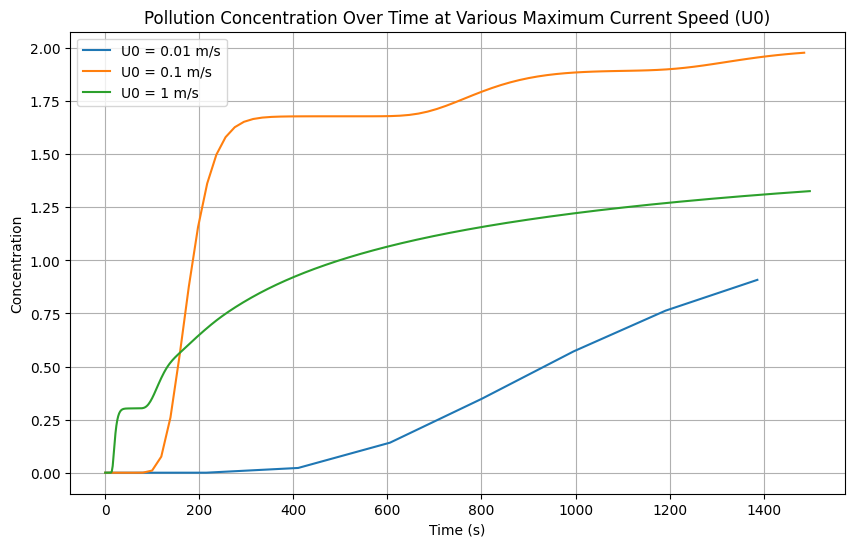

In [11]:
# Target coordinates
target_x = 20  # Example x coordinates in meters
target_y = 2   # Example y coordinates in meters
# Find the nearest indices
x_indices = (np.abs(x - target_x)).argmin()  # Nearest x index from simulation grid
y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

# Prepare to plot for varying U0
plt.figure(figsize=(10, 6))
U_list = [0.01,0.1,1]
for U_i in U_list:
    c_concentration, t_sim_save = simulate_pollution(U0=U_i, kappa=1e-2)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'U0 = {U_i} m/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Maximum Current Speed (U0)')
plt.legend()
plt.grid()
plt.show()

At the very beginning, the initial rises in concentrations (from $t=0$ to $t=150$) can be observed more quickly as the corresponding $U_0$ increases. This is because the higher the maximum speed $U_0$, the more quickly the pollutant can be driven from $x=10$ to $x=20$.

However, after the concentrations start to increase, the lower the $U_0$, the higher the measured concentration value at $x=20$, $y=2$. This is because the higher the $U_0$, the quicker will the pollutant be washed away further downstream, avoiding accumulation at $x=20$, $y=2$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2025-11-12 13:29:54,887 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:__main__:Starting main loop


2025-11-12 13:29:54,892 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 13:29:54,946 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 13:29:54,992 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 13:29:55,035 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 13:29:55,080 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 13:29:55,123 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 13:29:55,164 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 13:29:55,203 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 13:29:55,244 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 13:29:55,290 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 13:29:55,334 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 13:29:55,386 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 13:29:55,437 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 13:29:55,483 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 13:29:55,527 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 13:29:55,577 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 13:29:55,620 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 13:29:55,664 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 13:29:55,709 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 13:29:55,756 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 13:29:55,799 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 13:29:55,845 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 13:29:55,882 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 13:29:55,919 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 13:29:55,947 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 13:29:55,975 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 13:29:56,005 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 13:29:56,034 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 13:29:56,063 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 13:29:56,091 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 13:29:56,119 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 13:29:56,149 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 13:29:56,183 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 13:29:56,213 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 13:29:56,242 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 13:29:56,277 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 13:29:56,307 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 13:29:56,338 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 13:29:56,368 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 13:29:56,397 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 13:29:56,427 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 13:29:56,458 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 13:29:56,488 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 13:29:56,516 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 13:29:56,547 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 13:29:56,577 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 13:29:56,606 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 13:29:56,635 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 13:29:56,665 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 13:29:56,697 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 13:29:56,727 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 13:29:56,757 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 13:29:56,786 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 13:29:56,817 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 13:29:56,847 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 13:29:56,876 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 13:29:56,909 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 13:29:56,952 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 13:29:56,981 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 13:29:57,011 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 13:29:57,041 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 13:29:57,076 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 13:29:57,108 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 13:29:57,138 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 13:29:57,168 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 13:29:57,198 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 13:29:57,229 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 13:29:57,259 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 13:29:57,291 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 13:29:57,329 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 13:29:57,362 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 13:29:57,392 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 13:29:57,424 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 13:29:57,456 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 13:29:57,486 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 13:29:57,515 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 13:29:57,543 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 13:29:57,577 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 13:29:57,602 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 13:29:57,605 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 13:29:57,606 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.4823 sec


2025-11-12 13:29:57,608 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4823 sec


INFO:solvers:Warmup time (iter 0-10): 0.09284 sec


2025-11-12 13:29:57,609 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.09284 sec


INFO:solvers:Run time (iter 10-end): 2.617 sec


2025-11-12 13:29:57,611 solvers 0/1 INFO :: Run time (iter 10-end): 2.617 sec


INFO:solvers:CPU time (iter 10-end): 0.000727 cpu-hr


2025-11-12 13:29:57,613 solvers 0/1 INFO :: CPU time (iter 10-end): 0.000727 cpu-hr


INFO:solvers:Speed: 5.022e+06 mode-stages/cpu-sec


2025-11-12 13:29:57,614 solvers 0/1 INFO :: Speed: 5.022e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2025-11-12 13:29:57,890 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


INFO:__main__:Starting main loop


2025-11-12 13:29:57,895 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 13:29:57,934 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 13:29:57,978 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 13:29:58,009 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 13:29:58,038 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 13:29:58,068 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 13:29:58,103 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 13:29:58,134 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 13:29:58,165 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 13:29:58,203 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 13:29:58,235 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 13:29:58,265 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 13:29:58,299 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 13:29:58,329 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 13:29:58,358 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 13:29:58,389 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 13:29:58,418 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 13:29:58,449 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 13:29:58,478 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 13:29:58,509 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 13:29:58,539 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 13:29:58,571 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 13:29:58,600 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 13:29:58,629 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 13:29:58,660 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 13:29:58,691 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 13:29:58,722 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 13:29:58,753 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 13:29:58,787 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 13:29:58,818 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 13:29:58,848 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 13:29:58,878 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 13:29:58,908 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 13:29:58,937 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 13:29:58,966 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 13:29:59,009 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 13:29:59,043 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 13:29:59,073 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 13:29:59,103 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 13:29:59,132 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 13:29:59,161 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 13:29:59,193 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 13:29:59,224 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 13:29:59,261 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 13:29:59,295 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 13:29:59,326 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 13:29:59,356 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 13:29:59,388 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 13:29:59,429 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 13:29:59,458 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 13:29:59,498 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 13:29:59,539 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 13:29:59,578 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 13:29:59,609 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 13:29:59,642 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 13:29:59,672 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 13:29:59,702 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 13:29:59,734 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 13:29:59,763 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 13:29:59,795 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 13:29:59,826 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 13:29:59,857 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 13:29:59,887 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 13:29:59,917 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 13:29:59,950 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 13:29:59,980 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 13:30:00,011 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 13:30:00,052 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 13:30:00,099 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 13:30:00,132 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 13:30:00,165 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 13:30:00,197 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 13:30:00,229 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 13:30:00,260 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 13:30:00,293 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 13:30:00,324 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 13:30:00,359 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 13:30:00,389 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 13:30:00,412 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 13:30:00,416 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 13:30:00,418 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2357 sec


2025-11-12 13:30:00,422 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2357 sec


INFO:solvers:Warmup time (iter 0-10): 0.07548 sec


2025-11-12 13:30:00,427 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.07548 sec


INFO:solvers:Run time (iter 10-end): 2.441 sec


2025-11-12 13:30:00,431 solvers 0/1 INFO :: Run time (iter 10-end): 2.441 sec


INFO:solvers:CPU time (iter 10-end): 0.0006782 cpu-hr


2025-11-12 13:30:00,434 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006782 cpu-hr


INFO:solvers:Speed: 5.384e+06 mode-stages/cpu-sec


2025-11-12 13:30:00,437 solvers 0/1 INFO :: Speed: 5.384e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


2025-11-12 13:30:00,707 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.0e+00/s


INFO:__main__:Starting main loop


2025-11-12 13:30:00,712 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 13:30:00,754 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 13:30:00,784 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 13:30:00,816 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 13:30:00,849 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 13:30:00,879 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 13:30:00,911 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 13:30:00,943 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 13:30:00,978 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 13:30:01,010 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 13:30:01,041 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 13:30:01,071 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 13:30:01,111 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 13:30:01,148 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 13:30:01,178 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 13:30:01,208 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 13:30:01,239 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 13:30:01,274 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 13:30:01,310 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 13:30:01,344 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 13:30:01,381 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 13:30:01,416 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 13:30:01,446 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 13:30:01,479 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 13:30:01,511 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 13:30:01,544 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 13:30:01,579 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 13:30:01,611 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 13:30:01,641 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 13:30:01,673 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 13:30:01,708 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 13:30:01,741 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 13:30:01,779 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 13:30:01,812 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 13:30:01,844 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 13:30:01,876 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 13:30:01,908 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 13:30:01,941 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 13:30:01,972 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 13:30:02,002 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 13:30:02,034 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 13:30:02,069 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 13:30:02,103 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 13:30:02,142 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 13:30:02,187 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 13:30:02,217 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 13:30:02,248 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 13:30:02,279 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 13:30:02,312 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 13:30:02,345 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 13:30:02,375 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 13:30:02,407 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 13:30:02,439 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 13:30:02,473 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 13:30:02,505 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 13:30:02,539 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 13:30:02,570 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 13:30:02,605 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 13:30:02,638 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 13:30:02,669 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 13:30:02,701 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 13:30:02,733 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 13:30:02,763 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 13:30:02,800 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 13:30:02,833 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 13:30:02,868 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 13:30:02,900 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 13:30:02,933 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 13:30:02,963 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 13:30:02,994 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 13:30:03,027 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 13:30:03,060 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 13:30:03,092 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 13:30:03,136 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 13:30:03,168 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 13:30:03,212 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 13:30:03,247 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 13:30:03,277 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 13:30:03,303 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 13:30:03,305 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 13:30:03,306 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2354 sec


2025-11-12 13:30:03,308 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2354 sec


INFO:solvers:Warmup time (iter 0-10): 0.06734 sec


2025-11-12 13:30:03,310 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06734 sec


INFO:solvers:Run time (iter 10-end): 2.523 sec


2025-11-12 13:30:03,311 solvers 0/1 INFO :: Run time (iter 10-end): 2.523 sec


INFO:solvers:CPU time (iter 10-end): 0.0007007 cpu-hr


2025-11-12 13:30:03,312 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0007007 cpu-hr


INFO:solvers:Speed: 5.21e+06 mode-stages/cpu-sec


2025-11-12 13:30:03,313 solvers 0/1 INFO :: Speed: 5.21e+06 mode-stages/cpu-sec


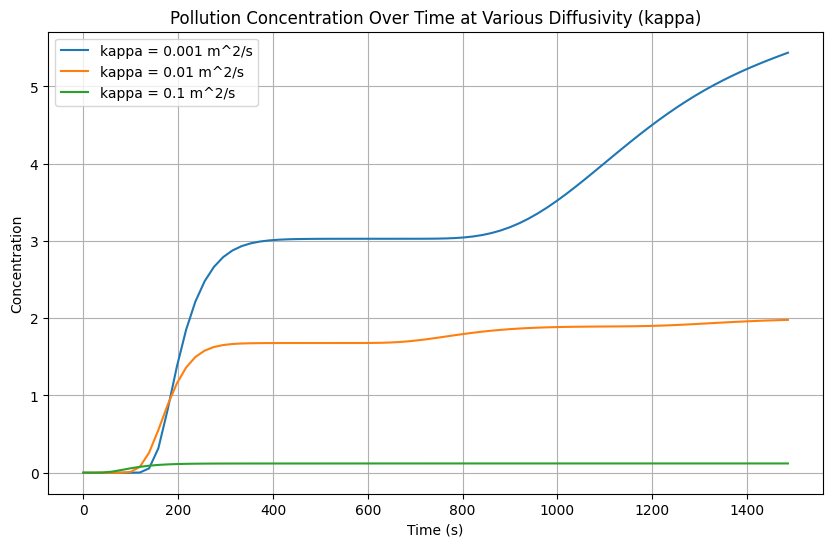

In [12]:
# Prepare to plot for varying kappa
plt.figure(figsize=(10, 6))
kappa_list = [1e-3, 1e-2, 1e-1] # Varying diffusivity values
for kappa_i in kappa_list:
    c_concentration, t_sim_save = simulate_pollution(U0=0.1, kappa=kappa_i)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'kappa = {kappa_i} m^2/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Diffusivity (kappa)')
plt.legend()
plt.grid()
plt.show()

At the very beginning, the initial rises in concentrations (from $t=0$ to $t=160$) can be observed more quickly as the corresponding $\kappa$ increases. This is because the higher the diffusivity $\kappa$, the more quickly the pollutant spreads from $x=10$ to $x=20$.

However, after the concentrations start to increase, the lower the value of $\kappa$, the higher the measured concentration value at $x=20$, $y=2$. This is because the higher the value of $\kappa$, the more uniformly the pollutant spreads to other points in the river, avoiding accumulation at $x=20$, $y=2$.

ADD DISCUSSION HERE

 Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

 $time\ needed\ to\ reach\ opposite\ side\ t \sim \frac{h^2}{D} \sim 10^4 s$

 $downstream\ distance\ x \sim U_0 \frac{h^2}{D} \sim 10^3m$

In [13]:
import numpy as np
time_opp_side = np.square(10)/(1e-2)
print("time needed to reach opposite side ~",time_opp_side, "s")
downstream_distance = 0.1*np.square(10)/(1e-2)
print("downstream distance~",downstream_distance,"m")

time needed to reach opposite side ~ 10000.0 s
downstream distance~ 1000.0 m


### Turbulent diffusion
In a turbulent flow, tracers will be transported by the turbulent eddies. A common way to model this is to introduce a turbulent diffusivity, $\kappa_T\sim u*l$, where $u$ and $l$ are characteristic velocity and length scales associated with the turbulent eddies.

To explore this effect, create a Dedalus script that includes advection by $u$ and $v$ (the $x$ and $y$ components of the velocity). Then, use the same velocity field as above for $u$ and add to that a fluctuating velocity field that of the form

$$ u=u_0 cos(kx)cos(ky), \quad v=u_0 sin(kx)sin(ky) $$

where $k$ is the wavenumber associated with the velocity fluctuations and $u_0$ is the amplitude of the fluctuations. Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion.

In [14]:
def simulate_turbulent_pollution(u0, k):
    import numpy as np
    import matplotlib.pyplot as plt
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)


  # Set parameters
    U0 = 0.1 # maximum current speed in m/s
    w = 10 # width of the river in m
    L = 50 # length of the river section to simulate
    kappa = 1e-2 # diffusivity in m^2/s
    S0 = 1 # amplitude of the pollution source term
    S_w = 1 # width of the source term in m
    S_x = 10 # center of the forcing in x
    S_y = 0 # center of the forcing in y
    S_t = 1 # forcing timescale

    # Numerical parameters
    Nx = 256 # number of gridoints in x
    Ny = 32 # number of gridpoints in y
    stop_sim_time=1500 # end time in seconds
    timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

    import numpy as np
    import dedalus.public as dedalus
    import logging
    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

    # Fields
    c = dist.Field(name='c', bases=(xbasis,ybasis))
    u = dist.Field(name='u', bases=(xbasis,ybasis))
    v = dist.Field(name='v', bases=(xbasis,ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0)+ u0*np.cos(k*x)*np.cos(k*y) # parabolic velocity profile
    v['g'] = u0*np.sin(k*x)*np.sin(k*y) # parabolic velocity profile
    # kappa_t = u*l

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey*lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])
    dy = lambda A: dedalus.Differentiate(A, coords['y'])

    S = dist.Field(name='u', bases=(xbasis,ybasis))
    S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    #problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("dt(c) + dx(u*c) + dy(v*c) +lift(tau_2) - kappa*div(grad_c) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])];

    t_save = [solver.sim_time]; # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration-1) % 10 == 0:
                logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    return c_save, np.array(t_save)

Note that $k$ should be set to give an integer number of wavelengths in the $x$ and $y$ directions. Vary both $u_0$ and $k$ and study how quicky the tracer is transported across the river. Qualitatively compare this with the expectation based on the hypothesis of turbulent diffusion. Note that:

$\lambda = \frac{2\pi}{k}$

$k = \frac{2\pi}{\lambda}$

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 11s, Remaining: 0s, Rate: 8.8e-02/s


2025-11-12 14:01:35,509 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 11s, Remaining: 0s, Rate: 8.8e-02/s


INFO:__main__:Starting main loop


2025-11-12 14:01:35,515 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 14:03:35,796 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 14:03:38,815 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 14:03:42,129 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 14:03:44,672 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 14:03:47,157 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 14:03:49,816 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 14:03:52,224 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 14:03:54,692 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 14:03:57,305 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 14:03:59,703 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 14:04:02,312 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 14:04:04,760 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 14:04:07,669 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 14:04:10,529 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 14:04:12,815 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 14:04:15,303 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 14:04:18,349 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 14:04:20,951 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 14:04:23,359 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 14:04:26,008 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 14:04:28,638 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 14:04:31,227 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 14:04:33,665 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 14:04:35,970 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 14:04:38,516 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 14:04:40,970 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 14:04:43,587 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 14:04:46,538 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 14:04:48,819 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 14:04:51,177 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 14:04:53,651 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 14:04:56,335 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 14:04:58,939 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 14:05:01,365 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 14:05:03,945 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 14:05:06,519 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 14:05:08,947 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 14:05:12,007 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 14:05:14,429 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 14:05:16,918 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 14:05:19,203 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 14:05:21,557 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 14:05:24,120 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 14:05:26,505 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 14:05:28,961 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 14:05:31,243 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 14:05:33,537 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 14:05:36,109 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 14:05:38,422 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 14:05:40,697 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 14:05:42,978 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 14:05:45,275 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 14:05:47,684 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 14:05:50,144 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 14:05:52,426 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 14:05:54,713 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 14:05:57,001 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 14:05:59,303 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 14:06:02,299 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 14:06:04,595 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 14:06:06,884 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 14:06:09,168 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 14:06:11,447 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 14:06:13,887 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 14:06:16,262 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 14:06:18,537 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 14:06:20,827 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 14:06:23,107 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 14:06:25,476 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 14:06:27,982 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 14:06:30,289 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 14:06:32,567 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 14:06:34,864 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 14:06:37,154 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 14:06:39,693 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 14:06:42,060 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 14:06:44,359 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 14:06:45,972 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 14:06:45,976 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 14:06:45,977 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 11.43 sec


2025-11-12 14:06:45,978 solvers 0/1 INFO :: Setup time (init - iter 0): 11.43 sec


INFO:solvers:Warmup time (iter 0-10): 122.6 sec


2025-11-12 14:06:45,981 solvers 0/1 INFO :: Warmup time (iter 0-10): 122.6 sec


INFO:solvers:Run time (iter 10-end): 187.8 sec


2025-11-12 14:06:45,982 solvers 0/1 INFO :: Run time (iter 10-end): 187.8 sec


INFO:solvers:CPU time (iter 10-end): 0.05218 cpu-hr


2025-11-12 14:06:45,983 solvers 0/1 INFO :: CPU time (iter 10-end): 0.05218 cpu-hr


INFO:solvers:Speed: 6.997e+04 mode-stages/cpu-sec


2025-11-12 14:06:45,984 solvers 0/1 INFO :: Speed: 6.997e+04 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 3.5e-01/s


2025-11-12 14:06:48,962 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 3.5e-01/s


INFO:__main__:Starting main loop


2025-11-12 14:06:48,968 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 14:07:53,822 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 14:07:54,933 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 14:07:56,069 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 14:07:57,235 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 14:07:58,270 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 14:07:59,303 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 14:08:00,333 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 14:08:01,365 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 14:08:02,396 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 14:08:03,431 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 14:08:04,476 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 14:08:05,519 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 14:08:06,554 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 14:08:07,658 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 14:08:08,806 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 14:08:09,981 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 14:08:11,011 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 14:08:12,041 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 14:08:13,070 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 14:08:14,098 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 14:08:15,129 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 14:08:16,161 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 14:08:17,199 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 14:08:18,238 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 14:08:19,277 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 14:08:20,386 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 14:08:21,524 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 14:08:22,690 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 14:08:23,723 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 14:08:24,763 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 14:08:25,790 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 14:08:26,820 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 14:08:27,874 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 14:08:28,930 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 14:08:29,970 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 14:08:31,006 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 14:08:32,039 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 14:08:33,153 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 14:08:34,298 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 14:08:35,494 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 14:08:36,528 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 14:08:37,569 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 14:08:38,608 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 14:08:39,667 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 14:08:40,701 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 14:08:41,730 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 14:08:42,764 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 14:08:43,798 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 14:08:44,832 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 14:08:45,943 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 14:08:47,078 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 14:08:48,234 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 14:08:49,262 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 14:08:50,292 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 14:08:51,324 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 14:08:52,368 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 14:08:53,406 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 14:08:54,444 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 14:08:55,477 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 14:08:56,505 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 14:08:57,535 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 14:08:58,648 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 14:08:59,796 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 14:09:00,953 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 14:09:01,987 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 14:09:03,018 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 14:09:04,054 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 14:09:05,102 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 14:09:06,131 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 14:09:07,169 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 14:09:08,202 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 14:09:09,232 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 14:09:10,268 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 14:09:11,404 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 14:09:12,567 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 14:09:13,692 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 14:09:14,724 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 14:09:15,452 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 14:09:15,454 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 14:09:15,458 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 2.93 sec


2025-11-12 14:09:15,462 solvers 0/1 INFO :: Setup time (init - iter 0): 2.93 sec


INFO:solvers:Warmup time (iter 0-10): 65.84 sec


2025-11-12 14:09:15,467 solvers 0/1 INFO :: Warmup time (iter 0-10): 65.84 sec


INFO:solvers:Run time (iter 10-end): 80.64 sec


2025-11-12 14:09:15,470 solvers 0/1 INFO :: Run time (iter 10-end): 80.64 sec


INFO:solvers:CPU time (iter 10-end): 0.0224 cpu-hr


2025-11-12 14:09:15,474 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0224 cpu-hr


INFO:solvers:Speed: 1.63e+05 mode-stages/cpu-sec


2025-11-12 14:09:15,476 solvers 0/1 INFO :: Speed: 1.63e+05 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 6s, Remaining: 0s, Rate: 1.7e-01/s


2025-11-12 14:09:21,414 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 6s, Remaining: 0s, Rate: 1.7e-01/s


INFO:__main__:Starting main loop


2025-11-12 14:09:21,422 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 14:10:47,655 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 14:10:49,639 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 14:10:51,610 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 14:10:53,598 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 14:10:56,908 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 14:10:59,573 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 14:11:01,544 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 14:11:03,527 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 14:11:05,511 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 14:11:07,516 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 14:11:09,738 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 14:11:11,769 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 14:11:13,745 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 14:11:15,724 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 14:11:17,694 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 14:11:19,664 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 14:11:21,808 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 14:11:23,906 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 14:11:25,871 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 14:11:27,847 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 14:11:29,818 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 14:11:31,790 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 14:11:33,896 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 14:11:36,091 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 14:11:38,067 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 14:11:40,037 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 14:11:42,009 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 14:11:43,977 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 14:11:45,997 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 14:11:48,218 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 14:11:50,243 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 14:11:52,545 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 14:11:55,196 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 14:11:57,485 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 14:12:00,865 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 14:12:03,426 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 14:12:05,757 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 14:12:07,725 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 14:12:09,699 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 14:12:11,694 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 14:12:13,873 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 14:12:15,890 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 14:12:17,982 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 14:12:20,254 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 14:12:22,643 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 14:12:24,905 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 14:12:27,736 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 14:12:29,783 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 14:12:31,818 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 14:12:34,088 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 14:12:36,315 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 14:12:38,633 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 14:12:40,962 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 14:12:43,176 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 14:12:45,233 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 14:12:47,207 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 14:12:49,227 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 14:12:51,454 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 14:12:53,786 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 14:12:55,866 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 14:12:58,107 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 14:13:00,310 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 14:13:02,321 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 14:13:04,484 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 14:13:06,634 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 14:13:08,598 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 14:13:10,566 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 14:13:12,530 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 14:13:14,494 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 14:13:16,552 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 14:13:18,715 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 14:13:20,679 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 14:13:22,641 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 14:13:24,606 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 14:13:26,566 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 14:13:28,545 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 14:13:30,708 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 14:13:32,136 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 14:13:32,139 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 14:13:32,141 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 5.866 sec


2025-11-12 14:13:32,144 solvers 0/1 INFO :: Setup time (init - iter 0): 5.866 sec


INFO:solvers:Warmup time (iter 0-10): 88.02 sec


2025-11-12 14:13:32,148 solvers 0/1 INFO :: Warmup time (iter 0-10): 88.02 sec


INFO:solvers:Run time (iter 10-end): 162.7 sec


2025-11-12 14:13:32,153 solvers 0/1 INFO :: Run time (iter 10-end): 162.7 sec


INFO:solvers:CPU time (iter 10-end): 0.04519 cpu-hr


2025-11-12 14:13:32,158 solvers 0/1 INFO :: CPU time (iter 10-end): 0.04519 cpu-hr


INFO:solvers:Speed: 8.079e+04 mode-stages/cpu-sec


2025-11-12 14:13:32,160 solvers 0/1 INFO :: Speed: 8.079e+04 mode-stages/cpu-sec


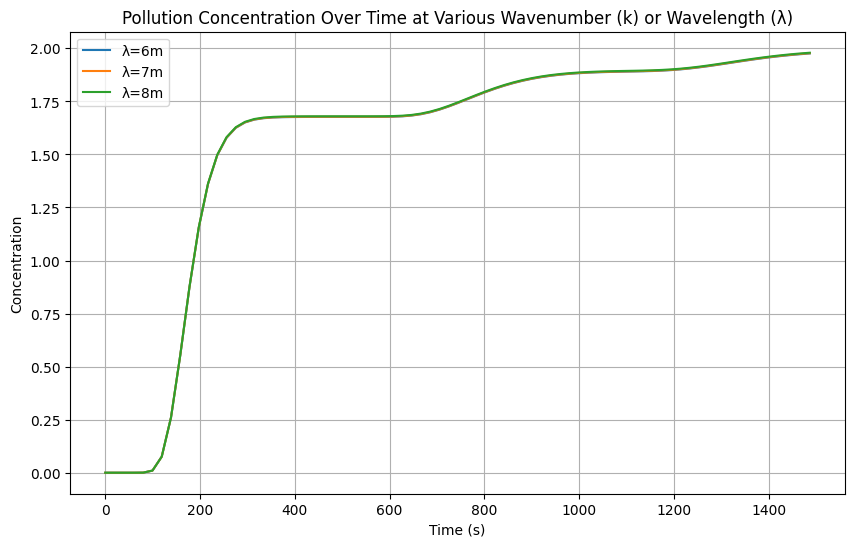

In [17]:
# Target coordinates
target_x = 20  # Example x coordinates in meters
target_y = 2   # Example y coordinates in meters
# Find the nearest indices
x_indices = (np.abs(x - target_x)).argmin()  # Nearest x index from simulation grid
y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid
plotted_lines = []

# Prepare to plot for varying U0
plt.figure(figsize=(10, 6))
k_list = [1.04719551,0.897597901,0.785398163] #lambda = 6,7,8
lambda_list = [6,7,8]

for k_i in k_list:
    c_concentration, t_sim_save = simulate_turbulent_pollution(u0=0.0001, k=k_i)
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'λ={lambda_list[k_list.index(k_i)]}m')

plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Wavenumber (k) or Wavelength (λ)')
plt.legend()
plt.grid()
plt.show()

As $\lambda$ increases (ie. $k$ decreases), the tracer is transported slightly more slowly across the river (seen when the graph is enlarged).This is because longer wavelengths result in larger eddies that may not have as vigorous transport capabilities as smaller-scale fluctuations.

In turbulent conditions, the tracer is transported more quickly compared to laminar flow conditions. This is because the chaotic nature of turbulent eddies allows for enhanced mixing and faster dispersion of the tracer across the flow.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


2025-11-12 14:13:33,063 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s


INFO:__main__:Starting main loop


2025-11-12 14:13:33,068 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 14:13:38,604 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 14:13:38,982 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 14:13:39,355 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 14:13:39,732 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 14:13:40,104 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 14:13:40,475 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 14:13:40,845 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 14:13:41,232 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 14:13:41,662 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 14:13:42,085 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 14:13:42,507 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 14:13:42,944 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 14:13:43,387 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 14:13:43,829 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 14:13:44,211 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 14:13:44,577 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 14:13:44,948 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 14:13:45,314 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 14:13:45,683 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 14:13:46,051 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 14:13:46,424 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 14:13:46,793 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 14:13:47,179 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 14:13:47,549 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 14:13:47,929 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 14:13:48,306 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 14:13:48,676 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 14:13:49,048 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 14:13:49,431 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 14:13:49,802 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 14:13:50,183 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 14:13:50,554 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 14:13:50,927 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 14:13:51,297 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 14:13:51,666 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 14:13:52,034 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 14:13:52,411 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 14:13:52,775 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 14:13:53,143 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 14:13:53,520 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 14:13:53,921 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 14:13:54,367 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 14:13:54,788 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 14:13:55,207 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 14:13:55,646 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 14:13:56,084 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 14:13:56,504 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 14:13:56,873 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 14:13:57,237 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 14:13:57,614 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 14:13:57,991 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 14:13:58,361 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 14:13:58,732 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 14:13:59,097 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 14:13:59,470 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 14:13:59,842 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 14:14:00,212 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 14:14:00,575 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 14:14:00,949 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 14:14:01,312 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 14:14:01,689 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 14:14:02,054 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 14:14:02,422 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 14:14:02,795 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 14:14:03,162 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 14:14:03,526 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 14:14:03,898 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 14:14:04,262 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 14:14:04,630 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 14:14:05,002 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 14:14:05,374 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 14:14:05,750 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 14:14:06,182 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 14:14:06,929 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 14:14:07,345 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 14:14:07,769 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 14:14:08,197 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 14:14:08,515 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 14:14:08,517 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 14:14:08,518 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.543 sec


2025-11-12 14:14:08,519 solvers 0/1 INFO :: Setup time (init - iter 0): 0.543 sec


INFO:solvers:Warmup time (iter 0-10): 5.876 sec


2025-11-12 14:14:08,521 solvers 0/1 INFO :: Warmup time (iter 0-10): 5.876 sec


INFO:solvers:Run time (iter 10-end): 29.57 sec


2025-11-12 14:14:08,522 solvers 0/1 INFO :: Run time (iter 10-end): 29.57 sec


INFO:solvers:CPU time (iter 10-end): 0.008214 cpu-hr


2025-11-12 14:14:08,523 solvers 0/1 INFO :: CPU time (iter 10-end): 0.008214 cpu-hr


INFO:solvers:Speed: 4.445e+05 mode-stages/cpu-sec


2025-11-12 14:14:08,524 solvers 0/1 INFO :: Speed: 4.445e+05 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 2.6e-01/s


2025-11-12 14:14:12,476 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 4s, Remaining: 0s, Rate: 2.6e-01/s


INFO:__main__:Starting main loop


2025-11-12 14:14:12,482 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 14:15:26,179 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 14:15:27,422 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 14:15:28,506 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 14:15:29,583 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 14:15:30,657 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 14:15:31,726 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 14:15:32,801 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 14:15:33,879 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 14:15:34,951 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 14:15:36,031 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 14:15:37,105 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 14:15:38,307 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 14:15:39,539 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 14:15:40,686 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 14:15:41,755 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 14:15:42,820 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 14:15:43,893 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 14:15:44,962 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 14:15:46,033 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 14:15:47,101 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 14:15:48,173 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 14:15:49,240 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 14:15:50,389 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 14:15:51,571 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 14:15:52,816 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 14:15:53,891 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 14:15:54,962 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 14:15:56,037 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 14:15:57,112 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 14:15:58,207 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 14:15:59,286 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 14:16:00,364 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 14:16:01,434 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 14:16:02,508 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 14:16:03,739 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 14:16:04,978 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 14:16:06,100 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 14:16:07,170 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 14:16:08,243 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 14:16:09,317 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 14:16:10,392 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 14:16:11,461 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 14:16:12,762 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 14:16:13,833 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 14:16:14,898 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 14:16:16,079 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 14:16:17,283 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 14:16:18,436 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 14:16:19,507 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 14:16:20,573 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 14:16:21,644 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 14:16:22,712 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 14:16:23,783 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 14:16:24,858 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 14:16:25,926 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 14:16:26,992 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 14:16:28,109 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 14:16:29,310 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 14:16:30,551 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 14:16:31,629 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 14:16:32,719 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 14:16:33,798 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 14:16:34,868 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 14:16:35,942 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 14:16:37,036 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 14:16:38,116 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 14:16:39,192 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 14:16:40,267 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 14:16:41,458 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 14:16:44,352 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 14:16:45,436 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 14:16:46,543 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 14:16:47,628 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 14:16:48,701 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 14:16:49,772 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 14:16:50,838 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 14:16:51,905 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 14:16:52,653 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 14:16:52,655 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 14:16:52,657 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 3.897 sec


2025-11-12 14:16:52,660 solvers 0/1 INFO :: Setup time (init - iter 0): 3.897 sec


INFO:solvers:Warmup time (iter 0-10): 74.83 sec


2025-11-12 14:16:52,663 solvers 0/1 INFO :: Warmup time (iter 0-10): 74.83 sec


INFO:solvers:Run time (iter 10-end): 85.34 sec


2025-11-12 14:16:52,670 solvers 0/1 INFO :: Run time (iter 10-end): 85.34 sec


INFO:solvers:CPU time (iter 10-end): 0.02371 cpu-hr


2025-11-12 14:16:52,672 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02371 cpu-hr


INFO:solvers:Speed: 1.54e+05 mode-stages/cpu-sec


2025-11-12 14:16:52,676 solvers 0/1 INFO :: Speed: 1.54e+05 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1m 23s, Remaining: 0s, Rate: 1.2e-02/s


2025-11-12 14:18:15,752 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1m 23s, Remaining: 0s, Rate: 1.2e-02/s


INFO:__main__:Starting main loop


2025-11-12 14:18:15,757 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=1.953125e+00, dt=1.953125e+00


2025-11-12 14:20:49,835 __main__ 0/1 INFO :: Iteration=1, Time=1.953125e+00, dt=1.953125e+00


INFO:__main__:Iteration=11, Time=2.148438e+01, dt=1.953125e+00


2025-11-12 14:20:52,899 __main__ 0/1 INFO :: Iteration=11, Time=2.148438e+01, dt=1.953125e+00


INFO:__main__:Iteration=21, Time=4.101562e+01, dt=1.953125e+00


2025-11-12 14:20:56,007 __main__ 0/1 INFO :: Iteration=21, Time=4.101562e+01, dt=1.953125e+00


INFO:__main__:Iteration=31, Time=6.054688e+01, dt=1.953125e+00


2025-11-12 14:20:59,391 __main__ 0/1 INFO :: Iteration=31, Time=6.054688e+01, dt=1.953125e+00


INFO:__main__:Iteration=41, Time=8.007812e+01, dt=1.953125e+00


2025-11-12 14:21:03,872 __main__ 0/1 INFO :: Iteration=41, Time=8.007812e+01, dt=1.953125e+00


INFO:__main__:Iteration=51, Time=9.960938e+01, dt=1.953125e+00


2025-11-12 14:21:07,077 __main__ 0/1 INFO :: Iteration=51, Time=9.960938e+01, dt=1.953125e+00


INFO:__main__:Iteration=61, Time=1.191406e+02, dt=1.953125e+00


2025-11-12 14:21:10,000 __main__ 0/1 INFO :: Iteration=61, Time=1.191406e+02, dt=1.953125e+00


INFO:__main__:Iteration=71, Time=1.386719e+02, dt=1.953125e+00


2025-11-12 14:21:12,899 __main__ 0/1 INFO :: Iteration=71, Time=1.386719e+02, dt=1.953125e+00


INFO:__main__:Iteration=81, Time=1.582031e+02, dt=1.953125e+00


2025-11-12 14:21:16,010 __main__ 0/1 INFO :: Iteration=81, Time=1.582031e+02, dt=1.953125e+00


INFO:__main__:Iteration=91, Time=1.777344e+02, dt=1.953125e+00


2025-11-12 14:21:19,262 __main__ 0/1 INFO :: Iteration=91, Time=1.777344e+02, dt=1.953125e+00


INFO:__main__:Iteration=101, Time=1.972656e+02, dt=1.953125e+00


2025-11-12 14:21:22,632 __main__ 0/1 INFO :: Iteration=101, Time=1.972656e+02, dt=1.953125e+00


INFO:__main__:Iteration=111, Time=2.167969e+02, dt=1.953125e+00


2025-11-12 14:21:26,484 __main__ 0/1 INFO :: Iteration=111, Time=2.167969e+02, dt=1.953125e+00


INFO:__main__:Iteration=121, Time=2.363281e+02, dt=1.953125e+00


2025-11-12 14:21:30,776 __main__ 0/1 INFO :: Iteration=121, Time=2.363281e+02, dt=1.953125e+00


INFO:__main__:Iteration=131, Time=2.558594e+02, dt=1.953125e+00


2025-11-12 14:21:34,253 __main__ 0/1 INFO :: Iteration=131, Time=2.558594e+02, dt=1.953125e+00


INFO:__main__:Iteration=141, Time=2.753906e+02, dt=1.953125e+00


2025-11-12 14:21:37,581 __main__ 0/1 INFO :: Iteration=141, Time=2.753906e+02, dt=1.953125e+00


INFO:__main__:Iteration=151, Time=2.949219e+02, dt=1.953125e+00


2025-11-12 14:21:42,259 __main__ 0/1 INFO :: Iteration=151, Time=2.949219e+02, dt=1.953125e+00


INFO:__main__:Iteration=161, Time=3.144531e+02, dt=1.953125e+00


2025-11-12 14:21:45,579 __main__ 0/1 INFO :: Iteration=161, Time=3.144531e+02, dt=1.953125e+00


INFO:__main__:Iteration=171, Time=3.339844e+02, dt=1.953125e+00


2025-11-12 14:21:48,508 __main__ 0/1 INFO :: Iteration=171, Time=3.339844e+02, dt=1.953125e+00


INFO:__main__:Iteration=181, Time=3.535156e+02, dt=1.953125e+00


2025-11-12 14:21:51,445 __main__ 0/1 INFO :: Iteration=181, Time=3.535156e+02, dt=1.953125e+00


INFO:__main__:Iteration=191, Time=3.730469e+02, dt=1.953125e+00


2025-11-12 14:21:54,513 __main__ 0/1 INFO :: Iteration=191, Time=3.730469e+02, dt=1.953125e+00


INFO:__main__:Iteration=201, Time=3.925781e+02, dt=1.953125e+00


2025-11-12 14:21:57,975 __main__ 0/1 INFO :: Iteration=201, Time=3.925781e+02, dt=1.953125e+00


INFO:__main__:Iteration=211, Time=4.121094e+02, dt=1.953125e+00


2025-11-12 14:22:01,087 __main__ 0/1 INFO :: Iteration=211, Time=4.121094e+02, dt=1.953125e+00


INFO:__main__:Iteration=221, Time=4.316406e+02, dt=1.953125e+00


2025-11-12 14:22:04,214 __main__ 0/1 INFO :: Iteration=221, Time=4.316406e+02, dt=1.953125e+00


INFO:__main__:Iteration=231, Time=4.511719e+02, dt=1.953125e+00


2025-11-12 14:22:07,512 __main__ 0/1 INFO :: Iteration=231, Time=4.511719e+02, dt=1.953125e+00


INFO:__main__:Iteration=241, Time=4.707031e+02, dt=1.953125e+00


2025-11-12 14:22:10,835 __main__ 0/1 INFO :: Iteration=241, Time=4.707031e+02, dt=1.953125e+00


INFO:__main__:Iteration=251, Time=4.902344e+02, dt=1.953125e+00


2025-11-12 14:22:13,915 __main__ 0/1 INFO :: Iteration=251, Time=4.902344e+02, dt=1.953125e+00


INFO:__main__:Iteration=261, Time=5.097656e+02, dt=1.953125e+00


2025-11-12 14:22:17,020 __main__ 0/1 INFO :: Iteration=261, Time=5.097656e+02, dt=1.953125e+00


INFO:__main__:Iteration=271, Time=5.292969e+02, dt=1.953125e+00


2025-11-12 14:22:20,136 __main__ 0/1 INFO :: Iteration=271, Time=5.292969e+02, dt=1.953125e+00


INFO:__main__:Iteration=281, Time=5.488281e+02, dt=1.953125e+00


2025-11-12 14:22:23,199 __main__ 0/1 INFO :: Iteration=281, Time=5.488281e+02, dt=1.953125e+00


INFO:__main__:Iteration=291, Time=5.683594e+02, dt=1.953125e+00


2025-11-12 14:22:26,128 __main__ 0/1 INFO :: Iteration=291, Time=5.683594e+02, dt=1.953125e+00


INFO:__main__:Iteration=301, Time=5.878906e+02, dt=1.953125e+00


2025-11-12 14:22:29,079 __main__ 0/1 INFO :: Iteration=301, Time=5.878906e+02, dt=1.953125e+00


INFO:__main__:Iteration=311, Time=6.074219e+02, dt=1.953125e+00


2025-11-12 14:22:32,101 __main__ 0/1 INFO :: Iteration=311, Time=6.074219e+02, dt=1.953125e+00


INFO:__main__:Iteration=321, Time=6.269531e+02, dt=1.953125e+00


2025-11-12 14:22:35,235 __main__ 0/1 INFO :: Iteration=321, Time=6.269531e+02, dt=1.953125e+00


INFO:__main__:Iteration=331, Time=6.464844e+02, dt=1.953125e+00


2025-11-12 14:22:38,157 __main__ 0/1 INFO :: Iteration=331, Time=6.464844e+02, dt=1.953125e+00


INFO:__main__:Iteration=341, Time=6.660156e+02, dt=1.953125e+00


2025-11-12 14:22:41,073 __main__ 0/1 INFO :: Iteration=341, Time=6.660156e+02, dt=1.953125e+00


INFO:__main__:Iteration=351, Time=6.855469e+02, dt=1.953125e+00


2025-11-12 14:22:44,013 __main__ 0/1 INFO :: Iteration=351, Time=6.855469e+02, dt=1.953125e+00


INFO:__main__:Iteration=361, Time=7.050781e+02, dt=1.953125e+00


2025-11-12 14:22:47,204 __main__ 0/1 INFO :: Iteration=361, Time=7.050781e+02, dt=1.953125e+00


INFO:__main__:Iteration=371, Time=7.246094e+02, dt=1.953125e+00


2025-11-12 14:22:50,108 __main__ 0/1 INFO :: Iteration=371, Time=7.246094e+02, dt=1.953125e+00


INFO:__main__:Iteration=381, Time=7.441406e+02, dt=1.953125e+00


2025-11-12 14:22:53,030 __main__ 0/1 INFO :: Iteration=381, Time=7.441406e+02, dt=1.953125e+00


INFO:__main__:Iteration=391, Time=7.636719e+02, dt=1.953125e+00


2025-11-12 14:22:55,962 __main__ 0/1 INFO :: Iteration=391, Time=7.636719e+02, dt=1.953125e+00


INFO:__main__:Iteration=401, Time=7.832031e+02, dt=1.953125e+00


2025-11-12 14:22:59,178 __main__ 0/1 INFO :: Iteration=401, Time=7.832031e+02, dt=1.953125e+00


INFO:__main__:Iteration=411, Time=8.027344e+02, dt=1.953125e+00


2025-11-12 14:23:02,150 __main__ 0/1 INFO :: Iteration=411, Time=8.027344e+02, dt=1.953125e+00


INFO:__main__:Iteration=421, Time=8.222656e+02, dt=1.953125e+00


2025-11-12 14:23:05,329 __main__ 0/1 INFO :: Iteration=421, Time=8.222656e+02, dt=1.953125e+00


INFO:__main__:Iteration=431, Time=8.417969e+02, dt=1.953125e+00


2025-11-12 14:23:08,256 __main__ 0/1 INFO :: Iteration=431, Time=8.417969e+02, dt=1.953125e+00


INFO:__main__:Iteration=441, Time=8.613281e+02, dt=1.953125e+00


2025-11-12 14:23:11,416 __main__ 0/1 INFO :: Iteration=441, Time=8.613281e+02, dt=1.953125e+00


INFO:__main__:Iteration=451, Time=8.808594e+02, dt=1.953125e+00


2025-11-12 14:23:14,431 __main__ 0/1 INFO :: Iteration=451, Time=8.808594e+02, dt=1.953125e+00


INFO:__main__:Iteration=461, Time=9.003906e+02, dt=1.953125e+00


2025-11-12 14:23:17,344 __main__ 0/1 INFO :: Iteration=461, Time=9.003906e+02, dt=1.953125e+00


INFO:__main__:Iteration=471, Time=9.199219e+02, dt=1.953125e+00


2025-11-12 14:23:20,270 __main__ 0/1 INFO :: Iteration=471, Time=9.199219e+02, dt=1.953125e+00


INFO:__main__:Iteration=481, Time=9.394531e+02, dt=1.953125e+00


2025-11-12 14:23:23,310 __main__ 0/1 INFO :: Iteration=481, Time=9.394531e+02, dt=1.953125e+00


INFO:__main__:Iteration=491, Time=9.589844e+02, dt=1.953125e+00


2025-11-12 14:23:26,392 __main__ 0/1 INFO :: Iteration=491, Time=9.589844e+02, dt=1.953125e+00


INFO:__main__:Iteration=501, Time=9.785156e+02, dt=1.953125e+00


2025-11-12 14:23:29,317 __main__ 0/1 INFO :: Iteration=501, Time=9.785156e+02, dt=1.953125e+00


INFO:__main__:Iteration=511, Time=9.980469e+02, dt=1.953125e+00


2025-11-12 14:23:32,228 __main__ 0/1 INFO :: Iteration=511, Time=9.980469e+02, dt=1.953125e+00


INFO:__main__:Iteration=521, Time=1.017578e+03, dt=1.953125e+00


2025-11-12 14:23:35,232 __main__ 0/1 INFO :: Iteration=521, Time=1.017578e+03, dt=1.953125e+00


INFO:__main__:Iteration=531, Time=1.037109e+03, dt=1.953125e+00


2025-11-12 14:23:40,312 __main__ 0/1 INFO :: Iteration=531, Time=1.037109e+03, dt=1.953125e+00


INFO:__main__:Iteration=541, Time=1.056641e+03, dt=1.953125e+00


2025-11-12 14:23:45,304 __main__ 0/1 INFO :: Iteration=541, Time=1.056641e+03, dt=1.953125e+00


INFO:__main__:Iteration=551, Time=1.076172e+03, dt=1.953125e+00


2025-11-12 14:23:48,580 __main__ 0/1 INFO :: Iteration=551, Time=1.076172e+03, dt=1.953125e+00


INFO:__main__:Iteration=561, Time=1.095703e+03, dt=1.953125e+00


2025-11-12 14:23:51,779 __main__ 0/1 INFO :: Iteration=561, Time=1.095703e+03, dt=1.953125e+00


INFO:__main__:Iteration=571, Time=1.115234e+03, dt=1.953125e+00


2025-11-12 14:23:54,677 __main__ 0/1 INFO :: Iteration=571, Time=1.115234e+03, dt=1.953125e+00


INFO:__main__:Iteration=581, Time=1.134766e+03, dt=1.953125e+00


2025-11-12 14:23:57,593 __main__ 0/1 INFO :: Iteration=581, Time=1.134766e+03, dt=1.953125e+00


INFO:__main__:Iteration=591, Time=1.154297e+03, dt=1.953125e+00


2025-11-12 14:24:00,522 __main__ 0/1 INFO :: Iteration=591, Time=1.154297e+03, dt=1.953125e+00


INFO:__main__:Iteration=601, Time=1.173828e+03, dt=1.953125e+00


2025-11-12 14:24:03,833 __main__ 0/1 INFO :: Iteration=601, Time=1.173828e+03, dt=1.953125e+00


INFO:__main__:Iteration=611, Time=1.193359e+03, dt=1.953125e+00


2025-11-12 14:24:06,736 __main__ 0/1 INFO :: Iteration=611, Time=1.193359e+03, dt=1.953125e+00


INFO:__main__:Iteration=621, Time=1.212891e+03, dt=1.953125e+00


2025-11-12 14:24:09,649 __main__ 0/1 INFO :: Iteration=621, Time=1.212891e+03, dt=1.953125e+00


INFO:__main__:Iteration=631, Time=1.232422e+03, dt=1.953125e+00


2025-11-12 14:24:12,559 __main__ 0/1 INFO :: Iteration=631, Time=1.232422e+03, dt=1.953125e+00


INFO:__main__:Iteration=641, Time=1.251953e+03, dt=1.953125e+00


2025-11-12 14:24:17,765 __main__ 0/1 INFO :: Iteration=641, Time=1.251953e+03, dt=1.953125e+00


INFO:__main__:Iteration=651, Time=1.271484e+03, dt=1.953125e+00


2025-11-12 14:24:21,562 __main__ 0/1 INFO :: Iteration=651, Time=1.271484e+03, dt=1.953125e+00


INFO:__main__:Iteration=661, Time=1.291016e+03, dt=1.953125e+00


2025-11-12 14:24:24,688 __main__ 0/1 INFO :: Iteration=661, Time=1.291016e+03, dt=1.953125e+00


INFO:__main__:Iteration=671, Time=1.310547e+03, dt=1.953125e+00


2025-11-12 14:24:28,184 __main__ 0/1 INFO :: Iteration=671, Time=1.310547e+03, dt=1.953125e+00


INFO:__main__:Iteration=681, Time=1.330078e+03, dt=1.953125e+00


2025-11-12 14:24:32,125 __main__ 0/1 INFO :: Iteration=681, Time=1.330078e+03, dt=1.953125e+00


INFO:__main__:Iteration=691, Time=1.349609e+03, dt=1.953125e+00


2025-11-12 14:24:35,398 __main__ 0/1 INFO :: Iteration=691, Time=1.349609e+03, dt=1.953125e+00


INFO:__main__:Iteration=701, Time=1.369141e+03, dt=1.953125e+00


2025-11-12 14:24:38,382 __main__ 0/1 INFO :: Iteration=701, Time=1.369141e+03, dt=1.953125e+00


INFO:__main__:Iteration=711, Time=1.388672e+03, dt=1.953125e+00


2025-11-12 14:24:41,429 __main__ 0/1 INFO :: Iteration=711, Time=1.388672e+03, dt=1.953125e+00


INFO:__main__:Iteration=721, Time=1.408203e+03, dt=1.953125e+00


2025-11-12 14:24:44,543 __main__ 0/1 INFO :: Iteration=721, Time=1.408203e+03, dt=1.953125e+00


INFO:__main__:Iteration=731, Time=1.427734e+03, dt=1.953125e+00


2025-11-12 14:24:47,455 __main__ 0/1 INFO :: Iteration=731, Time=1.427734e+03, dt=1.953125e+00


INFO:__main__:Iteration=741, Time=1.447266e+03, dt=1.953125e+00


2025-11-12 14:24:50,362 __main__ 0/1 INFO :: Iteration=741, Time=1.447266e+03, dt=1.953125e+00


INFO:__main__:Iteration=751, Time=1.466797e+03, dt=1.953125e+00


2025-11-12 14:24:53,323 __main__ 0/1 INFO :: Iteration=751, Time=1.466797e+03, dt=1.953125e+00


INFO:__main__:Iteration=761, Time=1.486328e+03, dt=1.953125e+00


2025-11-12 14:24:56,507 __main__ 0/1 INFO :: Iteration=761, Time=1.486328e+03, dt=1.953125e+00


INFO:solvers:Simulation stop time reached.


2025-11-12 14:24:58,551 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2025-11-12 14:24:58,553 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2025-11-12 14:24:58,555 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 83.05 sec


2025-11-12 14:24:58,556 solvers 0/1 INFO :: Setup time (init - iter 0): 83.05 sec


INFO:solvers:Warmup time (iter 0-10): 156.8 sec


2025-11-12 14:24:58,557 solvers 0/1 INFO :: Warmup time (iter 0-10): 156.8 sec


INFO:solvers:Run time (iter 10-end): 245.9 sec


2025-11-12 14:24:58,558 solvers 0/1 INFO :: Run time (iter 10-end): 245.9 sec


INFO:solvers:CPU time (iter 10-end): 0.06832 cpu-hr


2025-11-12 14:24:58,561 solvers 0/1 INFO :: CPU time (iter 10-end): 0.06832 cpu-hr


INFO:solvers:Speed: 5.344e+04 mode-stages/cpu-sec


2025-11-12 14:24:58,562 solvers 0/1 INFO :: Speed: 5.344e+04 mode-stages/cpu-sec


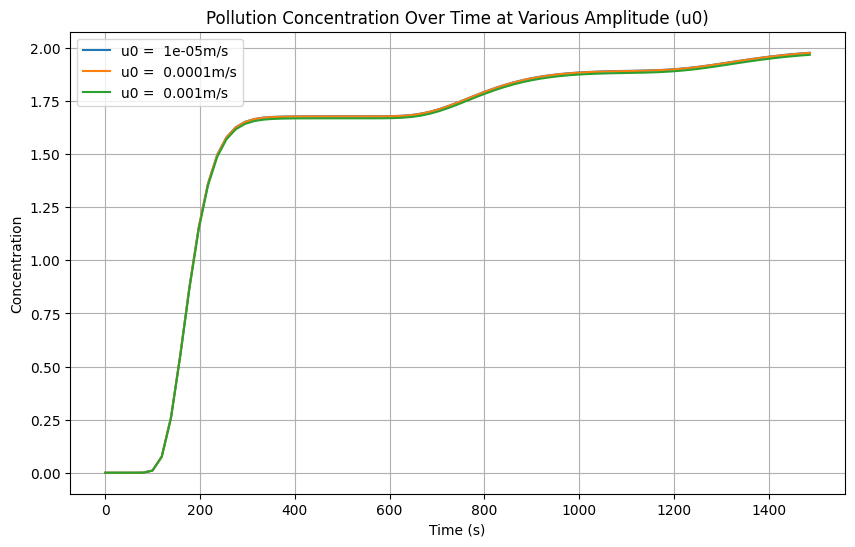

In [18]:
# Target coordinates
target_x = 20  # Example x coordinates in meters
target_y = 2   # Example y coordinates in meters
# Find the nearest indices
x_indices = (np.abs(x - target_x)).argmin()  # Nearest x index from simulation grid
y_indices = (np.abs(y - target_y)).argmin()  # Nearest y index from simulation grid

# Prepare to plot for varying U0
plt.figure(figsize=(10, 6))
u0_list = [0.00001,0.0001,0.001]
for u0_i in u0_list:
    c_concentration, t_sim_save = simulate_turbulent_pollution(u0=u0_i, k=0.897597901) #lambda = 8
    concentration_over_time = c_concentration[:, x_indices, y_indices]
    plt.plot(t_sim_save, concentration_over_time, label=f'u0 =  {u0_i}m/s')
plt.xlabel('Time (s)')
plt.ylabel('Concentration')
plt.title('Pollution Concentration Over Time at Various Amplitude (u0)')
plt.legend()
plt.grid()
plt.show()

The amplitude ($u0$) represents the intensity of the fluctuating velocity field in turbulent flow. Higher amplitudes result in more vigorous and intense velocity fluctuations. As $u0$ increases, the tracer is transported more quickly across the river. This is because larger velocity fluctuations enhance the mixing and dispersion capabilities of the turbulent flow.

In turbulent conditions, the tracer is transported more quickly compared to laminar flow conditions. This is because the chaotic nature of turbulent eddies allows for enhanced mixing and faster dispersion of the tracer across the flow.



## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.